In [1]:
# Get packages

import numpy as np
import mne
import seaborn as sns
import matplotlib.pyplot as plt
import os
from pathlib import Path
import pathlib
import pandas as pd
import scipy as sp
from tqdm.notebook import tqdm 
from collections import Counter
from collections import OrderedDict
import statsmodels.formula.api as smf
import xarray as xr
import statsmodels.api as sm
from mne import create_info

from mne.io import RawArray
from mne.viz.topomap import _add_colorbar
from mne.viz import plot_topomap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from statsmodels.stats.anova import AnovaRM
import warnings
from scipy.stats import shapiro
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pingouin as pg



import docx
from docx.enum.section import WD_ORIENT
from docx.enum.section import WD_SECTION
from docx.enum.text import WD_ALIGN_PARAGRAPH
from docx.shared import Pt
from scipy.stats import chi2
from scipy.stats.mstats import winsorize



c:\Users\gabot\anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


# Linear models for lateralization 

#### Functions

In [2]:
def stage_model(model):

    coef_df = pd.DataFrame(model.summary().tables[1]).reset_index()
    if "Coef." not in coef_df.columns:
            # Make the first row the columns
            coef_df.columns = coef_df.iloc[0].astype(str)
            # Drop the first row
            coef_df = coef_df[1:]
            # Drop the first column
            coef_df = coef_df.drop(columns=["0"])
            # Rename the columns
            coef_df.rename(columns={"": "index", "coef":'Coef.','std err':'Std.Err.', "t":"stat","P>|t|":"pval"}, inplace=True)
            coef_df['Coef.']=coef_df['Coef.'].astype(str)
            coef_df['Std.Err.']=coef_df['Std.Err.'].astype(str)
            coef_df['stat']=coef_df['stat'].astype(str)
            coef_df['pval']=coef_df['pval'].astype(str)
            coef_df['[0.025']=coef_df['[0.025'].astype(str)
            coef_df['0.975]']=coef_df['0.975]'].astype(str)
            coef_df["index"]= coef_df["index"].astype(str)


    else: 
        coef_df.rename(columns={"z":"stat", "P>|z|":"pval"}, inplace=True)
            
            
    # Drop unwanted rows where z values are ''
    coef_df = coef_df.loc[coef_df.stat != ''].copy()    

    # Drop the intercept row as well
    coef_df = coef_df.loc[coef_df["index"].isin(['Intercept']) == False]

    # Convert numeric columns to float
    coef_df['Coef.'] = coef_df['Coef.'].astype(float)
    coef_df['[0.025'] = coef_df['[0.025'].astype(float)
    coef_df['pval']= coef_df['pval'].astype(float)
    
    # Calculate errors
    coef_df['errors'] = coef_df['Coef.'] - coef_df['[0.025']

    return coef_df


def coefplot_gap(results, multiple_models=False, fig_name=None):
    '''
    Creates a coefficient plot with confidence intervals.
    
    Parameters:
    results : statsmodels results object or DataFrame
        If multiple_models=False: statsmodels results object
        If multiple_models=True: DataFrame with columns: index, model, Coef., [0.025, P>|z|
    multiple_models : bool, default False
        Whether to create a plot for multiple models or single model
    
    Returns:
        matplotlib plot
    '''
    # Create/process dataframe based on input type
    if not multiple_models:
        coef_df = pd.DataFrame(results.summary().tables[1]).reset_index()
        coef_df=stage_model(results)

    else:
        coef_df = results.copy()
    
    
    
    # Create significance indicators - make them consistent between both cases
    if multiple_models:
        coef_df['Significance'] = coef_df['pval'].apply(
            lambda x: 'Significant' if x < 0.05 else 'Not Significant'
        )
    else:
        # Changed to match the multiple models case
        coef_df['Significance'] = coef_df['pval'].apply(
            lambda x: 'Significant' if x < 0.05 else 'Not Significant'
        )
    
    # Clean up Treatment variable names
    for var_name in coef_df['index'].unique():
        if "Treatment" in var_name:
            if ":" in var_name:
                var1 = var_name.split("[",1)[1].split("]")[0]
                var2 = var_name.split("[", 2)[-1]
                new_var_name = var1 + ":" + var2
            else:
                new_var_name = var_name.split("[", 1)[1].split("]")[0]
            coef_df['index'] = coef_df['index'].replace(var_name, new_var_name)
    
    # Create plot
    fig, ax = plt.subplots(figsize=(18, 10))
    
    # Define consistent marker styles
    marker_styles = {'Significant': 'X', 'Not Significant': 'o'}
    

    if multiple_models:
        # Get models and calculate positions
        models = coef_df['model'].unique()
        variables = coef_df['index'].unique()
        n_models = len(models)
        space_between = 3.5
        model_spacing = 1.0
        
        # Create position mapping
        positions = {}
        # Sort variables by their average coefficient value (lowest to highest)
        var_means = coef_df.groupby('index')['Coef.'].mean().sort_values()
        sorted_vars = var_means.index
        
        for i, var in enumerate(sorted_vars):
            base_pos = i * (n_models + space_between)
            for j, model in enumerate(models):
                positions[(var, model)] = base_pos + (j * model_spacing)
        
        # Add plot positions
        coef_df['plot_position'] = coef_df.apply(
            lambda row: positions[(row['index'], row['model'])], 
            axis=1
        )
        
        # Set up colors for multiple models
        model_palette = sns.color_palette("husl", n_colors=len(models))
        model_colors = dict(zip(models, model_palette))
        
        # Plot error bars
        for model in models:
            model_data = coef_df[coef_df['model'] == model]
            plt.errorbar(x=model_data['Coef.'],
                        y=model_data['plot_position'],
                        xerr=model_data['errors'],
                        color=model_colors[model],
                        capsize=3,
                        fmt='none',
                        alpha=0.7,
                        zorder=1)
        
        # Plot points
        g = sns.scatterplot(data=coef_df,
                           x='Coef.',
                           y='plot_position',
                           hue='model',
                           style='Significance',
                           markers=marker_styles,
                           palette=model_colors,
                           s=200,
                           zorder=3,
                           ax=ax)
        
        # Set y-ticks
        tick_positions = []
        for i, var in enumerate(sorted_vars):
            base_pos = i * (n_models + space_between)
            middle_pos = base_pos + ((n_models - 1) * model_spacing) / 2
            tick_positions.append(middle_pos)
        
        ax.set_yticks(tick_positions)
        ax.set_yticklabels(sorted_vars)
        
        # Create legends
        g.legend_.remove()
        
        # Model legend
        model_legend = ax.legend(
            title='Models',
            handles=[plt.Line2D([], [], marker='o', color=color, linestyle='None', 
                               markersize=10, label=model)
                    for model, color in model_colors.items()],
            bbox_to_anchor=(1.02, 1),
            loc='upper left'
        )
        
        # Significance legend
        significance_handles = [
            plt.Line2D([], [], marker='X', color='gray', linestyle='None', 
                      markersize=10, label='Significant'),
            plt.Line2D([], [], marker='o', color='gray', linestyle='None', 
                      markersize=10, label='Not Significant')
        ]
        
        ax.add_artist(model_legend)
        ax.legend(handles=significance_handles,
                 title='Significance',
                 bbox_to_anchor=(1.02, 0.6),
                 loc='upper left')
        
    else:
        # Sort the dataframe by coefficient values (lowest to highest)
        coef_df = coef_df.sort_values(by='Coef.', ascending=False)
        
        # Single model plot
        palette = sns.color_palette("Set1")
        color_map = {'Significant': palette[0], 'Not Significant': palette[1]}
        
        # Error bars
        for idx, row in coef_df.iterrows():
            error_color = color_map[row['Significance']]
            plt.errorbar(x=row['Coef.'], 
                        y=row['index'], 
                        xerr=row['errors'],
                        color=error_color, 
                        capsize=3,
                        fmt='none', 
                        zorder=1)
        
        # Scatter plot with consistent markers
        g = sns.scatterplot(y='index',
                           x='Coef.',
                           style='Significance',
                           hue='Significance',
                           markers=marker_styles,
                           palette=color_map,
                           s=200,
                           data=coef_df,
                           zorder=3,
                           ax=ax)
    
    # Common plot elements
    ax.axvline(x=0, linestyle='--', color='red', linewidth=1)
    
    # Set title & labels
    title = 'Coefficients Across Models w/ 95% Confidence Intervals' if multiple_models else 'Coefficients of Features w/ 95% Confidence Intervals'
    plt.title(title, fontsize=30)
    ax.set_ylabel('Variables' if multiple_models else 'Coefficients', fontsize=22)
    ax.set_xlabel('Coefficient Value' if multiple_models else '', fontsize=22)
    
    # Set x-axis limits
    ax.set_xlim(coef_df['Coef.'].min() - max(coef_df['errors']),
                coef_df['Coef.'].max() + max(coef_df['errors']))
    
    plt.tight_layout()

        # Add to the document
    
    if multiple_models:
        print("Multiple models coefficient plot")
        #doc.add_paragraph('Multiple models coefficient plot', style='List Bullet')
    else:
        print("Single model coefficient plot")
         #doc.add_paragraph('Mixed effects model results', style='List Bullet')

    # Save the plot 
    #plt.savefig(f"C:/Users/gabot/OneDrive - McGill University/Desktop/Q1K_neurosubs_2025/results/gap/figures/mixed_effects_model_{fig_name}_{date}.png")

    plt.show()
    return plt.show()
# create a function to check the assumptions of the model
# Function for homoscedasticity

def check_homoscedasticity(model, data, show_text= True, co_vars = None):
    # Check for multicollinearity
    vif = pd.DataFrame()
    vif["variables"] = model.model.exog_names
    # Drop the intercept
    vif["VIF"] = [variance_inflation_factor(model.model.exog, i) for i in range(model.model.exog.shape[1])]
    vif = vif.loc[vif["variables"] != "Intercept"]
        
    homoscedasticity_per_variable = []
    #levene_test = stats.levene(model.fittedvalues, model.resid)

        # Get residuals
    residuals = model.resid
    fitted = model.fittedvalues
    
    # Levene's test for homoscedasticity
    groups = pd.qcut(fitted, q=4)  # Create groups based on fitted values
    levene = stats.levene(*[group_residuals for name, group_residuals in residuals.groupby(groups)])


    if levene[1] < 0.05:
        print("Residuals are not homoscedastic", levene)
    # Do other tests to check for homoscedasticity such as bartlett or White test as well as normality test
    bartlett_test = stats.bartlett(model.fittedvalues, model.resid)
    white_test = statsmodels.stats.diagnostic.het_white(model.resid, model.model.exog)
    shapiro_test = stats.shapiro(model.resid)

    if show_text:
        print(f'Bartlett’s test p-value: {bartlett_test[1]}')
    # White test
        print(f'White test p-value: {white_test[1]}')  
        print(f'Levene’s test p-value for the whole model: {levene[1]}')
    homoscedasticity_per_variable.append({"levene_test_all": levene[1]})
    homoscedasticity_per_variable.append({"white_test": white_test[1]})
    homoscedasticity_per_variable.append({"bartlett_test": bartlett_test[1]})
    homoscedasticity_per_variable.append({"shapiro_test": shapiro_test[1]})
    homoscedasticity_per_variable.append({"multicollinearity": vif["VIF"].max()})               

    for variable in co_vars:
        if variable not in data.columns:
            continue
        residuals = model.resid
        group1 = residuals[data[variable] == data[variable].unique()[0]]
        group2 = residuals[data[variable] == data[variable].unique()[1]]

        stat, p_value = stats.levene(group1, group2)
        if show_text:
            print(f'Levene’s test p-value for variable {variable}: {p_value}')
        homoscedasticity_per_variable.append({variable: p_value.round(5)})
    homoscedasticity_df = pd.DataFrame(homoscedasticity_per_variable)
    homoscedasticity_df = pd.DataFrame([homoscedasticity_df.max()])

    print("Homoscedasticiyy checked")
    return homoscedasticity_df


def check_assumptions(model, data, show_plots=True, show_text= True, covariates = None):
    # Check for normality of residuals
    if show_plots: 
        # Check for normality of residuals
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        
        # Residuals vs Fitted
        sns.scatterplot(
            x=model.fittedvalues,
            y=model.resid,
            ax=axes[0,0]
        )
        axes[0,0].axhline(y=0, color='r', linestyle='--')
        axes[0,0].set_xlabel('Fitted values')
        axes[0,0].set_ylabel('Residuals')
        axes[0,0].set_title('Residuals vs Fitted')
        
        # QQ Plot
        stats.probplot(model.resid, dist="norm", plot=axes[0,1])
        axes[0,1].set_title('Normal Q-Q Plot')
        
        sns.scatterplot(
            x=model.fittedvalues,
            y=model.resid,
            ax=axes[1,0]
        )
        axes[1,0].set_xlabel('Fitted values')
        axes[1,0].set_ylabel('Residuals')
        axes[1,0].set_title('Homoscedasticity')
        
        # Residuals histogram
        sns.histplot(model.resid, kde=True, ax=axes[1,1])
        axes[1,1].set_title('Residuals Distribution')
        
        plt.tight_layout()
        plt.show()
    if show_text:
        shapiro_test = stats.shapiro(model.resid)
        print(f'Shapiro-Wilk test p-value: {shapiro_test[1]}')

    # Test for homoscedasticity using levens test 
    check_homoscedasticity(model, data,show_text= True, co_vars = covariates)

        
    return "Assumptions checked"

# Function to convert df to docx table format

def df_to_table(doc, df):
    # Add a table to the end and create a reference variable
    t = doc.add_table(df.shape[0]+1, df.shape[1])

    # Make sure df is rounded 
    df = df.round(2)

    # Make sure table is auto fit
    for cell in t._cells:
        cell.width = docx.shared.Inches(1.0)
    
    # Set the style of the table
    table_style = doc.styles['Table Grid']

    # Add the header rows.
    for j in range(df.shape[-1]):
        t.cell(0,j).text = df.columns[j]

    # Add the rest of the data frame
    for i in range(df.shape[0]):
        for j in range(df.shape[-1]):
            t.cell(i+1,j).text = str(df.values[i,j])
    
    return doc




In [3]:
date="01_29_2025"
derivative= "bands"
derivative_used= False


In [4]:
# Create a document
doc = docx.Document()


# Add a blank paragraph to push the heading to the middle of the page
for _ in range(10):  # Adjust this number to position the heading vertically
    doc.add_paragraph()

# Add the heading
heading = doc.add_paragraph()
if derivative_used:
    heading_run = heading.add_run(f"Lateralization infant results {date} {derivative}")
else:
    heading_run = heading.add_run(f"Lateralization infant results {date} ")
heading_run.bold = True
heading_run.font.size = Pt(20)  # Set font size
heading_run.font.name = 'Arial'  # Set font type


# Center align the heading
heading_run.alignment = WD_ALIGN_PARAGRAPH.CENTER

author = doc.add_paragraph( "Results by : Gabriel Blanco")
author.alignment = WD_ALIGN_PARAGRAPH.CENTER

# Add new doc section with landscape orientation
section = doc.add_section()
section.start_type = WD_SECTION.ODD_PAGE
new_width, new_height = section.page_height, section.page_width
section.orientation = WD_ORIENT.LANDSCAPE
section.page_width = new_width


doc.add_heading(f"Linear model results", 0)




# **Research questions**

### 1. Are there differences between infants with ASD and without ASD overall?

### 2. Are these differences modulated by EEG band (theta, alpha, beta, gamme)?

### 3. If so, are these differences modulated by sex and age (i.e., do infants with ASD have decreased latearlization over time)?

### 4. If differences area found, what brain regions are driving these differences?

### 5. Which brain networks show differences?

In [6]:
# Drop rows with nan values in band 
eeg_long = eeg_long[eeg_long.band.isna() == False]
eeg_long = eeg_long[eeg_long["band"] != "broadband"]


In [7]:
## Drop participants with unknown outcome
eeg_long = eeg_long[eeg_long.outcome.isna() == False]

In [8]:
eeg_long.network.unique()

array(['DMN', 'all_regions', 'attn', 'auditory', 'lang', 'visual'],
      dtype=object)

In [9]:
eeg_long.columns

Index(['subject', 'network', 'age', 'freq', 'l_index', 'band', 'site',
       'group_type', 'outcome', 'sex'],
      dtype='object')

In [10]:
## Participant demographics

In [11]:
eeg_long.loc[(eeg_long.band=="gamma") & (eeg_long.network=="auditory") & (eeg_long.age!=18)].groupby(["group_type", "age", "site", "sex"]).outcome.value_counts()

group_type  age  site        sex  outcome
ELA         6    london      F    no-asd     17
                                  asd         2
                             M    asd         9
                                  no-asd      6
                 washington  F    asd         6
                                  no-asd      6
                             M    no-asd     21
                                  asd         2
            12   london      F    no-asd     22
                                  asd         5
                             M    asd         9
                                  no-asd      9
                 washington  F    asd         6
                                  no-asd      5
                             M    no-asd     19
                                  asd         4
TLA         6    london      F    no-asd     21
                             M    no-asd     12
                 washington  F    no-asd     14
                                  asd         

### Participant demographics Table 1

In [12]:
# Create age groups
entire_sample = eeg_long.loc[(eeg_long.band=="gamma") & (eeg_long.network=="auditory") & (eeg_long.age!=18)]
entire_sample['age_group'] = pd.cut(entire_sample['age'],
                               bins=[0, 7, 14],
                               labels=['6-7 months', '12-14 months'])

# Create the table
table = (entire_sample.groupby(['age_group', 'group_type', 'outcome'])
         .agg(N=('sex', 'count'),
              females=('sex', lambda x: (x == 'F').sum()))
         .reset_index())

# Calculate totals for each group_type within age_group
totals = (table.groupby(['age_group', 'group_type'])
          .agg({'N': 'sum'})
          .rename(columns={'N': 'Total'})
          .reset_index())

# Merge totals back
final_table = pd.merge(table, totals, on=['age_group', 'group_type'])

# Add combined groups
combined = (final_table.groupby(['age_group', 'outcome'])
            .agg({'N': 'sum',
                  'females': 'sum',
                  'Total': 'sum'})
            .assign(group_type='Combined')
            .reset_index())

# Combine all data
final_table = pd.concat([final_table, combined]).sort_values(['age_group', 'group_type', 'outcome'])

# Format the output
final_table['N (females)'] = final_table['N'].astype(str) + ' (' + final_table['females'].astype(str) + ')'
final_table = final_table[['age_group', 'group_type', 'outcome', 'N (females)', 'Total']]

# Rename columns to match your example
final_table = final_table.rename(columns={
    'age_group': 'Age Group',
    'group_type': 'Likelihood Group',
    'outcome': 'Outcome'
})

final_table

C:\Users\gabot\AppData\Local\Temp\ipykernel_5592\1128160025.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entire_sample['age_group'] = pd.cut(entire_sample['age'],


Age Group Likelihood Group Outcome N (females)  Total
0    6-7 months         Combined     asd      22 (9)    140
1    6-7 months         Combined  no-asd    118 (58)    140
0    6-7 months              ELA     asd      19 (8)     69
1    6-7 months              ELA  no-asd     50 (23)     69
2    6-7 months              TLA     asd       3 (1)     71
3    6-7 months              TLA  no-asd     68 (35)     71
2  12-14 months         Combined     asd     26 (12)    152
3  12-14 months         Combined  no-asd    126 (66)    152
4  12-14 months              ELA     asd     24 (11)     79
5  12-14 months              ELA  no-asd     55 (27)     79
6  12-14 months              TLA     asd       2 (1)     73
7  12-14 months              TLA  no-asd     71 (39)     73

In [13]:
eeg_long.loc[(eeg_long.band=="gamma") & (eeg_long.network=="all_regions") & (eeg_long.age!=18)].groupby(["group_type", "age"]).outcome.value_counts()

group_type  age  outcome
ELA         6    no-asd     50
                 asd        19
            12   no-asd     55
                 asd        24
TLA         6    no-asd     68
                 asd         3
            12   no-asd     71
                 asd         2
Name: outcome, dtype: int64

### Mean lateralization values for each group

In [15]:
# Derive mean values for each likelihood group

bands = ['theta', 'alpha', 'beta', 'gamma']
groups = eeg_long['group_type'].unique()
ages = [6,12]

# Assuming there's a 'subject_id' column - change this to your actual subject identifier
subject_id_col = 'subject'  

results = []
for group in groups:
    for age in ages:
        if age == 18:  # Skip age 18 as in your original condition
            continue
            
        # First get the number of unique subjects for this group-age combination
        n_subjects = eeg_long.loc[
            (eeg_long.group_type == group) & 
            (eeg_long.age == age),
            subject_id_col
        ].nunique()
        
        band_data = {'Group': group, 'Age': age, 'n': n_subjects}
        
        for band in bands:
            subset = eeg_long.loc[
                (eeg_long.band == band) & 
                (eeg_long.network == "all_regions") & 
                (eeg_long.age == age) & 
                (eeg_long.group_type == group)
            ]
            mean = subset['l_index'].mean()
            std = subset['l_index'].std()
            # Check if the mean is significantly different from 0 using a t-test
            t_stat, p_value = stats.ttest_1samp(subset['l_index'], 0)
            if p_value < 0.05:
                band_data[band] = f"{mean:.3f} ({std:.3f}) *"
            else:
                band_data[band] = f"{mean:.3f} ({std:.3f})"
                
        results.append(band_data)

# Convert to DataFrame
result_df = pd.DataFrame(results)

# Reorder columns to match your desired output
column_order = ['Group', 'n', 'Age'] + bands
result_df = result_df[column_order]

# Set multi-index if desired
result_df.set_index(['Group', 'Age'], inplace=True)

print("Descriptive Statistics")
print("\tMean Lateralization (sd)")

# Save as csv file 
result_df

Descriptive Statistics
	Mean Lateralization (sd)


n            theta            alpha             beta  \
Group Age                                                          
ELA   6    69  0.046 (0.072) *  0.060 (0.078) *  0.028 (0.090) *   
      12   79   -0.007 (0.058)   -0.003 (0.065)    0.009 (0.077)   
TLA   6    71  0.053 (0.050) *  0.060 (0.058) *  0.048 (0.082) *   
      12   73    0.004 (0.070)    0.007 (0.085)    0.013 (0.087)   

                     gamma  
Group Age                   
ELA   6      0.018 (0.093)  
      12     0.012 (0.087)  
TLA   6    0.040 (0.095) *  
      12     0.010 (0.093)

In [16]:
#Derive mean values for each outcome group

groups = eeg_long['outcome'].unique()
ages = [6,12]

# Assuming there's a 'subject_id' column - change this to your actual subject identifier
subject_id_col = 'subject'  

results = []
for group in groups:
    for age in ages:
        if age == 18:  # Skip age 18 as in your original condition
            continue
            
        # First get the number of unique subjects for this group-age combination
        n_subjects = eeg_long.loc[
            (eeg_long.outcome == group) & 
            (eeg_long.age == age),
            subject_id_col
        ].nunique()
        
        band_data = {'Group': group, 'Age': age, 'n': n_subjects}
        
        for band in bands:
            subset = eeg_long.loc[
                (eeg_long.band == band) & 
                (eeg_long.network == "all_regions") & 
                (eeg_long.age == age) & 
                (eeg_long.outcome == group)
            ]
            mean = subset['l_index'].mean()
            std = subset['l_index'].std()
            # Check if the mean is significantly different from 0 using a t-test
            t_stat, p_value = stats.ttest_1samp(subset['l_index'], 0)
            if p_value < 0.05:
                band_data[band] = f"{mean:.3f} ({std:.3f}) *"
            else:
                band_data[band] = f"{mean:.3f} ({std:.3f})"
        
        results.append(band_data)

# Convert to DataFrame
result_df = pd.DataFrame(results)

# Reorder columns to match your desired output
column_order = ['Group', 'n', 'Age'] + bands
result_df = result_df[column_order]

# Set multi-index if desired
result_df.set_index(['Group', 'Age'], inplace=True)

print("Descriptive Statistics")
print("\tMean Lateralization (sd)")

# Save as csv file 
result_df

Descriptive Statistics
	Mean Lateralization (sd)


n            theta            alpha             beta  \
Group  Age                                                           
no-asd 6    118  0.049 (0.061) *  0.061 (0.068) *  0.041 (0.086) *   
       12   126    0.003 (0.065)    0.006 (0.077)    0.006 (0.079)   
asd    6     22  0.051 (0.068) *  0.053 (0.070) *    0.020 (0.090)   
       12    26   -0.022 (0.057)   -0.018 (0.062)  0.038 (0.091) *   

                      gamma  
Group  Age                   
no-asd 6    0.032 (0.094) *  
       12     0.003 (0.085)  
asd    6      0.012 (0.093)  
       12   0.050 (0.102) *

In [17]:
# Summarize data by diagnosis groups
summary_table = demo_df.groupby("outcome").agg(
    n=("outcome", "count"),
    male=("sex", lambda x: (x == "M").sum()),
    female=("sex", lambda x: (x == "F").sum()),
    london=("site", lambda x: (x == "london").sum()),
    washington=("site", lambda x: (x == "washington").sum()),
    ELA=("group_type", lambda x: (x == "ELA").sum()),
    TLA=("group_type", lambda x: (x == "TLA").sum()),
).reset_index()

# Add combined row for all participants
all_participants = {
    "outcome": "combined",
    "n": summary_table["n"].sum(),
    "male": summary_table["male"].sum(),
    "female": summary_table["female"].sum(),
    "london": summary_table["london"].sum(),
    "washington": summary_table["washington"].sum(),
    "ELA": summary_table["ELA"].sum(),
    "TLA": summary_table["TLA"].sum(),
}

summary_table = pd.concat(
    [pd.DataFrame([all_participants]), summary_table], ignore_index=True
)

# Create combined and percentage columns
summary_table["sex (M:F)"] = summary_table["male"].astype(str) + ":" + summary_table["female"].astype(str)
summary_table["sex % (M:F)"] = (
    (summary_table["male"] / summary_table["n"] * 100).round(2).astype(str)
    + ":"
    + (summary_table["female"] / summary_table["n"] * 100).round(2).astype(str)
)

summary_table["site (london:washington)"] = summary_table["london"].astype(str) + ":" + summary_table["washington"].astype(str)
summary_table["site % (london:washington)"] = (
    (summary_table["london"] / summary_table["n"] * 100).round(2).astype(str)
    + ":"
    + (summary_table["washington"] / summary_table["n"] * 100).round(2).astype(str)
)

# Drop intermediate columns to keep the table clean
summary_table.drop(columns=["male", "female", "london", "washington"], inplace=True)

# Rename columns for better clarity
summary_table.rename(
    columns={
        "outcome": "Diagnostic group",
        "n": "Total Participants",
        "ELA": "ELA",
        "TLA": "TLA",
    },
    inplace=True,
)

print(summary_table)

  Diagnostic group  Total Participants  ELA  TLA sex (M:F)  sex % (M:F)  \
0         combined                 184   94   90     93:91  50.54:49.46   
1              asd                  32   29    3     18:14  56.25:43.75   
2           no-asd                 152   65   87     75:77  49.34:50.66   

  site (london:washington) site % (london:washington)  
0                   103:81                55.98:44.02  
1                    17:15                53.12:46.88  
2                    86:66                56.58:43.42  


In [18]:
## Add table to the document
doc.add_heading('Demographics', level=1)

doc.add_heading('Demographics table', level=3)

doc = df_to_table(doc, summary_table)


In [19]:
demo_df2=eeg_long.groupby(["subject", "site","group_type","outcome","sex"]).mean().reset_index()

C:\Users\gabot\AppData\Local\Temp\ipykernel_5592\3224406955.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  demo_df2=eeg_long.groupby(["subject", "site","group_type","outcome","sex"]).mean().reset_index()


In [20]:
# Create demogrphics with EEG data

# Summarize data by diagnosis groups
summary_table = demo_df2.groupby("outcome").agg(
    n=("outcome", "count"),
    male=("sex", lambda x: (x == "M").sum()),
    female=("sex", lambda x: (x == "F").sum()),
    london=("site", lambda x: (x == "london").sum()),
    washington=("site", lambda x: (x == "washington").sum()),
    ELA=("group_type", lambda x: (x == "ELA").sum()),
    TLA=("group_type", lambda x: (x == "TLA").sum()),
).reset_index()

# Add combined row for all participants
all_participants = {
    "outcome": "combined",
    "n": summary_table["n"].sum(),
    "male": summary_table["male"].sum(),
    "female": summary_table["female"].sum(),
    "london": summary_table["london"].sum(),
    "washington": summary_table["washington"].sum(),
    "ELA": summary_table["ELA"].sum(),
    "TLA": summary_table["TLA"].sum(),
}

summary_table = pd.concat(
    [pd.DataFrame([all_participants]), summary_table], ignore_index=True
)

# Create combined and percentage columns
summary_table["sex (M:F)"] = summary_table["male"].astype(str) + ":" + summary_table["female"].astype(str)
summary_table["sex % (M:F)"] = (
    (summary_table["male"] / summary_table["n"] * 100).round(2).astype(str)
    + ":"
    + (summary_table["female"] / summary_table["n"] * 100).round(2).astype(str)
)

summary_table["site (london:washington)"] = summary_table["london"].astype(str) + ":" + summary_table["washington"].astype(str)
summary_table["site % (london:washington)"] = (
    (summary_table["london"] / summary_table["n"] * 100).round(2).astype(str)
    + ":"
    + (summary_table["washington"] / summary_table["n"] * 100).round(2).astype(str)
)

# Drop intermediate columns to keep the table clean
summary_table.drop(columns=["male", "female", "london", "washington"], inplace=True)

# Rename columns for better clarity
summary_table.rename(
    columns={
        "outcome": "Diagnostic group",
        "n": "Total Participants",
        "ELA": "ELA",
        "TLA": "TLA",
    },
    inplace=True,
)

print(summary_table)

  Diagnostic group  Total Participants  ELA  TLA sex (M:F)  sex % (M:F)  \
0         combined                 175   90   85     88:87  50.29:49.71   
1              asd                  30   27    3     17:13  56.67:43.33   
2           no-asd                 145   63   82     71:74  48.97:51.03   

  site (london:washington) site % (london:washington)  
0                    96:79                54.86:45.14  
1                    16:14                53.33:46.67  
2                    80:65                55.17:44.83  


### Supplementary Table 1

In [22]:

# Get unique participants at each timepoint
subjects_6mo = eeg_long.loc[eeg_long['age'] == 6, 'subject'].unique()
subjects_12mo = eeg_long.loc[eeg_long['age'] == 12, 'subject'].unique()

# Create sets for participation categories
both_timepoints = set(subjects_6mo) & set(subjects_12mo)
only_6mo = set(subjects_6mo) - set(subjects_12mo)
only_12mo = set(subjects_12mo) - set(subjects_6mo)

# Get group mapping  for each subject
group_mapping = eeg_long.drop_duplicates('subject').set_index('subject')['group_type']

# Count participants in each category by group
count_both = pd.Series([s in both_timepoints for s in group_mapping.index], 
                      index=group_mapping.index).groupby(group_mapping).sum()
count_6mo = pd.Series([s in only_6mo for s in group_mapping.index], 
                     index=group_mapping.index).groupby(group_mapping).sum()
count_12mo = pd.Series([s in only_12mo for s in group_mapping.index], 
                      index=group_mapping.index).groupby(group_mapping).sum()

# Create the supp_table_1 dataframe
supp_table_1 = pd.DataFrame({
    'Participants at Both Timepoints': count_both,
    '6-month Only': count_6mo,
    '12-month Only': count_12mo
})

# Add totals column
supp_table_1['Total Unique Participants'] = supp_table_1.sum(axis=1)

# Add grand total row
supp_table_1.loc['Total'] = supp_table_1.sum()

# Format the table
supp_table_1.index.name = 'ASD Likelihood'
supp_table_1 = supp_table_1.rename(index={'EL': 'ELA', 'TL': 'TLA'}).reset_index()

# Display the final table
print(supp_table_1)


  ASD Likelihood  Participants at Both Timepoints  6-month Only  \
0            ELA                               58            11   
1            TLA                               59            12   
2          Total                              117            23   

   12-month Only  Total Unique Participants  
0             21                         90  
1             14                         85  
2             35                        175  


In [23]:
## Add table to the document
doc.add_heading('Demographics with EEG', level=1)

doc.add_heading('Demographics table', level=3)

doc = df_to_table(doc, summary_table)


In [24]:
## Add Supplementary table to the document
doc.add_heading('Supplementary table 1 table', level=3)

doc = df_to_table(doc, supp_table_1)


In [26]:
# Select the comparison variable 
comp_var = "outcome"

# Plot interactions

## Interactions for band

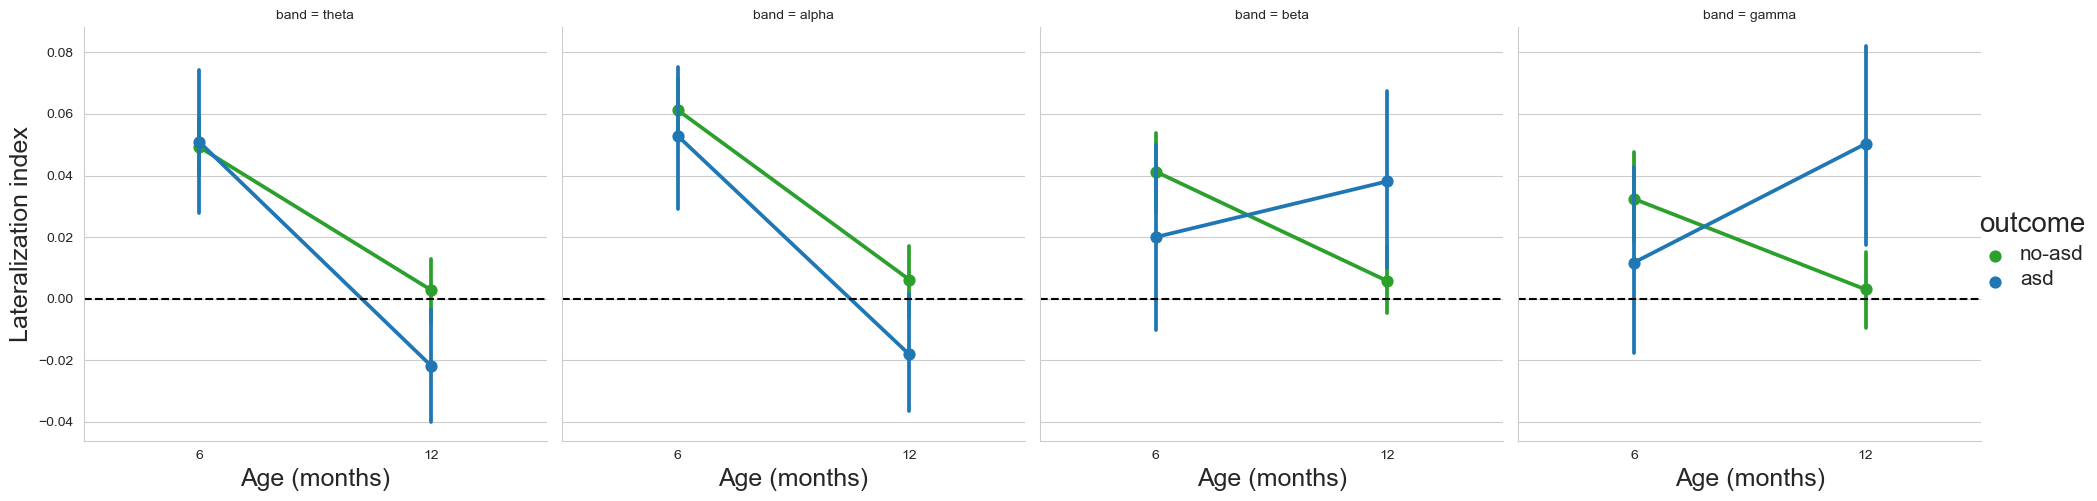

In [27]:
# Plot changes in lateralization for all bands

# Plot the data

sns.set_style('whitegrid')

df_name=eeg_long
df_name=df_name.loc[(df_name.age!=18)]
# Subset only the regions of interest
df_name=df_name.loc[(df_name.network=="all_regions")]
g= sns.catplot(x="age",y="l_index", ci=90,hue=comp_var,palette=["C2","C0", "C3"],data=df_name,col="band", kind="point")
g.set_ylabels("Lateralization index",fontsize=18)
g.set_xlabels("Age (months)",fontsize=18)

# Add a horizontal line at 0 for each plot 

for ax in g.axes.flat:
    ax.axhline(0, color='black', linestyle='--')



plt.setp(g._legend.get_title(), fontsize=20)
plt.setp(g._legend.get_texts(), fontsize=15) # for legend text
#g.savefig("./paper_1_figs/region_trajectories_outcomes.png")
plt.show(g)

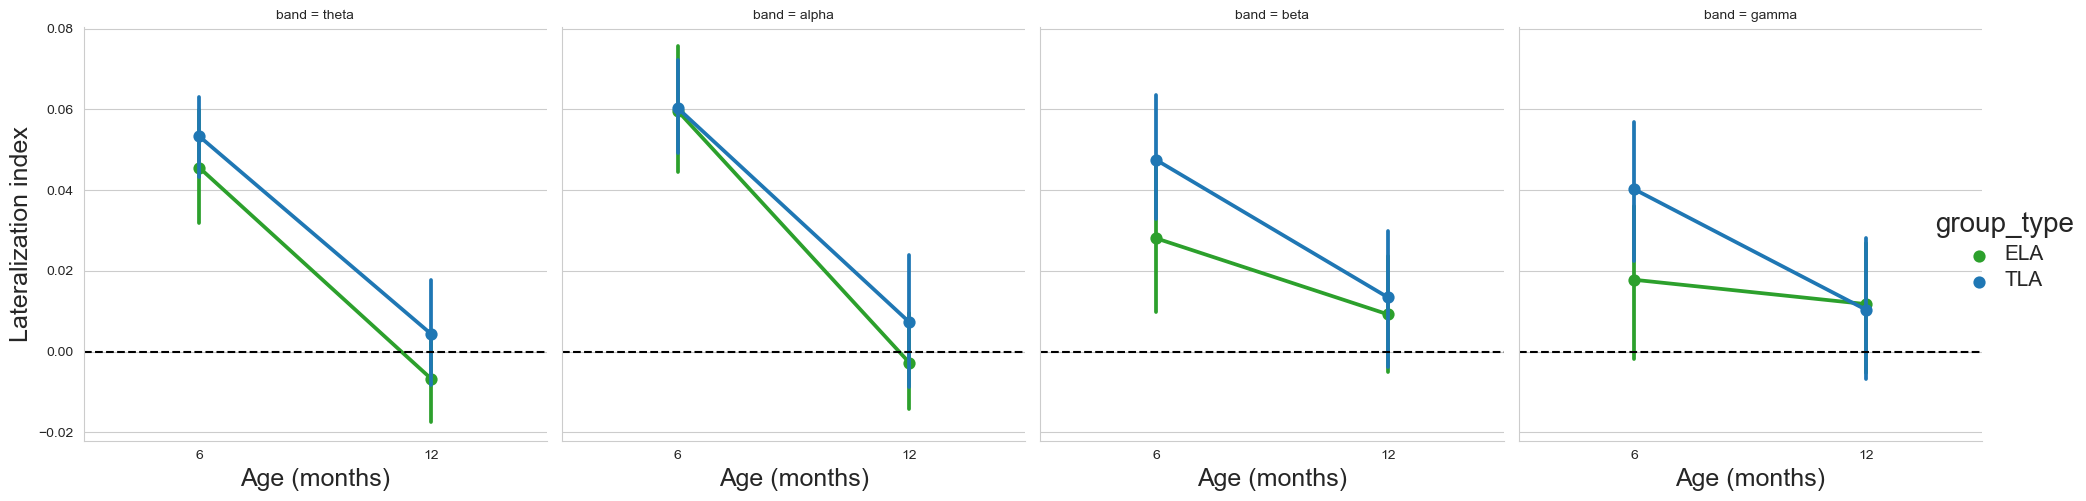

In [28]:
# Plot changes in lateralization for all bands

# Plot the data

sns.set_style('whitegrid')

df_name=eeg_long
df_name=df_name.loc[(df_name.age!=18)]
# Subset only the regions of interest
df_name=df_name.loc[(df_name.network=="all_regions")]
g= sns.catplot(x="age",y="l_index", ci=90,hue="group_type",palette=["C2","C0", "C3"],data=df_name,col="band", kind="point")
g.set_ylabels("Lateralization index",fontsize=18)
g.set_xlabels("Age (months)",fontsize=18)

# Add a horizontal line at 0 for each plot 

for ax in g.axes.flat:
    ax.axhline(0, color='black', linestyle='--')



plt.setp(g._legend.get_title(), fontsize=20)
plt.setp(g._legend.get_texts(), fontsize=15) # for legend text
#g.savefig("./paper_1_figs/region_trajectories_outcomes.png")
plt.show(g)

## Interactions for covariates (sex, group_type, outcome)

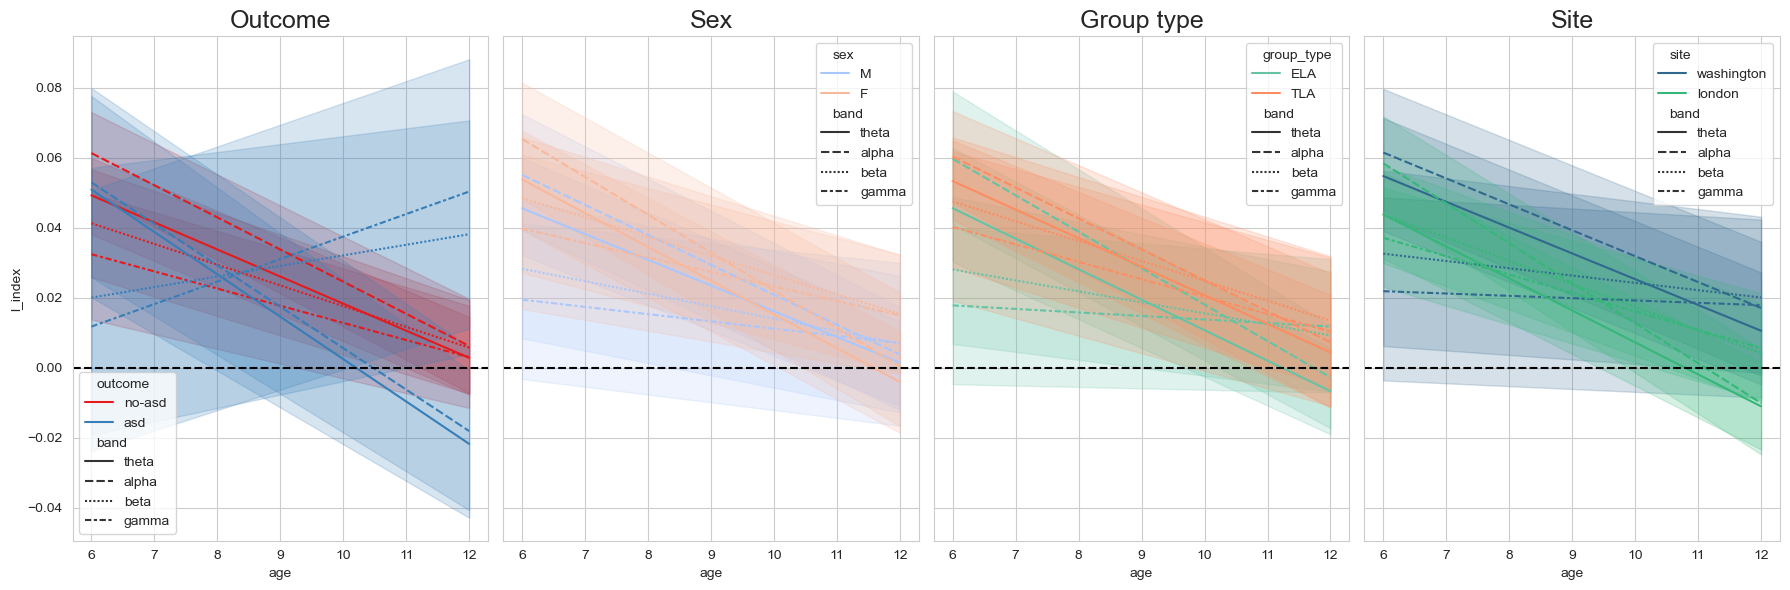

In [29]:
# Plot demographic differences for all regions

plot_df= eeg_long.loc[(eeg_long.age!=18) & (eeg_long.network=="all_regions")]

fig, ax = plt.subplots(1, 4, figsize=(18, 6), sharey=True)

# Plot outcome
sns.lineplot(x="age", y="l_index", data=plot_df, ax=ax[0], hue="outcome", palette= "Set1", style="band")

# Plot sex
sns.lineplot(x="age", y="l_index", data=plot_df, ax=ax[1], hue="sex", palette= "coolwarm",style="band")

# Plot group type
sns.lineplot(x="age", y="l_index", data=plot_df, ax=ax[2], hue="group_type", palette= "Set2",style="band")

# Plot site
sns.lineplot(x="age", y="l_index", data=plot_df, ax=ax[3], hue="site", palette= "viridis",style="band")

# Add horizontal line at 0
for axes in ax:
    axes.axhline(0, color='black', linestyle='--')

# Add titles
ax[0].set_title("Outcome", fontsize=18)
ax[1].set_title("Sex", fontsize=18)
ax[2].set_title("Group type", fontsize=18)
ax[3].set_title("Site", fontsize=18)

plt.tight_layout()
plt.show()




#### **Normality assumptions**

Min: -0.3277611448874534, Max: 0.3689466996069638 Std: 0.08103866847653073


c:\Users\gabot\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


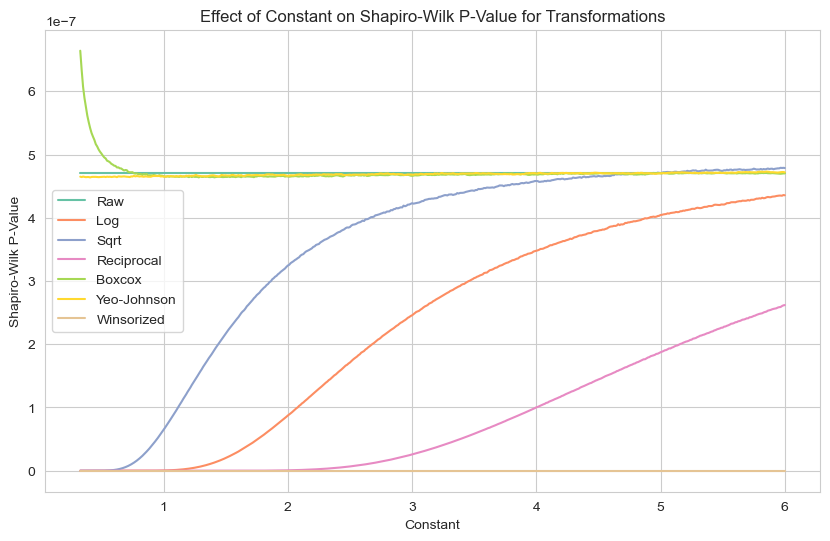

Constant with the highest p-value: 0.33
Shapiro test for l_index: ShapiroResult(statistic=0.9901524186134338, pvalue=4.702704359260679e-07)
Shapiro test for log_l_index: ShapiroResult(statistic=0.7431558966636658, pvalue=4.0955427918174634e-39)
Shapiro test for sqrt_l_index: ShapiroResult(statistic=0.9557088017463684, pvalue=2.5629790097358474e-18)
Shapiro test for reciprocal_l_index: ShapiroResult(statistic=0.0916600227355957, pvalue=0.0)
Shapiro test for boxcox_l_index: ShapiroResult(statistic=0.9904183745384216, pvalue=6.641802769991045e-07)
Shapiro test for yeo_johnson_l_index: ShapiroResult(statistic=0.9901436567306519, pvalue=4.649848222015862e-07)
Shapiro test for winsorized_l_index: ShapiroResult(statistic=0.9755224585533142, pvalue=3.6763639550164984e-13)


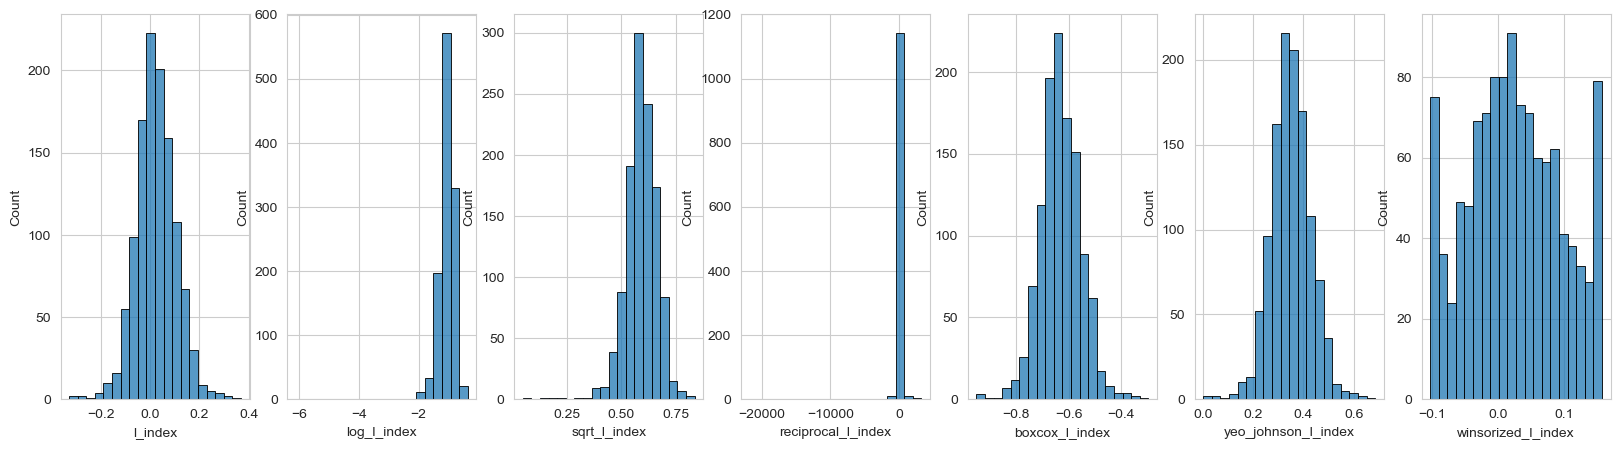

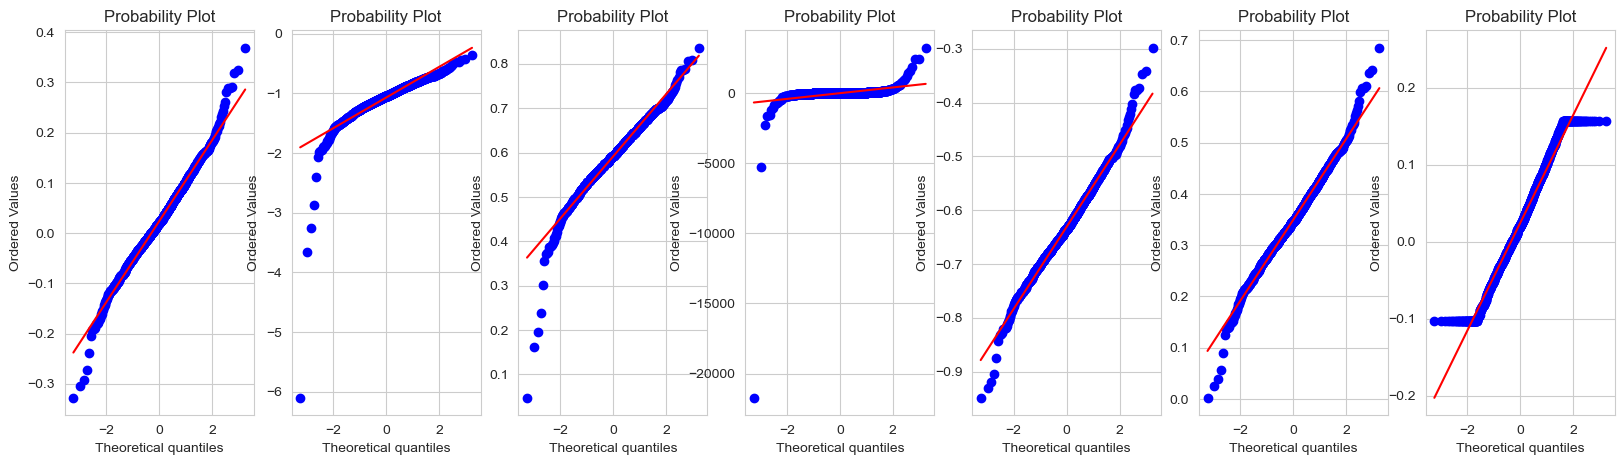

In [30]:
df_name=eeg_long.copy()
df_name=df_name.loc[(df_name.age!=18) & (df_name.network=="all_regions")]

# Drop those without an outcome
df_name = df_name.dropna(subset=[comp_var])

# Print min and max of l_index as well as std dev
print(f"Min: {df_name['l_index'].min()}, Max: {df_name['l_index'].max()}", f"Std: {df_name['l_index'].std()}")

constants = np.linspace(0.33, 6, 500)

results = []

for constant in constants:
    # Apply transformations
    raw_l_index = df_name.l_index
    log_l_index = np.log(df_name.l_index + constant)
    sqrt_l_index = np.sqrt(df_name.l_index + constant)
    reciprocal_l_index = 1 / (df_name.l_index + constant)
    boxcox_l_index, _ = stats.boxcox(df_name.l_index + constant)
    yeo_johnson_l_index, _ = stats.yeojohnson(df_name.l_index + constant)
    winsorized_l_index = winsorize(df_name.l_index, limits=[0.05, 0.05])

    # Perform Shapiro-Wilk tests
    shapiro_raw = stats.shapiro(raw_l_index).pvalue
    shapiro_log = stats.shapiro(log_l_index).pvalue
    shapiro_sqrt = stats.shapiro(sqrt_l_index).pvalue
    shapiro_reciprocal = stats.shapiro(reciprocal_l_index).pvalue
    shapiro_boxcox = stats.shapiro(boxcox_l_index).pvalue
    shapiro_yeo = stats.shapiro(yeo_johnson_l_index).pvalue
    shapiro_winsorized = stats.shapiro(winsorized_l_index).pvalue


    # Save results
    results.append((constant, shapiro_raw,shapiro_log, shapiro_sqrt, shapiro_reciprocal, shapiro_boxcox, shapiro_yeo, shapiro_winsorized))

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=["Constant","Raw", "Log", "Sqrt", "Reciprocal", "Boxcox", "Yeo-Johnson", "Winsorized"])

# Make this into long format
results_long = results_df.melt(id_vars="Constant", var_name="Transformation", value_name="p-value")
results_long

# Find the constant with the highest p-value for each transformation
max_p_values = results_long.groupby("Transformation")["p-value"].idxmax()
max_p_values

# Plot the Shapiro-Wilk p-values for each transformation
plt.figure(figsize=(10, 6))

sns.lineplot(x="Constant", y="p-value", data=results_long, hue="Transformation", palette="Set2")
plt.xlabel("Constant")
plt.ylabel("Shapiro-Wilk P-Value")
plt.title("Effect of Constant on Shapiro-Wilk P-Value for Transformations")
plt.legend()
plt.show()

# Find the constant with the highest p-value and extract it 
max_p_values = results_long["p-value"].idxmax()
max_contstants = results_long.loc[max_p_values]["Constant"]

# Print the constant with the highest p-value
print(f"Constant with the highest p-value: {max_contstants}")

constant =max_contstants

#Applied various trasnformations to l_index, plot histograms and qqplots
df_name["log_l_index"]=np.log(df_name.l_index + constant)
df_name["sqrt_l_index"]=np.sqrt(df_name.l_index + constant)
df_name["reciprocal_l_index"] = 1/df_name.l_index
df_name["boxcox_l_index"] = stats.boxcox(df_name.l_index + constant)[0]
df_name["yeo_johnson_l_index"], lmbda = stats.yeojohnson(df_name.l_index + constant)
df_name["winsorized_l_index"] = winsorize(df_name.l_index, limits=[0.05, 0.05])

fig, axs = plt.subplots(ncols=7, figsize=(20, 5))
sns.histplot(df_name.l_index,edgecolor='black', bins=20, ax=axs[0])
sns.histplot(df_name.log_l_index,edgecolor='black', bins=20, ax=axs[1])
sns.histplot(df_name.sqrt_l_index,edgecolor='black', bins=20, ax=axs[2])    
sns.histplot(df_name.reciprocal_l_index,edgecolor='black', bins=20, ax=axs[3])
sns.histplot(df_name.boxcox_l_index,edgecolor='black', bins=20, ax=axs[4])
sns.histplot(df_name.yeo_johnson_l_index,edgecolor='black', bins=20, ax=axs[5])
sns.histplot(df_name.winsorized_l_index,edgecolor='black', bins=20, ax=axs[6])

fig, axs = plt.subplots(ncols=7, figsize=(20, 5))
stats.probplot(df_name.l_index, dist="norm", plot=axs[0])
stats.probplot(df_name.log_l_index, dist="norm", plot=axs[1])
stats.probplot(df_name.sqrt_l_index, dist="norm", plot=axs[2])
stats.probplot(df_name.reciprocal_l_index, dist="norm", plot=axs[3])
stats.probplot(df_name.boxcox_l_index, dist="norm", plot=axs[4])
stats.probplot(df_name.yeo_johnson_l_index, dist="norm", plot=axs[5])
stats.probplot(df_name.winsorized_l_index, dist="norm", plot=axs[6])

# Print shapiro test for all transformations
shapiro_test = stats.shapiro(df_name["l_index"])
shapiro_test_log = stats.shapiro(df_name["log_l_index"])
shapiro_test_sqrt = stats.shapiro(df_name["sqrt_l_index"])
shapiro_test_reciprocal = stats.shapiro(df_name["reciprocal_l_index"])
shapiro_test_boxcox = stats.shapiro(df_name["boxcox_l_index"])
shapiro_test_yeo = stats.shapiro(df_name["yeo_johnson_l_index"])
shapiro_test_winsorized = stats.shapiro(df_name["winsorized_l_index"])


print(f"Shapiro test for l_index: {shapiro_test}")
print(f"Shapiro test for log_l_index: {shapiro_test_log}")
print(f"Shapiro test for sqrt_l_index: {shapiro_test_sqrt}")
print(f"Shapiro test for reciprocal_l_index: {shapiro_test_reciprocal}")
print(f"Shapiro test for boxcox_l_index: {shapiro_test_boxcox}")
print(f"Shapiro test for yeo_johnson_l_index: {shapiro_test_yeo}")
print(f"Shapiro test for winsorized_l_index: {shapiro_test_winsorized}")


plt.show()




# **Workflow** for linear modelling 

### **Data exploration**

##### 1: Check the model you think makes the most sense to assess data (try to be simple (e.g., OLS) just to get an idea of what the interactions are

##### 2: Plot each of these variables to confirm the intial interactions you saw

##### 3: Start with the most complex model and try to decrease complexity and see if it changes

##### 4: Compare all the model to see which one is better and plot them

##### 5: Update the models by removing unecessary items and try steps 3-4 again

##### 6: Compare your two best models using log-likelihood ratio test

##### 7: Once the best model has been identified, check the model assumptions

##### 8: If assumptions have violated, try different modelling techniques

##### 9: Choose your top two best modelling techniques see if they are different

##### 10: Print your best model and interpret it

### **Step 1:** Create initial exploratory model Lat~ asd  * band * sex * age * group_type * + site

c:\Users\gabot\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                                         Mixed Linear Model Regression Results
Model:                                  MixedLM                      Dependent Variable:                      l_index  
No. Observations:                       1168                         Method:                                  ML       
No. Groups:                             175                          Scale:                                   0.0034   
Min. group size:                        4                            Log-Likelihood:                          1524.2658
Max. group size:                        8                            Converged:                               Yes      
Mean group size:                        6.7                                                                            
-----------------------------------------------------------------------------------------------------------------------
                                                                            Coef.

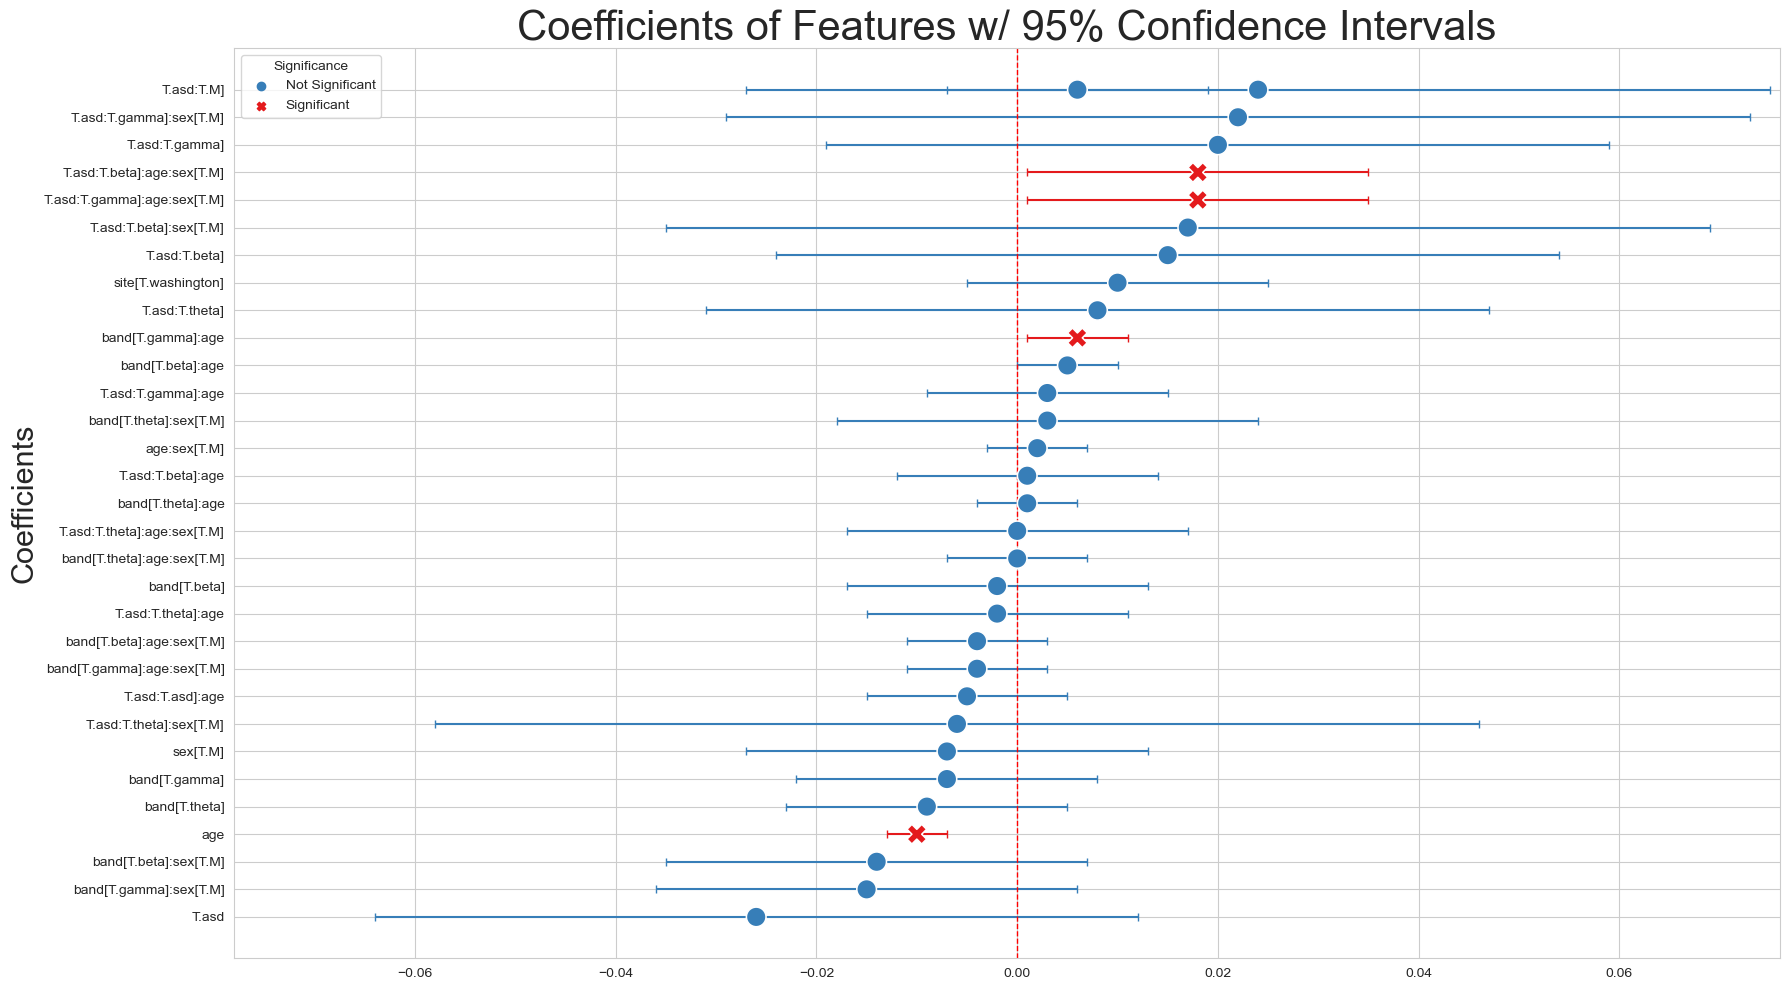

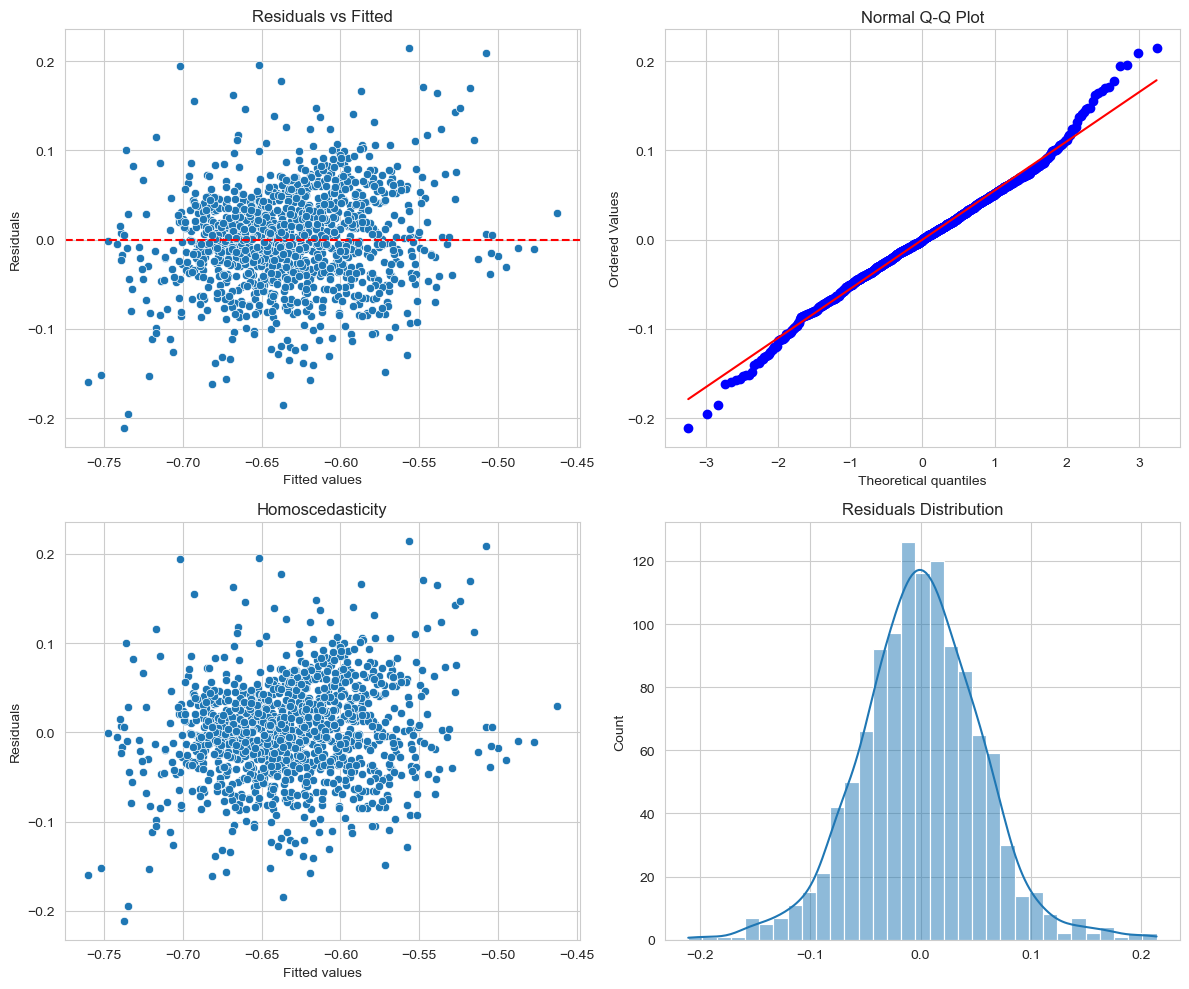

Shapiro-Wilk test p-value: 2.5347876544401515e-06
Residuals are not homoscedastic LeveneResult(statistic=4.209661282050332, pvalue=0.005674719538013859)
Bartlett’s test p-value: 2.224568765327294e-12
White test p-value: 9.786315640943583e-08
Levene’s test p-value for the whole model: 0.005674719538013859
Levene’s test p-value for variable age: 0.34166562547125534
Levene’s test p-value for variable sex: 0.8188547146406938
Levene’s test p-value for variable site: 2.1667482427304826e-15
Homoscedasticiyy checked


'Assumptions checked'

In [37]:
# Create df to be used 
df_name=eeg_long
df_name=df_name.loc[(df_name.age!=18) & (df_name.network=="all_regions")]

# Drop those without an outcome
df_name = df_name.dropna(subset=[comp_var])

# Check if dependent variable is normally distributed
shapiro_test = stats.shapiro(df_name["l_index"])

# Do box cox transformation
df_name["l_index"] = stats.boxcox(df_name["l_index"]+ 0.33)[0]

# Center the age variable
df_name["age"] = df_name["age"] - df_name["age"].mean()

# Model formula 
model_formula = f"l_index ~ C({comp_var}, Treatment(reference='no-asd')) * band  * age * sex + site"

# Simple linear model 
model = smf.ols(model_formula, df_name).fit()

# Model 1: Simple model with age as a fixed effect
model1 = smf.mixedlm(model_formula, df_name, groups=df_name["subject"], re_formula="1").fit(reml=False)

print (model1.summary())

# Extract AIC and BIC
aic = model1.aic
bic = model1.bic
print(aic, bic)

# Check if model converged 
converged = model1.converged
print(f"Print: The model converged: {converged}")
# Plot the model 
coefplot_gap(model1, multiple_models=False, fig_name="original_model")

# Check assumptions
asumption_df=check_assumptions(model1, df_name, show_plots=True, show_text=True, covariates=["age","sex","site", "asd"])
asumption_df



### **Step 2** Plot demographics

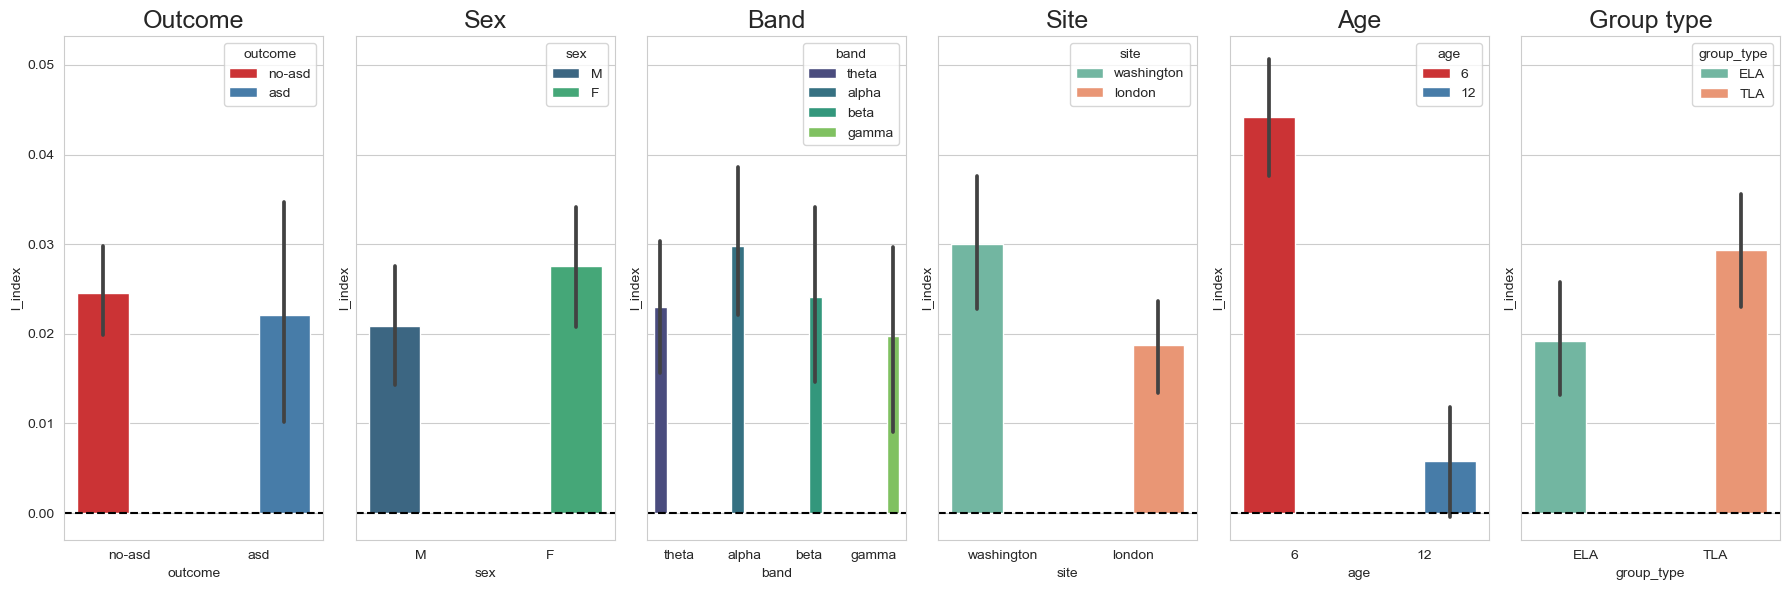

In [38]:
# Plot demographic differences for all regions across ages

plot_df= eeg_long.loc[(eeg_long.age!=18) & (eeg_long.network=="all_regions")]

# Plot all 6 plots
fig, ax = plt.subplots(1, 6, figsize=(18, 6), sharey=True)

# Plot outcome
sns.barplot(x="outcome", y="l_index", data=plot_df, ax=ax[0], hue="outcome", palette= "Set1")

# Plot sex
sns.barplot(x="sex", y="l_index", data=plot_df, ax=ax[1], hue="sex", palette= "viridis")

# Plot band
sns.barplot(x="band", y="l_index", data=plot_df, ax=ax[2], hue="band", palette= "viridis")

# Plot site
sns.barplot(x="site", y="l_index", data=plot_df, ax=ax[3], hue="site", palette= "Set2")

# Plot age
sns.barplot(x="age", y="l_index", data=plot_df, ax=ax[4], hue="age", palette= "Set1")

# Plot group type
sns.barplot(x="group_type", y="l_index", data=plot_df, ax=ax[5], hue="group_type", palette= "Set2")

# Add horizontal line at 0
for axes in ax:
    axes.axhline(0, color='black', linestyle='--')

# Add titles
ax[0].set_title("Outcome", fontsize=18)
ax[1].set_title("Sex", fontsize=18)
ax[2].set_title("Band", fontsize=18)
ax[3].set_title("Site", fontsize=18)
ax[4].set_title("Age", fontsize=18)
ax[5].set_title("Group type", fontsize=18)

plt.tight_layout()
plt.show()


### **Step 3** Start with very complex and decreasing varaibles to see if you improve the model 

c:\Users\gabot\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


4_way_interaction                                          Mixed Linear Model Regression Results
Model:                                  MixedLM                      Dependent Variable:                      l_index  
No. Observations:                       1168                         Method:                                  ML       
No. Groups:                             175                          Scale:                                   0.0034   
Min. group size:                        4                            Log-Likelihood:                          1524.2658
Max. group size:                        8                            Converged:                               Yes      
Mean group size:                        6.7                                                                            
-----------------------------------------------------------------------------------------------------------------------
                                                               

c:\Users\gabot\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


3_way_band_age                                     Mixed Linear Model Regression Results
Model:                               MixedLM                   Dependent Variable:                   l_index  
No. Observations:                    1168                      Method:                               ML       
No. Groups:                          175                       Scale:                                0.0036   
Min. group size:                     4                         Log-Likelihood:                       1505.8185
Max. group size:                     8                         Converged:                            Yes      
Mean group size:                     6.7                                                                      
--------------------------------------------------------------------------------------------------------------
                                                                   Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------

c:\Users\gabot\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


3_way_band_sex                                        Mixed Linear Model Regression Results
Model:                                MixedLM                     Dependent Variable:                     l_index  
No. Observations:                     1168                        Method:                                 ML       
No. Groups:                           175                         Scale:                                  0.0037   
Min. group size:                      4                           Log-Likelihood:                         1489.6920
Max. group size:                      8                           Converged:                              Yes      
Mean group size:                      6.7                                                                          
-------------------------------------------------------------------------------------------------------------------
                                                                        Coef.  Std.Err.    z    

c:\Users\gabot\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


2_way_band_age                                   Mixed Linear Model Regression Results
Model:                             MixedLM                  Dependent Variable:                  l_index  
No. Observations:                  1168                     Method:                              ML       
No. Groups:                        175                      Scale:                               0.0037   
Min. group size:                   4                        Log-Likelihood:                      1485.8385
Max. group size:                   8                        Converged:                           Yes      
Mean group size:                   6.7                                                                    
----------------------------------------------------------------------------------------------------------
                                                               Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------

c:\Users\gabot\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


no_covariates                             Mixed Linear Model Regression Results
Model:                          MixedLM             Dependent Variable:             l_index  
No. Observations:               1168                Method:                         ML       
No. Groups:                     175                 Scale:                          0.0041   
Min. group size:                4                   Log-Likelihood:                 1434.1229
Max. group size:                8                   Converged:                      Yes      
Mean group size:                6.7                                                          
---------------------------------------------------------------------------------------------
                                                 Coef.  Std.Err.    z     P>|z| [0.025 0.975]
---------------------------------------------------------------------------------------------
Intercept                                        -0.631    0.004 -151.994 

c:\Users\gabot\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


band                                   Mixed Linear Model Regression Results
Model:                             MixedLM                  Dependent Variable:                  l_index  
No. Observations:                  1168                     Method:                              ML       
No. Groups:                        175                      Scale:                               0.0041   
Min. group size:                   4                        Log-Likelihood:                      1440.3535
Max. group size:                   8                        Converged:                           Yes      
Mean group size:                   6.7                                                                    
----------------------------------------------------------------------------------------------------------
                                                               Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------

c:\Users\gabot\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


age                               Mixed Linear Model Regression Results
Model:                          MixedLM               Dependent Variable:               l_index  
No. Observations:               1168                  Method:                           ML       
No. Groups:                     175                   Scale:                            0.0037   
Min. group size:                4                     Log-Likelihood:                   1481.8330
Max. group size:                8                     Converged:                        Yes      
Mean group size:                6.7                                                              
-------------------------------------------------------------------------------------------------
                                                     Coef.  Std.Err.    z     P>|z| [0.025 0.975]
-------------------------------------------------------------------------------------------------
Intercept                                     

c:\Users\gabot\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


sex                                 Mixed Linear Model Regression Results
Model:                             MixedLM                Dependent Variable:                l_index  
No. Observations:                  1168                   Method:                            ML       
No. Groups:                        175                    Scale:                             0.0041   
Min. group size:                   4                      Log-Likelihood:                    1437.3869
Max. group size:                   8                      Converged:                         Yes      
Mean group size:                   6.7                                                                
------------------------------------------------------------------------------------------------------
                                                          Coef.  Std.Err.    z     P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------------------

c:\Users\gabot\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


risk                                     Mixed Linear Model Regression Results
Model:                               MixedLM                   Dependent Variable:                   l_index  
No. Observations:                    1168                      Method:                               ML       
No. Groups:                          175                       Scale:                                0.0041   
Min. group size:                     4                         Log-Likelihood:                       1436.0640
Max. group size:                     8                         Converged:                            Yes      
Mean group size:                     6.7                                                                      
--------------------------------------------------------------------------------------------------------------
                                                                   Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------

c:\Users\gabot\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


site                                      Mixed Linear Model Regression Results
Model:                               MixedLM                    Dependent Variable:                    l_index  
No. Observations:                    1168                       Method:                                ML       
No. Groups:                          175                        Scale:                                 0.0041   
Min. group size:                     4                          Log-Likelihood:                        1436.4265
Max. group size:                     8                          Converged:                             Yes      
Mean group size:                     6.7                                                                        
----------------------------------------------------------------------------------------------------------------
                                                                    Coef.  Std.Err.    z     P>|z| [0.025 0.975]
----------------

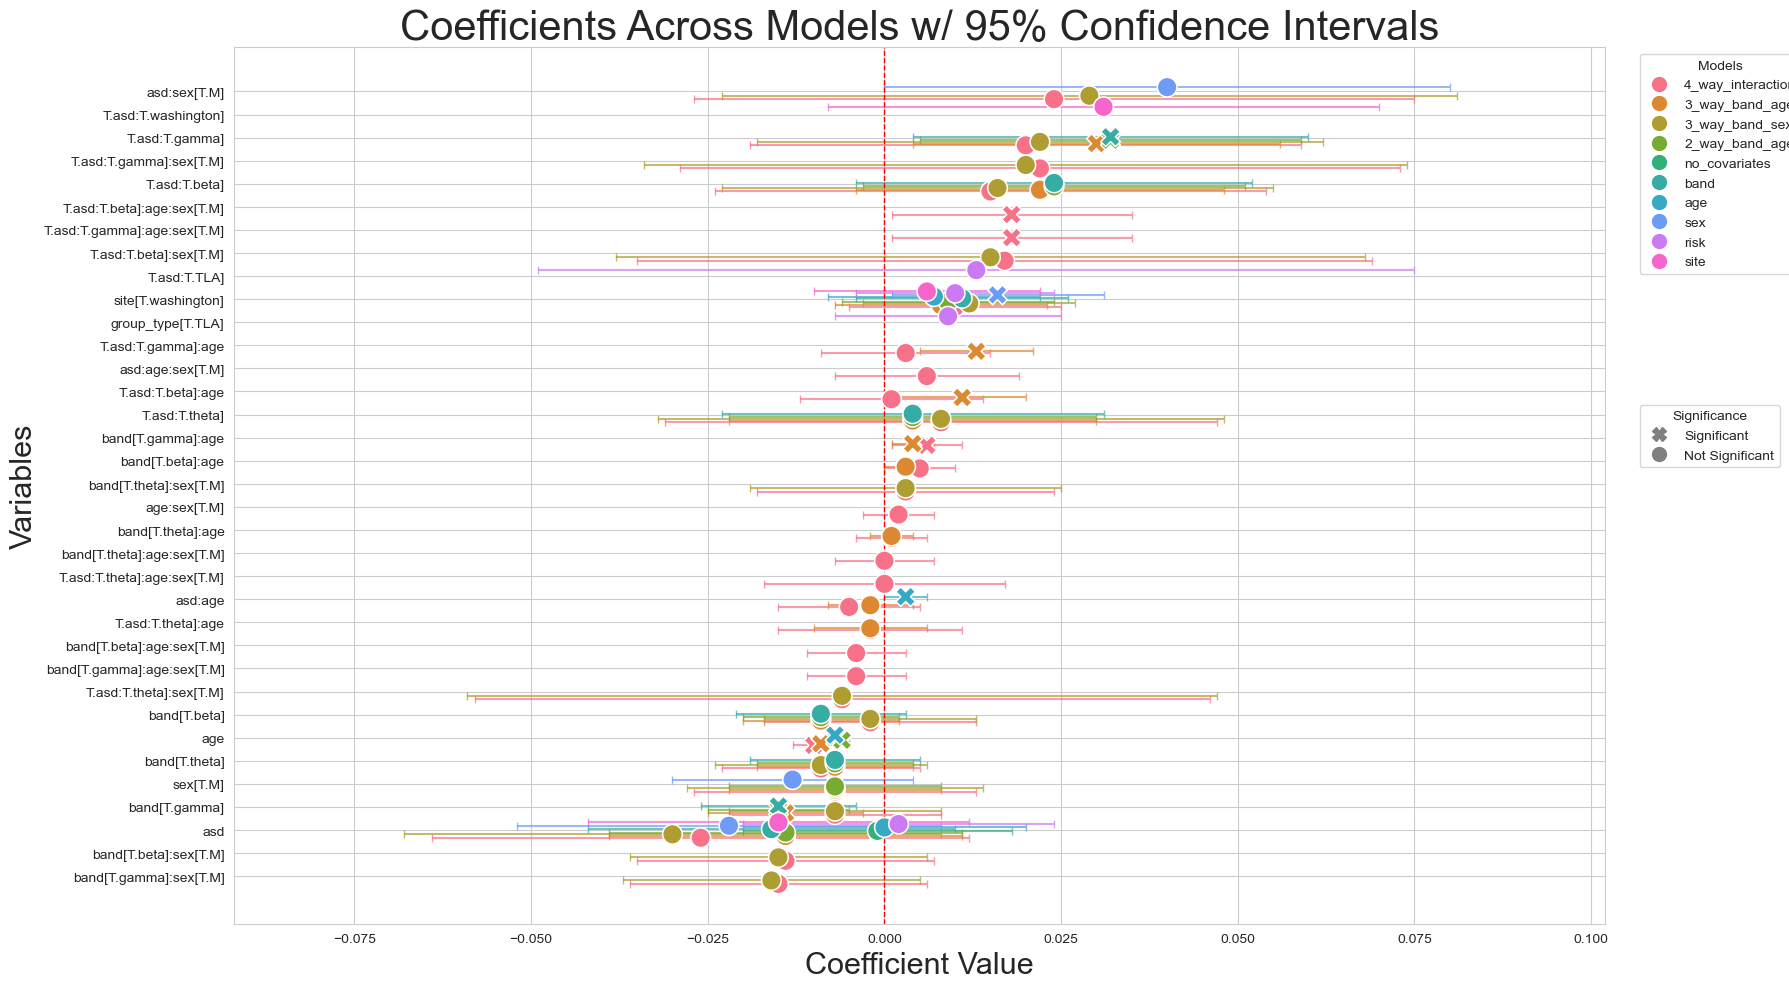

In [39]:
# Create df to be used 

models_comp= {"4_way_interaction": f"l_index ~ C({comp_var}, Treatment(reference='no-asd')) *band * age * sex + site", 
            "3_way_band_age": f"l_index ~ C({comp_var}, Treatment(reference='no-asd')) *band * age + sex  + site ", 
            "3_way_band_sex": f"l_index ~ C({comp_var}, Treatment(reference='no-asd')) *band * sex + age  + site", 
            "2_way_band_age": f"l_index ~ C({comp_var}, Treatment(reference='no-asd')) *band + age + sex  + site", 
"no_covariates": f"l_index ~ C({comp_var}, Treatment(reference='no-asd'))",
                "band": f"l_index ~ C({comp_var}, Treatment(reference='no-asd')) * band + site", 
                "age": f"l_index ~ C({comp_var}, Treatment(reference='no-asd')) * age + site", 
                "sex": f"l_index ~ C({comp_var}, Treatment(reference='no-asd')) * sex + site",
                 "risk": f"l_index ~ C({comp_var}, Treatment(reference='no-asd')) * group_type + site",
                 "site": f"l_index ~ C({comp_var}, Treatment(reference='no-asd')) * site"  }

# Append model comparisons to a list
model_comparisons_list = []

# Model to append all coefficients
model_coefficients=[]

df_name=eeg_long
df_name=df_name.loc[(df_name.age!=18) & (df_name.network=="all_regions")]

# Drop those without an outcome
df_name = df_name.dropna(subset=[comp_var])

# Mean centre the age
df_name['age'] = df_name['age'] - df_name['age'].mean()

# Do box cox transformation
df_name["l_index"] = stats.boxcox(df_name["l_index"]+ 0.33)[0]


for model_name, model_formula in models_comp.items():

    model1 = smf.mixedlm(model_formula, df_name, groups=df_name["subject"], re_formula="1").fit( reml=False)
    # Compare models
    coeff_dfs = []

    # Print the model
    print(model_name,model1.summary())

    #****** IF YOU WANT TO COMPARE MANY MODELS models = [model, model2, model3, model4, model5]
    models = [model1]

    log_likelihoods = [model.llf for model in models]
    aic = [model.aic for model in models]
    bic = [model.bic for model in models]
    converged = [model.converged for model in models]
    # Create dictionary with model names 
    model_names = ["Mix Rand-int"]

    model_comparison = pd.DataFrame({"log_likelihood": log_likelihoods, "aic": aic, "bic": bic, "converged":converged }, index=model_names)
    # Collect homoscedasticity test results
    hom_test_results = []


    for model in models:
        hom_test_df = check_homoscedasticity(model, df_name, show_text=False, co_vars=["age", "outcome", "sex", "site"])
        hom_test_results.append(hom_test_df.iloc[0])  # Assuming results are in a single row

        coeff_df = stage_model(model)
        coeff_dfs.append(coeff_df)


    # Convert list of series to a DataFrame
    hom_test_df_combined = pd.DataFrame(hom_test_results, index=model_comparison.index)

    # Merge with model comparison DataFrame
    model_comparison = pd.concat([model_comparison, hom_test_df_combined], axis=1)
    print(model_comparison)

    # Print model comparison results


    
    # Create df with all coefficients
    all_coefs = pd.concat(coeff_dfs, keys=model_names).reset_index()

    all_coefs["model_name"] = model_name
    all_coefs["model"] = model_name
    # Append all coeffts
    model_coefficients.append(all_coefs)
    model_comparisons_list.append(model_comparison)
# Create a df with all model comparisons
model_comparisons_df = pd.concat(model_comparisons_list, keys=models_comp.keys()).reset_index()
model_coefficients_df = pd.concat(model_coefficients)

model_coefficients_df.replace("C(outcome, Treatment(reference='no-asd'))[T.asd]", "asd", inplace=True)
model_coefficients_df.replace("C(outcome, Treatment(reference='no-asd'))[T.asd]:age", "asd:age", inplace=True)
model_coefficients_df.replace("C(outcome, Treatment(reference='no-asd'))[T.asd]:sex[T.M]", "asd:sex[T.M]", inplace=True)
model_coefficients_df.replace("C(outcome, Treatment(reference='no-asd'))[T.asd]:age:sex[T.M]","asd:age:sex[T.M]" ,inplace=True)

coefplot_gap(model_coefficients_df, multiple_models=True, fig_name="all_models")


# Drop unwanted columns
model_coefficients_df.drop(columns=["level_1","model_name"], inplace=True)
model_coefficients_df.rename(columns={"level_0": "model"}, inplace=True)
model_comparisons_df.drop(columns=["level_1"], inplace=True)
model_comparisons_df.rename(columns={"level_0": "model"}, inplace=True)



### **Step 4** Compare statistics for each model

#### Things to look for in a good model

#### 1. High log likelihood  
#### 2. Low aic/bic
#### 3. Pass the homoscedasticity (levene, bartlett, white and all covariates like age, outcome and sex are over 0.05)
#### 4. Pass normality of residuals (shapiro > 0.05)
#### 5. Pass Multicollinearity assumptions (below 10)

In [40]:
model_comparisons_df

model  log_likelihood          aic          bic  converged  \
0  4_way_interaction     1524.265829 -2978.531658 -2801.324972       True   
1     3_way_band_age     1505.818520 -2971.637039 -2870.376076       True   
2     3_way_band_sex     1489.691991 -2939.383982 -2838.123019       True   
3     2_way_band_age     1485.838459 -2945.676917 -2879.857291       True   
4      no_covariates     1434.122876 -2860.245753 -2839.993560       True   
5               band     1440.353506 -2858.707012 -2803.013482       True   
6                age     1481.832998 -2949.665995 -2914.224658       True   
7                sex     1437.386926 -2860.773851 -2825.332514       True   
8               risk     1436.063963 -2858.127927 -2822.686589       True   
9               site     1436.426540 -2860.853079 -2830.474790       True   

   levene_test_all    white_test  bartlett_test  shapiro_test  \
0         0.005675  9.786316e-08   2.224569e-12      0.000003   
1         0.000275  1.666577e-11   3.347966e-18      0.000008   
2         0.000170  1.847666e-12   1.968099e-26      0.000002   
3         0.000945  5.342343e-17   1.407267e-27      0.000011   
4         0.033226  7.887911e-01   1.983579e-65      0.000065   
5         0.016904  5.514155e-13   4.297473e-60      0.000096   
6         0.000854  1.271471e-10   1.870367e-29      0.000010   
7         0.034171  8.347141e-08   1.812185e-65      0.000046   
8         0.014765  3.744074e-13   2.558087e-65      0.000060   
9         0.025758  1.022176e-08   4.036825e-65      0.000062   

   multicollinearity      age  outcome      sex  site  
0          11.026689  0.34167  0.01229  0.81885   0.0  
1           4.790793  0.40090  0.15996  0.66594   0.0  
2          10.061155  0.26661  0.58719  0.57065   0.0  
3           4.003350  0.37268  0.60288  0.58029   0.0  
4           1.000000  0.65590  0.54994  0.73823   0.0  
5           4.000011  0.43073  0.72204  0.61470   0.0  
6           1.202578  0.57093  0.32573  0.64884   0.0  
7           2.631013  0.57055  0.56954  0.75034   0.0  
8           1.317307  0.64446  0.52484  0.74576   0.0  
9           2.116491  0.64752  0.49755  0.72776   0.0

In [41]:
model_comparisons_df["stage"]= "Standard"
model_comparisons_df_stages = model_comparisons_df.copy()

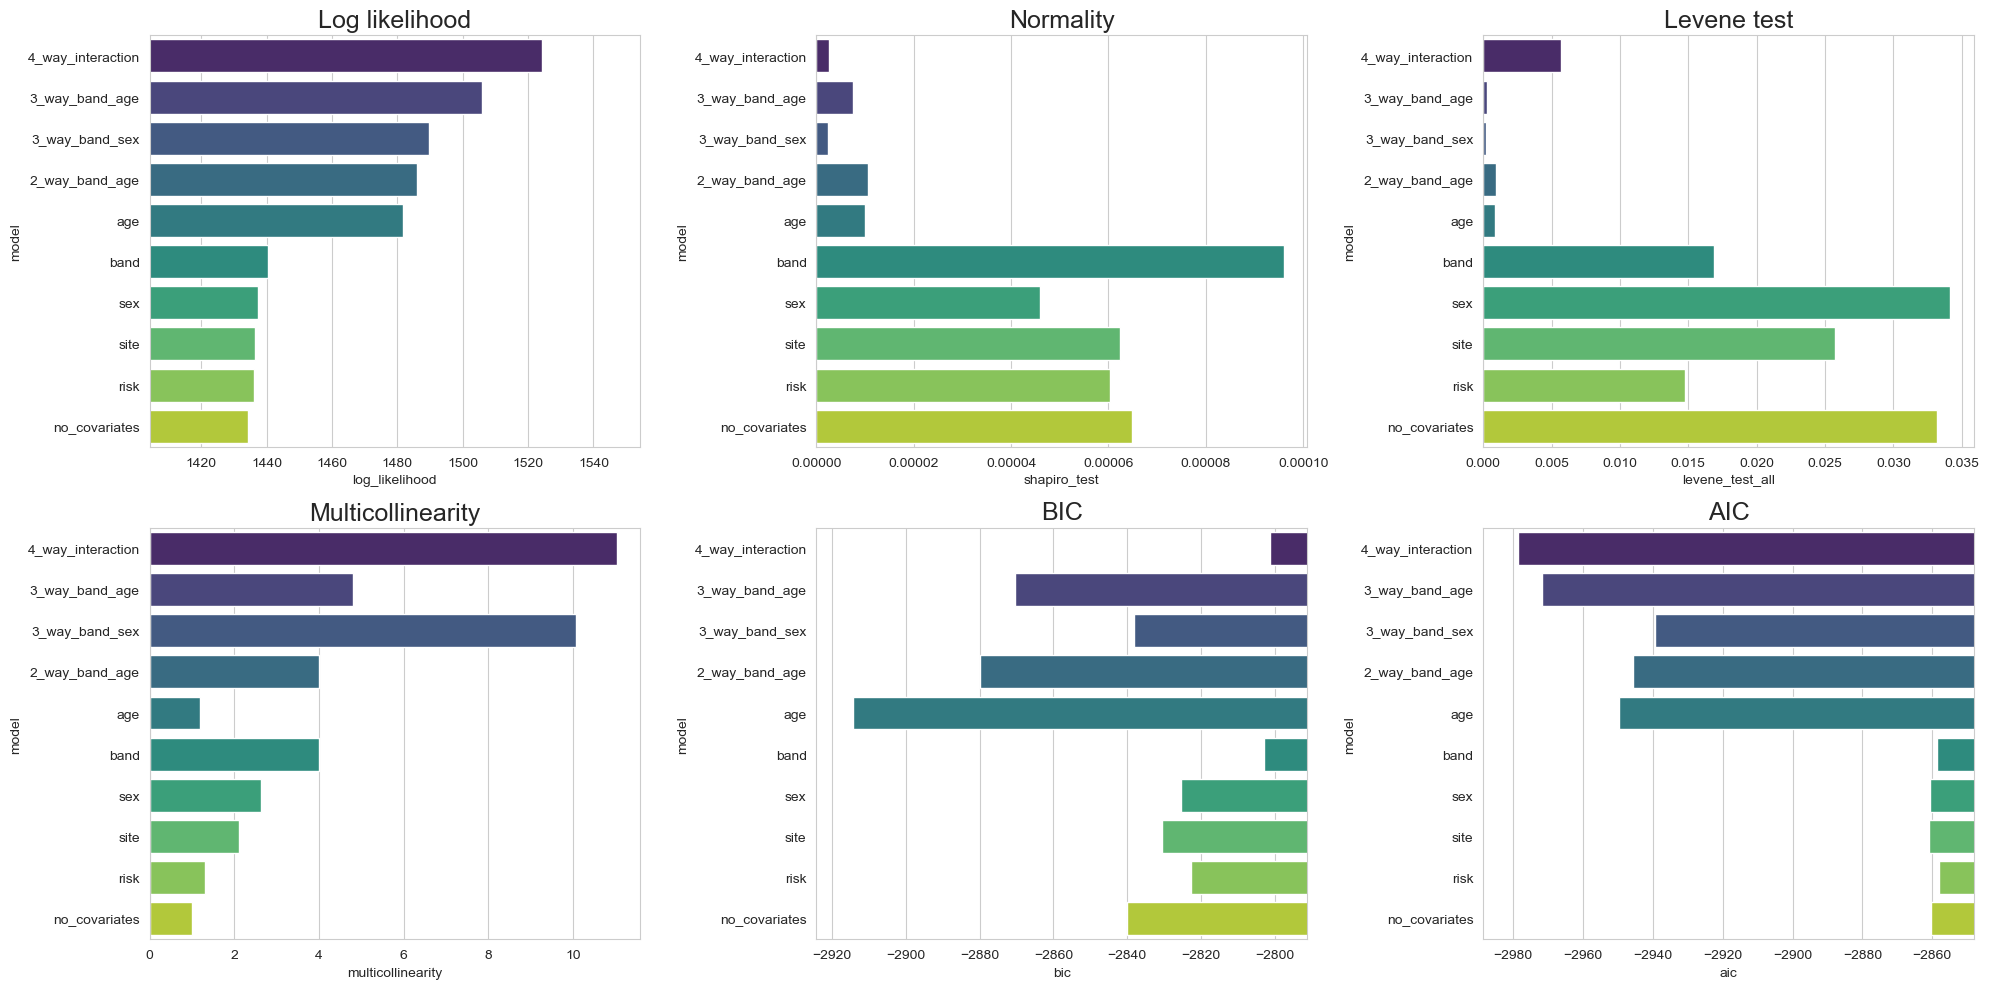

In [42]:
# Plot the different models and sort them by log likelihood

model_comparisons_df = model_comparisons_df.sort_values(by="log_likelihood", ascending=False)

# Plot
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

# Plot log likelihood
sns.barplot(x="log_likelihood", y="model", data=model_comparisons_df, ax=ax[0, 0], palette="viridis", ci=None)

# Calculate min and max of log_likelihood
log_likelihood_min = model_comparisons_df["log_likelihood"].min() - 30
log_likelihood_max = model_comparisons_df["log_likelihood"].max() + 30

# Set x-axis limits for ax[0, 0]
ax[0, 0].set_xlim(log_likelihood_min, log_likelihood_max)

# Plot Shapiro test
sns.barplot(x="shapiro_test", y="model", data=model_comparisons_df, ax=ax[0, 1], palette="viridis")

# Plot White test
sns.barplot(x="levene_test_all", y="model", data=model_comparisons_df, ax=ax[0, 2], palette="viridis")

# Plot Multicollinearity
sns.barplot(x="multicollinearity", y="model", data=model_comparisons_df, ax=ax[1, 0], palette="viridis")

# Plot BIC 
sns.barplot(x="bic", y="model", data=model_comparisons_df, ax=ax[1, 1], palette="viridis")

# Calculate min and max of BIC
bic_min = model_comparisons_df["bic"].min() - 10
bic_max = model_comparisons_df["bic"].max() + 10

# Set x-axis limits for ax[1, 1]
ax[1, 1].set_xlim(bic_min, bic_max)


# Plot AIC
sns.barplot(x="aic", y="model", data=model_comparisons_df, ax=ax[1, 2], palette="viridis")

# Calculate min and max of AIC
aic_min = model_comparisons_df["aic"].min() - 10
aic_max = model_comparisons_df["aic"].max() + 10

# Set x-axis limits for ax[1, 2]
ax[1, 2].set_xlim(aic_min, aic_max)

# Add titles
ax[0, 0].set_title("Log likelihood", fontsize=18)
ax[0, 1].set_title("Normality", fontsize=18)
ax[0, 2].set_title("Levene test", fontsize=18)
ax[1, 0].set_title("Multicollinearity", fontsize=18)
ax[1, 1].set_title("BIC", fontsize=18)
ax[1, 2].set_title("AIC", fontsize=18)

# Change x-axis limits for the log likelihood plot
# ax[0, 0].set_xlim(1330, 1405)

plt.tight_layout()
plt.show()

##### **Preliminary interpretation** : 4 way interaction (high multicollinaraity), 2 way band age (levene) and age 

C:\Users\gabot\AppData\Local\Temp\ipykernel_5592\1835281196.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df["group"] = plot_df["outcome"] + "_" + plot_df["site"]


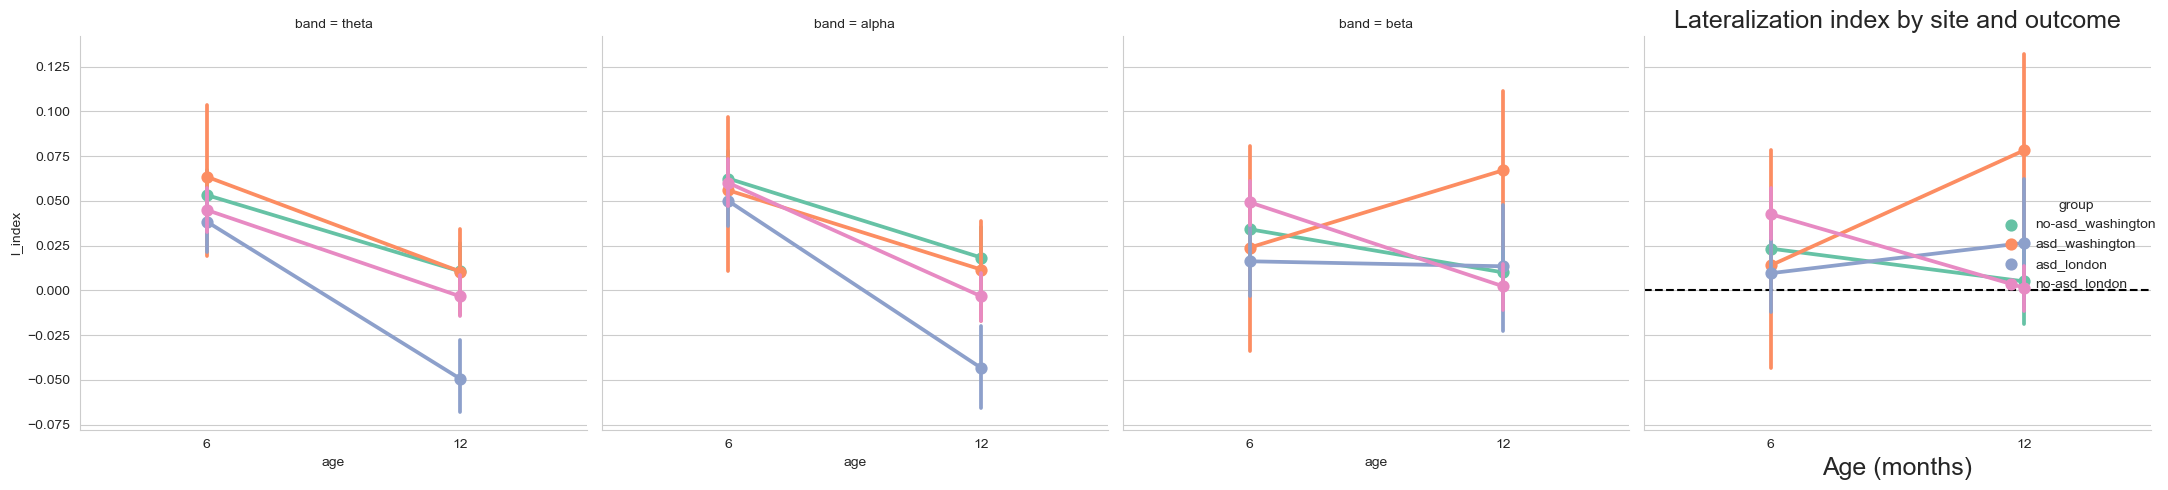

In [44]:
# Plot changes in lateralization as a function of age, asd and site
plot_df= eeg_long.loc[(eeg_long.age!=18) & (eeg_long.network=="all_regions")]


plot_df["group"] = plot_df["outcome"] + "_" + plot_df["site"]

# Plot site differences for each band 
sns.set_style('whitegrid')

g= sns.catplot(x="age",y="l_index", ci=90,hue="group",palette="Set2",data=plot_df,col="band", kind="point")

#sns.lineplot(x="age", y="l_index", data=plot_df, hue="group", style="outcome", palette="viridis")

plt.title("Lateralization index by site and outcome", fontsize=18)
plt.xlabel("Age (months)", fontsize=18)

plt.ylabel("Lateralization index", fontsize=18)

# Add line at 0
plt.axhline(0, color='black', linestyle='--')

plt.tight_layout()
plt.show()


##### **Preliminary interpretation** : Children with ASD seem to increase their laterlization with age in beta and gamma bands

### **Step 5** Reassess the models, drop uselles ones and update variables (Site was never signifcant so it can be removed)

c:\Users\gabot\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


4_way_interaction                                          Mixed Linear Model Regression Results
Model:                                  MixedLM                      Dependent Variable:                      l_index  
No. Observations:                       1168                         Method:                                  ML       
No. Groups:                             175                          Scale:                                   0.0034   
Min. group size:                        4                            Log-Likelihood:                          1523.3854
Max. group size:                        8                            Converged:                               Yes      
Mean group size:                        6.7                                                                            
-----------------------------------------------------------------------------------------------------------------------
                                                               

c:\Users\gabot\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


2_way_band_age                                    Mixed Linear Model Regression Results
Model:                              MixedLM                  Dependent Variable:                  l_index  
No. Observations:                   1168                     Method:                              ML       
No. Groups:                         175                      Scale:                               0.0037   
Min. group size:                    4                        Log-Likelihood:                      1484.9801
Max. group size:                    8                        Converged:                           Yes      
Mean group size:                    6.7                                                                    
-----------------------------------------------------------------------------------------------------------
                                                               Coef.  Std.Err.    z     P>|z| [0.025 0.975]
------------------------------------------------

c:\Users\gabot\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


age                               Mixed Linear Model Regression Results
Model:                          MixedLM               Dependent Variable:               l_index  
No. Observations:               1168                  Method:                           ML       
No. Groups:                     175                   Scale:                            0.0037   
Min. group size:                4                     Log-Likelihood:                   1481.3841
Max. group size:                8                     Converged:                        Yes      
Mean group size:                6.7                                                              
-------------------------------------------------------------------------------------------------
                                                     Coef.  Std.Err.    z     P>|z| [0.025 0.975]
-------------------------------------------------------------------------------------------------
Intercept                                     

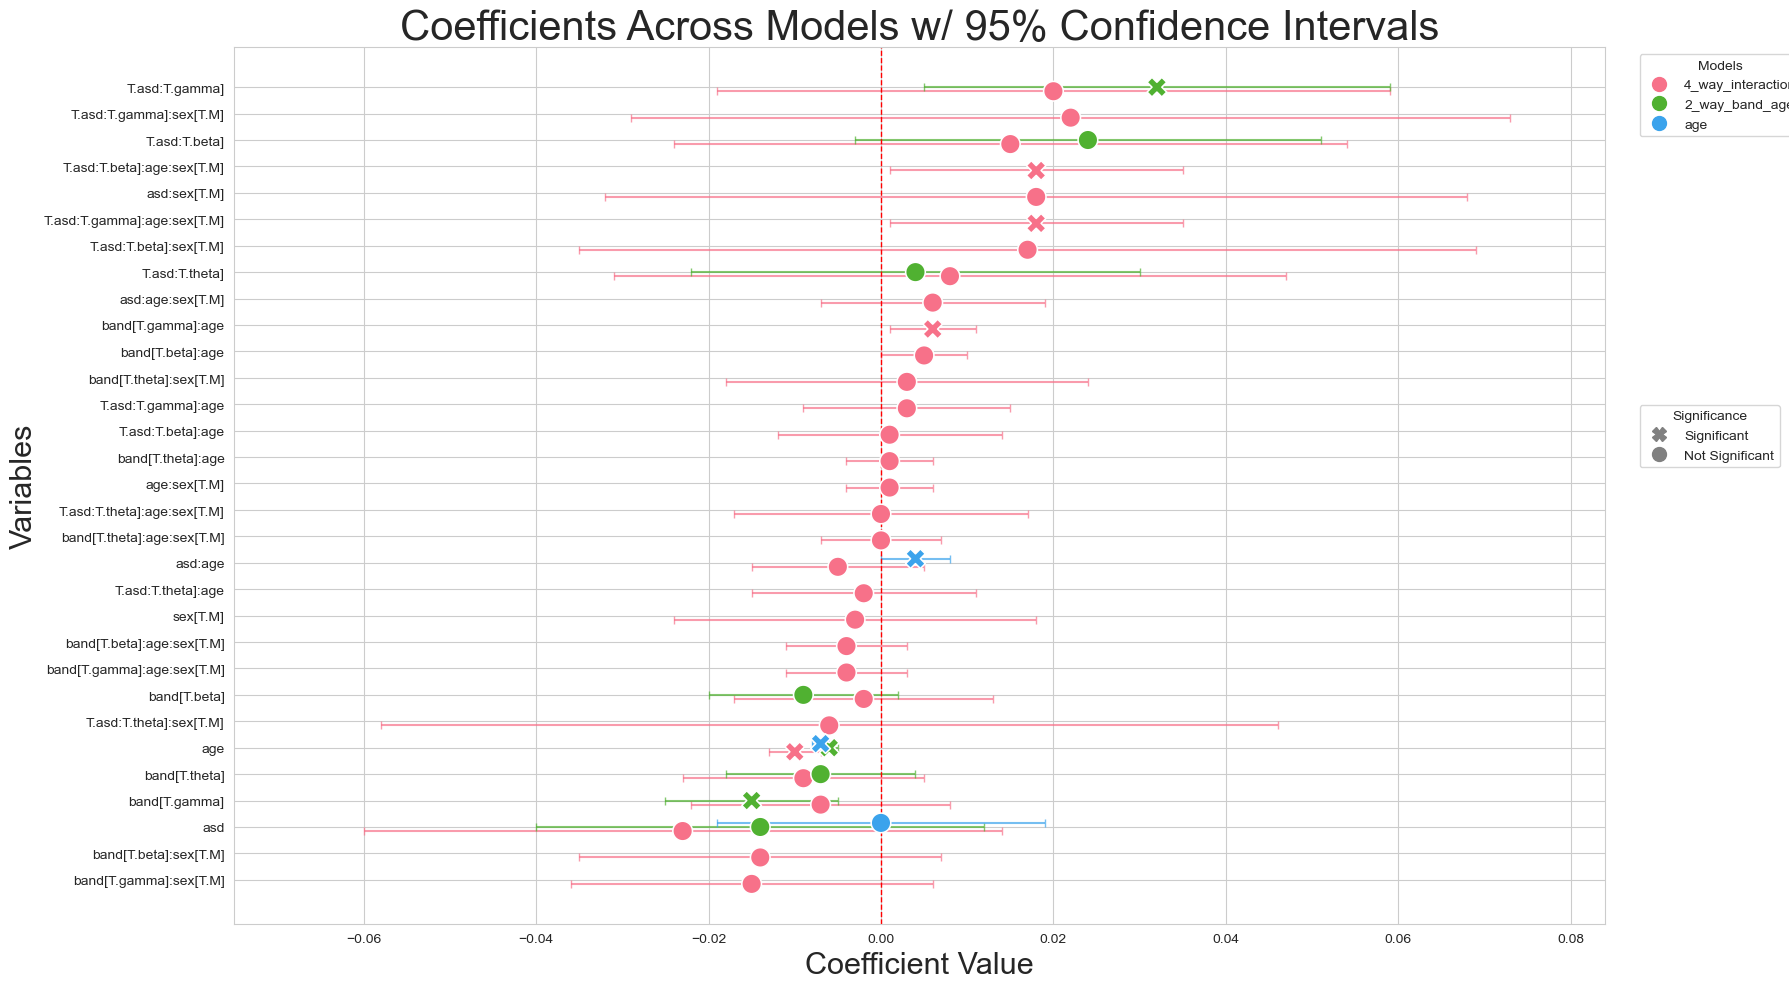

In [45]:
# Create df to be used 

models_comp= {"4_way_interaction": f"l_index ~ C({comp_var}, Treatment(reference='no-asd')) *band * age * sex ", 
            #"3_way_band_age": f"l_index ~ C({comp_var}, Treatment(reference='no-asd')) * band * age", 
           # "3_way_band_age+sex": f"l_index ~ C({comp_var}, Treatment(reference='no-asd')) * band * age + sex", 

            "2_way_band_age": f"l_index ~ C({comp_var}, Treatment(reference='no-asd')) * band + age ", 
                "age": f"l_index ~ C({comp_var}, Treatment(reference='no-asd')) * age" }

# Append model comparisons to a list
model_comparisons_list = []

# Model to append all coefficients
model_coefficients=[]

df_name=eeg_long
df_name=df_name.loc[(df_name.age!=18) & (df_name.network=="all_regions")]

# Drop those without an outcome
df_name = df_name.dropna(subset=[comp_var])

# Mean centre the age
df_name['age'] = df_name['age'] - df_name['age'].mean()

# Check if dependent variable is normally distributed
shapiro_test = stats.shapiro(df_name["l_index"])

# Do box cox transformation
df_name["l_index"] = stats.boxcox(df_name["l_index"]+ 0.33)[0]


for model_name, model_formula in models_comp.items():

    model1 = smf.mixedlm(model_formula, df_name, groups=df_name["subject"], re_formula="1").fit( reml=False)
    # Compare models
    coeff_dfs = []

    # Print the model
    print(model_name,model1.summary())

    #****** IF YOU WANT TO COMPARE MANY MODELS models = [model, model2, model3, model4, model5]
    models = [model1]

    log_likelihoods = [model.llf for model in models]
    aic = [model.aic for model in models]
    bic = [model.bic for model in models]
    converged = [model.converged for model in models]
    # Create dictionary with model names 
    model_names = ["Mix Rand-int"]

    model_comparison = pd.DataFrame({"log_likelihood": log_likelihoods, "aic": aic, "bic": bic, "converged":converged }, index=model_names)
    # Collect homoscedasticity test results
    hom_test_results = []


    for model in models:
        hom_test_df = check_homoscedasticity(model, df_name, show_text=False, co_vars=["age", "outcome", "sex", "site"])
        hom_test_results.append(hom_test_df.iloc[0])  # Assuming results are in a single row

        coeff_df = stage_model(model)
        coeff_dfs.append(coeff_df)


    # Convert list of series to a DataFrame
    hom_test_df_combined = pd.DataFrame(hom_test_results, index=model_comparison.index)

    # Merge with model comparison DataFrame
    model_comparison = pd.concat([model_comparison, hom_test_df_combined], axis=1)
    print(model_comparison)

    # Print model comparison results


    
    # Create df with all coefficients
    all_coefs = pd.concat(coeff_dfs, keys=model_names).reset_index()

    all_coefs["model_name"] = model_name
    all_coefs["model"] = model_name
    # Append all coeffts
    model_coefficients.append(all_coefs)
    model_comparisons_list.append(model_comparison)
# Create a df with all model comparisons
model_comparisons_df = pd.concat(model_comparisons_list, keys=models_comp.keys()).reset_index()
model_coefficients_df = pd.concat(model_coefficients)

model_coefficients_df.replace("C(outcome, Treatment(reference='no-asd'))[T.asd]", "asd", inplace=True)
model_coefficients_df.replace("C(outcome, Treatment(reference='no-asd'))[T.asd]:age", "asd:age", inplace=True)
model_coefficients_df.replace("C(outcome, Treatment(reference='no-asd'))[T.asd]:sex[T.M]", "asd:sex[T.M]", inplace=True)
model_coefficients_df.replace("C(outcome, Treatment(reference='no-asd'))[T.asd]:age:sex[T.M]","asd:age:sex[T.M]" ,inplace=True)

coefplot_gap(model_coefficients_df, multiple_models=True, fig_name="all_models")


# Drop unwanted columns
model_coefficients_df.drop(columns=["level_1","model_name"], inplace=True)
model_coefficients_df.rename(columns={"level_0": "model"}, inplace=True)
model_comparisons_df.drop(columns=["level_1"], inplace=True)
model_comparisons_df.rename(columns={"level_0": "model"}, inplace=True)



In [46]:
model_comparisons_df

model  log_likelihood          aic          bic  converged  \
0  4_way_interaction     1523.385364 -2978.770728 -2806.627090       True   
1     2_way_band_age     1484.980142 -2947.960284 -2892.266754       True   
2                age     1481.384134 -2950.768268 -2920.389979       True   

   levene_test_all  white_test  bartlett_test  shapiro_test  \
0         0.017539    0.000538   2.512315e-12      0.000003   
1         0.000750    0.000022   1.713385e-27      0.000012   
2         0.003742    0.635043   1.977892e-29      0.000011   

   multicollinearity      age  outcome      sex  site  
0          11.015137  0.39342  0.01290  0.83001   0.0  
1           4.000352  0.37902  0.60302  0.57471   0.0  
2           1.197360  0.60068  0.33215  0.63696   0.0

In [47]:
model_comparisons_df["stage"]= "no_site"

In [48]:
# Megerge all stages
model_comparisons_df_stages = pd.concat([model_comparisons_df, model_comparisons_df_stages], axis=0)

In [49]:
model_comparisons_df_stages

model  log_likelihood          aic          bic  converged  \
0  4_way_interaction     1523.385364 -2978.770728 -2806.627090       True   
1     2_way_band_age     1484.980142 -2947.960284 -2892.266754       True   
2                age     1481.384134 -2950.768268 -2920.389979       True   
0  4_way_interaction     1524.265829 -2978.531658 -2801.324972       True   
1     3_way_band_age     1505.818520 -2971.637039 -2870.376076       True   
2     3_way_band_sex     1489.691991 -2939.383982 -2838.123019       True   
3     2_way_band_age     1485.838459 -2945.676917 -2879.857291       True   
4      no_covariates     1434.122876 -2860.245753 -2839.993560       True   
5               band     1440.353506 -2858.707012 -2803.013482       True   
6                age     1481.832998 -2949.665995 -2914.224658       True   
7                sex     1437.386926 -2860.773851 -2825.332514       True   
8               risk     1436.063963 -2858.127927 -2822.686589       True   
9               site     1436.426540 -2860.853079 -2830.474790       True   

   levene_test_all    white_test  bartlett_test  shapiro_test  \
0         0.017539  5.380329e-04   2.512315e-12      0.000003   
1         0.000750  2.168656e-05   1.713385e-27      0.000012   
2         0.003742  6.350430e-01   1.977892e-29      0.000011   
0         0.005675  9.786316e-08   2.224569e-12      0.000003   
1         0.000275  1.666577e-11   3.347966e-18      0.000008   
2         0.000170  1.847666e-12   1.968099e-26      0.000002   
3         0.000945  5.342343e-17   1.407267e-27      0.000011   
4         0.033226  7.887911e-01   1.983579e-65      0.000065   
5         0.016904  5.514155e-13   4.297473e-60      0.000096   
6         0.000854  1.271471e-10   1.870367e-29      0.000010   
7         0.034171  8.347141e-08   1.812185e-65      0.000046   
8         0.014765  3.744074e-13   2.558087e-65      0.000060   
9         0.025758  1.022176e-08   4.036825e-65      0.000062   

   multicollinearity      age  outcome      sex  site     stage  
0          11.015137  0.39342  0.01290  0.83001   0.0   no_site  
1           4.000352  0.37902  0.60302  0.57471   0.0   no_site  
2           1.197360  0.60068  0.33215  0.63696   0.0   no_site  
0          11.026689  0.34167  0.01229  0.81885   0.0  Standard  
1           4.790793  0.40090  0.15996  0.66594   0.0  Standard  
2          10.061155  0.26661  0.58719  0.57065   0.0  Standard  
3           4.003350  0.37268  0.60288  0.58029   0.0  Standard  
4           1.000000  0.65590  0.54994  0.73823   0.0  Standard  
5           4.000011  0.43073  0.72204  0.61470   0.0  Standard  
6           1.202578  0.57093  0.32573  0.64884   0.0  Standard  
7           2.631013  0.57055  0.56954  0.75034   0.0  Standard  
8           1.317307  0.64446  0.52484  0.74576   0.0  Standard  
9           2.116491  0.64752  0.49755  0.72776   0.0  Standard

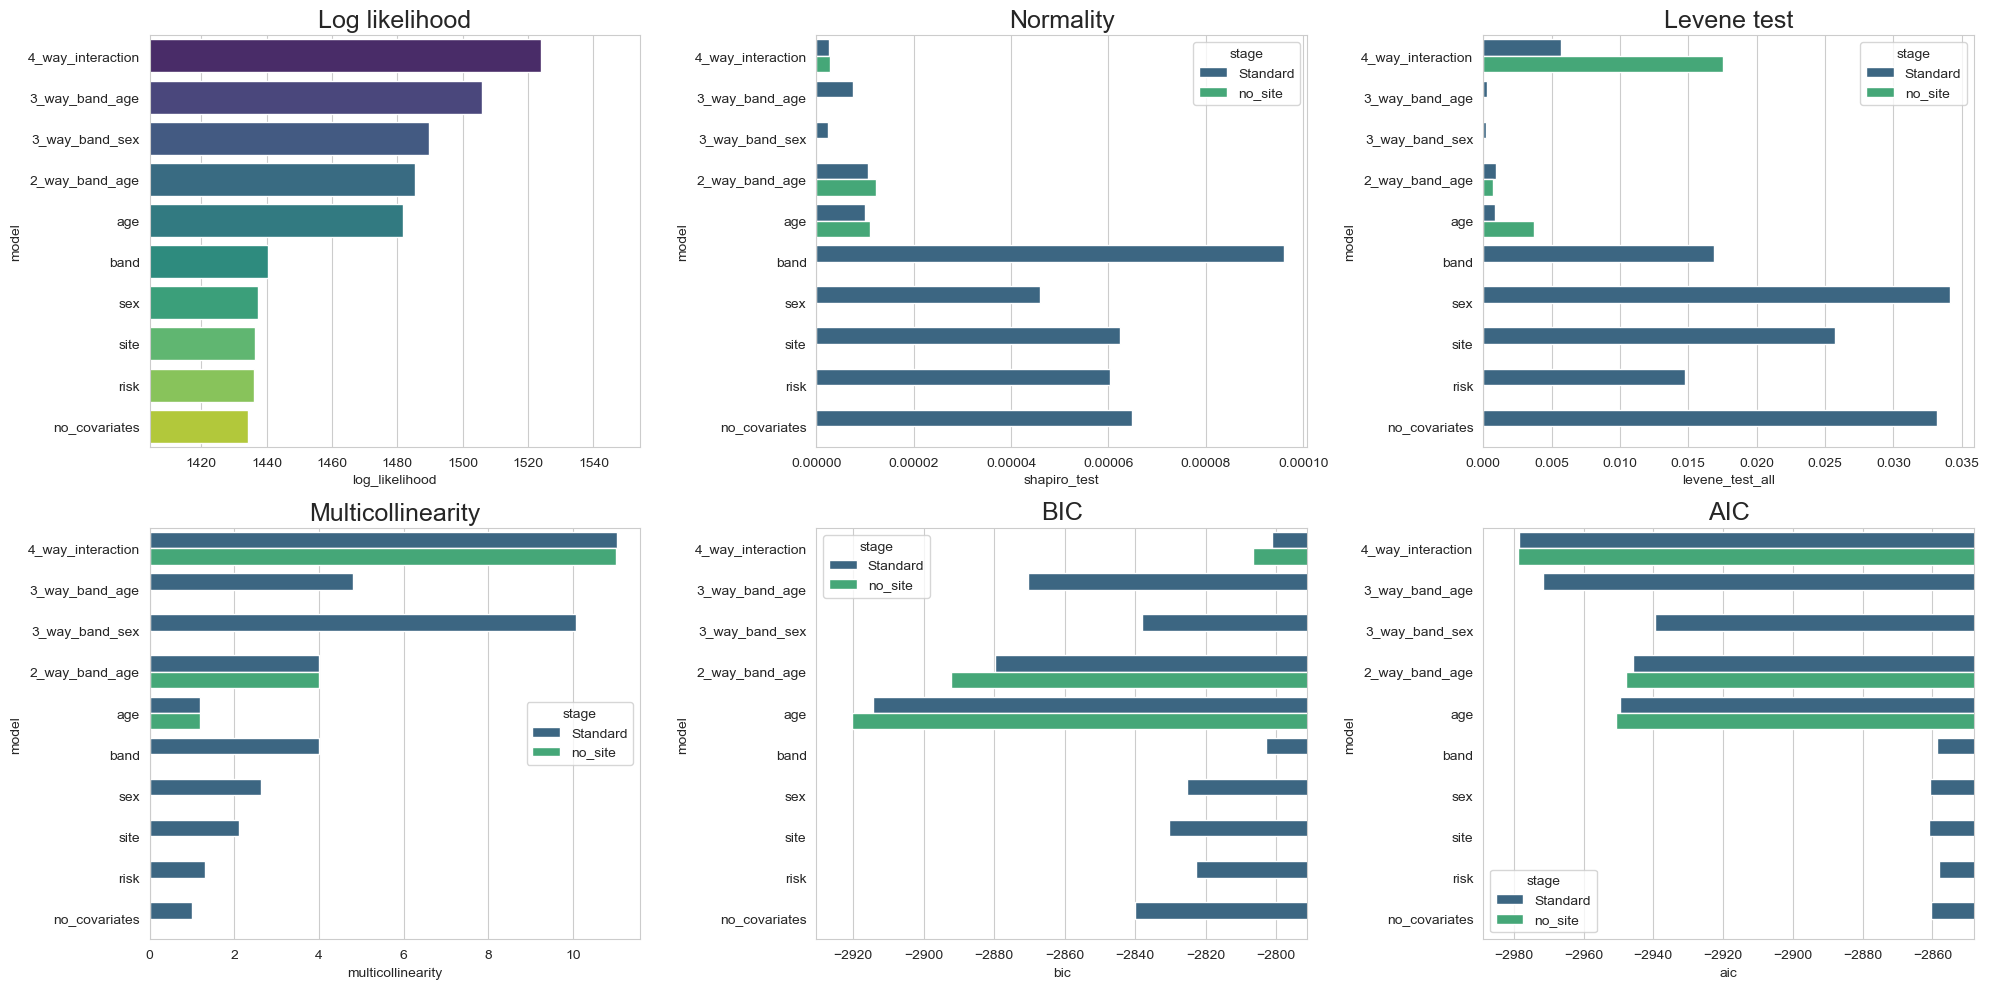

In [50]:
# Plot the different models and sort them by log likelihood

model_comparisons_df_stages = model_comparisons_df_stages.sort_values(by="log_likelihood", ascending=False)

# Plot
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

# Plot log likelihood
sns.barplot(x="log_likelihood", y="model", data=model_comparisons_df_stages, ax=ax[0, 0], palette="viridis", ci=None)

# Calculate min and max of log_likelihood
log_likelihood_min = model_comparisons_df_stages["log_likelihood"].min() - 30
log_likelihood_max = model_comparisons_df_stages["log_likelihood"].max() + 30

# Set x-axis limits for ax[0, 0]
ax[0, 0].set_xlim(log_likelihood_min, log_likelihood_max)

# Plot Shapiro test
sns.barplot(x="shapiro_test", y="model", data=model_comparisons_df_stages, ax=ax[0, 1], palette="viridis", hue="stage")

# Plot White test
sns.barplot(x="levene_test_all", y="model", data=model_comparisons_df_stages, ax=ax[0, 2], palette="viridis", hue="stage")

# Plot Multicollinearity
sns.barplot(x="multicollinearity", y="model", data=model_comparisons_df_stages, ax=ax[1, 0], palette="viridis", hue="stage")

# Plot BIC 
sns.barplot(x="bic", y="model", data=model_comparisons_df_stages, ax=ax[1, 1], palette="viridis", hue="stage")

# Calculate min and max of BIC
bic_min = model_comparisons_df_stages["bic"].min() - 10
bic_max = model_comparisons_df_stages["bic"].max() + 10

# Set x-axis limits for ax[1, 1]
ax[1, 1].set_xlim(bic_min, bic_max)


# Plot AIC
sns.barplot(x="aic", y="model", data=model_comparisons_df_stages, ax=ax[1, 2], palette="viridis", hue="stage")

# Calculate min and max of AIC
aic_min = model_comparisons_df_stages["aic"].min() - 10
aic_max = model_comparisons_df_stages["aic"].max() + 10

# Set x-axis limits for ax[1, 2]
ax[1, 2].set_xlim(aic_min, aic_max)

# Add titles
ax[0, 0].set_title("Log likelihood", fontsize=18)
ax[0, 1].set_title("Normality", fontsize=18)
ax[0, 2].set_title("Levene test", fontsize=18)
ax[1, 0].set_title("Multicollinearity", fontsize=18)
ax[1, 1].set_title("BIC", fontsize=18)
ax[1, 2].set_title("AIC", fontsize=18)

# Change x-axis limits for the log likelihood plot
# ax[0, 0].set_xlim(1330, 1405)

plt.tight_layout()
plt.show()

##### **Preliminary interpretation** : Site removal has improved the model, now it seems to be like age and band are the best models (band is better because less multicollinearity)

### **Step 6** Test if there is a big difference between your top two models

In [52]:
# Create df to be used 


# Create df to be used
df_name=eeg_long
df_name=df_name.loc[(df_name.age!=18) & (df_name.network=="all_regions")]

# Drop those without an outcome
df_name = df_name.dropna(subset=[comp_var])

# Check if dependent variable is normally distributed
shapiro_test = stats.shapiro(df_name["l_index"])

# Do box cox transformation
df_name["l_index"] = stats.boxcox(df_name["l_index"]+ 0.33)[0]

# Mean center the age
df_name['age'] = df_name['age'] - df_name['age'].mean()

# Model 1: 4 way interaction model
model1 = smf.mixedlm(f"l_index ~ C({comp_var}, Treatment(reference='no-asd')) * age * band * sex",
                      df_name, groups=df_name["subject"], re_formula="1").fit()

# Model 2: 3 way interaction model with age 
model2 = smf.mixedlm( f"l_index ~ C({comp_var}, Treatment(reference='no-asd')) * age * band", 
                        df_name, groups=df_name["subject"], re_formula="1").fit()


# Log-likelihoods for both models
ll_three_way = model1.llf  # Log-likelihood of 3-way interaction model
ll_two_way = model2.llf  # Log-likelihood of 2-way interaction model

# Likelihood ratio test statistic
lr_stat = 2 * (ll_three_way - ll_two_way)

# Degrees of freedom (number of random effects added in mixed model)
df_diff = 1

# Calculate p-value
p_value = chi2.sf(lr_stat, df_diff)

print(f"Likelihood Ratio Test Statistic: {lr_stat:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("one model is better")
else:
    print("they are all the same")

# Show which model is better
print(f"Model 1: Three way log-likelihood: {ll_three_way:.4f}")
print(f"Model 2: Two way log-likelihood: {ll_two_way:.4f}")


c:\Users\gabot\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Likelihood Ratio Test Statistic: -91.5096
P-value: 1.0000
they are all the same
Model 1: Three way log-likelihood: 1384.3424
Model 2: Two way log-likelihood: 1430.0972


c:\Users\gabot\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


##### **Preliminary interpretation** : 4 way interaction and 2_way_band are not statistically different. Since age has higher multicollinearity and we are interested in bands, we will choose the band model

### **Step 7** Assess model assumptions for your best model and if necessary, try different alternatives

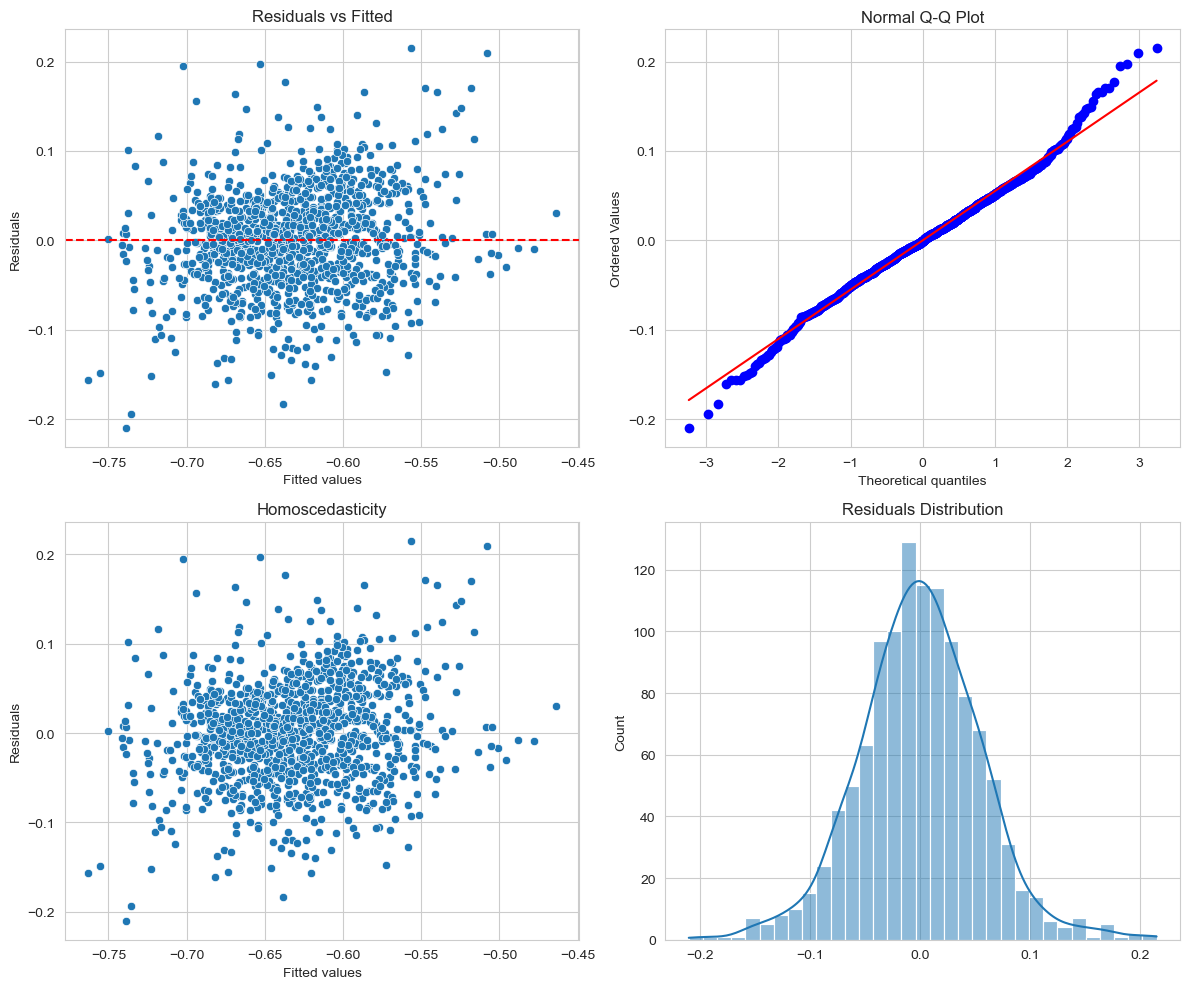

Shapiro-Wilk test p-value: 2.844374876076472e-06
Residuals are not homoscedastic LeveneResult(statistic=3.386623097482019, pvalue=0.01757213700090853)
Bartlett’s test p-value: 2.045302720896223e-12
White test p-value: 0.0005390953951276579
Levene’s test p-value for the whole model: 0.01757213700090853
Levene’s test p-value for variable age: 0.39553192545183236
Levene’s test p-value for variable sex: 0.8291952849692041
Levene’s test p-value for variable outcome: 0.01297246631365865
Levene’s test p-value for variable band: 0.04471020478171352
Homoscedasticiyy checked


'Assumptions checked'

In [53]:
# Check model assupmtions
check_assumptions(model1, df_name, show_plots=True, show_text=True, covariates=["age", "sex", "outcome", "band"])

In [54]:
# Check for multicollinearity
vif = pd.DataFrame()
vif["variables"] = model1.model.exog_names
# Drop the intercept
vif["VIF"] = [variance_inflation_factor(model1.model.exog, i) for i in range(model1.model.exog.shape[1])]
vif = vif.loc[vif["variables"] != "Intercept"]
vif.replace("C(outcome, Treatment(reference='no-asd'))[T.asd]", "asd", inplace=True)
vif.replace("C(outcome, Treatment(reference='no-asd'))[T.asd]:age", "asd:age", inplace=True)
vif.replace("C(outcome, Treatment(reference='no-asd'))[T.asd]:sex[T.M]", "asd:sex[T.M]", inplace=True)
vif.replace("C(outcome, Treatment(reference='no-asd'))[T.asd]:age:sex[T.M]","asd:age:sex[T.M]" ,inplace=True)
vif

variables        VIF
1                                                 asd   9.015254
2                                        band[T.beta]   3.534204
3                                       band[T.gamma]   3.534204
4                                       band[T.theta]   3.534204
5                                            sex[T.M]   4.793354
6   C(outcome, Treatment(reference='no-asd'))[T.as...   5.172687
7   C(outcome, Treatment(reference='no-asd'))[T.as...   5.172687
8   C(outcome, Treatment(reference='no-asd'))[T.as...   5.172687
9                                        asd:sex[T.M]   9.955883
10                              band[T.beta]:sex[T.M]   4.218978
11                             band[T.gamma]:sex[T.M]   4.218978
12                             band[T.theta]:sex[T.M]   4.218978
13  C(outcome, Treatment(reference='no-asd'))[T.as...   5.358331
14  C(outcome, Treatment(reference='no-asd'))[T.as...   5.358331
15  C(outcome, Treatment(reference='no-asd'))[T.as...   5.358331
16                                                age   9.442751
17                                            asd:age  10.828811
18                                   age:band[T.beta]   4.721375
19                                  age:band[T.gamma]   4.721375
20                                  age:band[T.theta]   4.721375
21                                       age:sex[T.M]   9.666951
22  C(outcome, Treatment(reference='no-asd'))[T.as...   5.415603
23  C(outcome, Treatment(reference='no-asd'))[T.as...   5.415603
24  C(outcome, Treatment(reference='no-asd'))[T.as...   5.415603
25                                   asd:age:sex[T.M]  11.015137
26                          age:band[T.beta]:sex[T.M]   4.835620
27                         age:band[T.gamma]:sex[T.M]   4.835620
28                         age:band[T.theta]:sex[T.M]   4.835620
29  C(outcome, Treatment(reference='no-asd'))[T.as...   5.507575
30  C(outcome, Treatment(reference='no-asd'))[T.as...   5.507575
31  C(outcome, Treatment(reference='no-asd'))[T.as...   5.507575

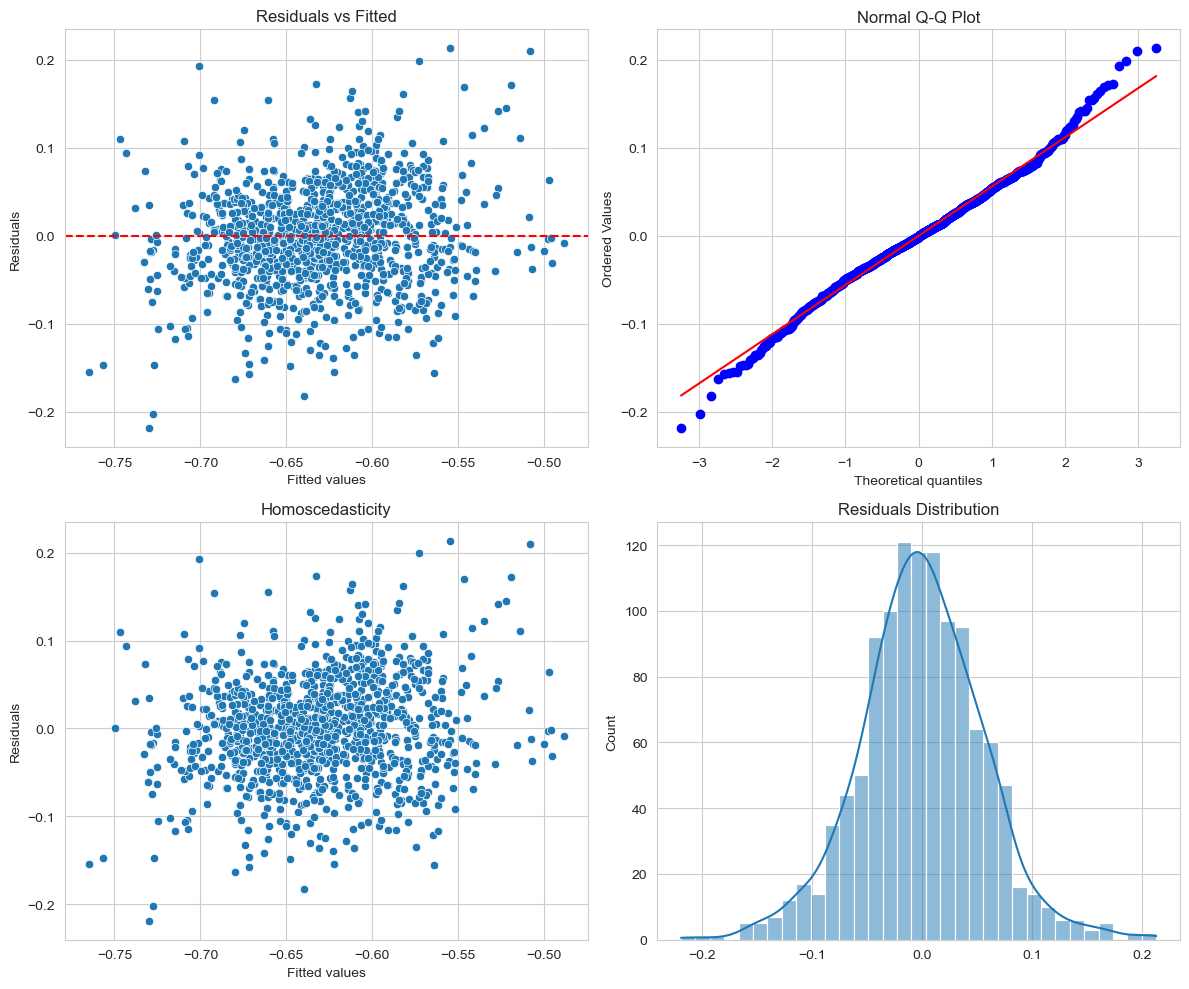

Shapiro-Wilk test p-value: 8.464694474241696e-06
Residuals are not homoscedastic LeveneResult(statistic=5.767663707567157, pvalue=0.0006480556133109319)
Bartlett’s test p-value: 3.4211179780525903e-18
White test p-value: 0.00019418168066745272
Levene’s test p-value for the whole model: 0.0006480556133109319
Levene’s test p-value for variable age: 0.41809083450030937
Levene’s test p-value for variable sex: 0.6756797431530316
Levene’s test p-value for variable outcome: 0.1628672918973392
Levene’s test p-value for variable band: 0.04707117918952147
Homoscedasticiyy checked


'Assumptions checked'

In [55]:
# Check model assupmtions for the age only model 

check_assumptions(model2, df_name, show_plots=True, show_text=True, covariates=["age", "sex", "outcome","band"])

In [56]:
# Check for multicollinearity
vif = pd.DataFrame()
vif["variables"] = model2.model.exog_names
# Drop the intercept
vif["VIF"] = [variance_inflation_factor(model2.model.exog, i) for i in range(model2.model.exog.shape[1])]
vif = vif.loc[vif["variables"] != "Intercept"]
vif.replace("C(outcome, Treatment(reference='no-asd'))[T.asd]", "asd", inplace=True)
vif.replace("C(outcome, Treatment(reference='no-asd'))[T.asd]:age", "asd:age", inplace=True)
vif.replace("C(outcome, Treatment(reference='no-asd'))[T.asd]:sex[T.M]", "asd:sex[T.M]", inplace=True)
vif.replace("C(outcome, Treatment(reference='no-asd'))[T.asd]:age:sex[T.M]","asd:age:sex[T.M]" ,inplace=True)
vif

variables       VIF
1                                                 asd  4.006050
2                                        band[T.beta]  1.795206
3                                       band[T.gamma]  1.795206
4                                       band[T.theta]  1.795206
5   C(outcome, Treatment(reference='no-asd'))[T.as...  2.298553
6   C(outcome, Treatment(reference='no-asd'))[T.as...  2.298553
7   C(outcome, Treatment(reference='no-asd'))[T.as...  2.298553
8                                                 age  4.783943
9                                             asd:age  4.789441
10                                   age:band[T.beta]  2.391972
11                                  age:band[T.gamma]  2.391972
12                                  age:band[T.theta]  2.391972
13  C(outcome, Treatment(reference='no-asd'))[T.as...  2.395250
14  C(outcome, Treatment(reference='no-asd'))[T.as...  2.395250
15  C(outcome, Treatment(reference='no-asd'))[T.as...  2.395250

##### **Preliminary interpretation** : Nomality is okay (Failed shapiro test but it looks normal), homoscedasticity is okay, multicollinearity is an issue in the first model but not on the second. 

### **Step 10** Print your best model and interpret

c:\Users\gabot\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


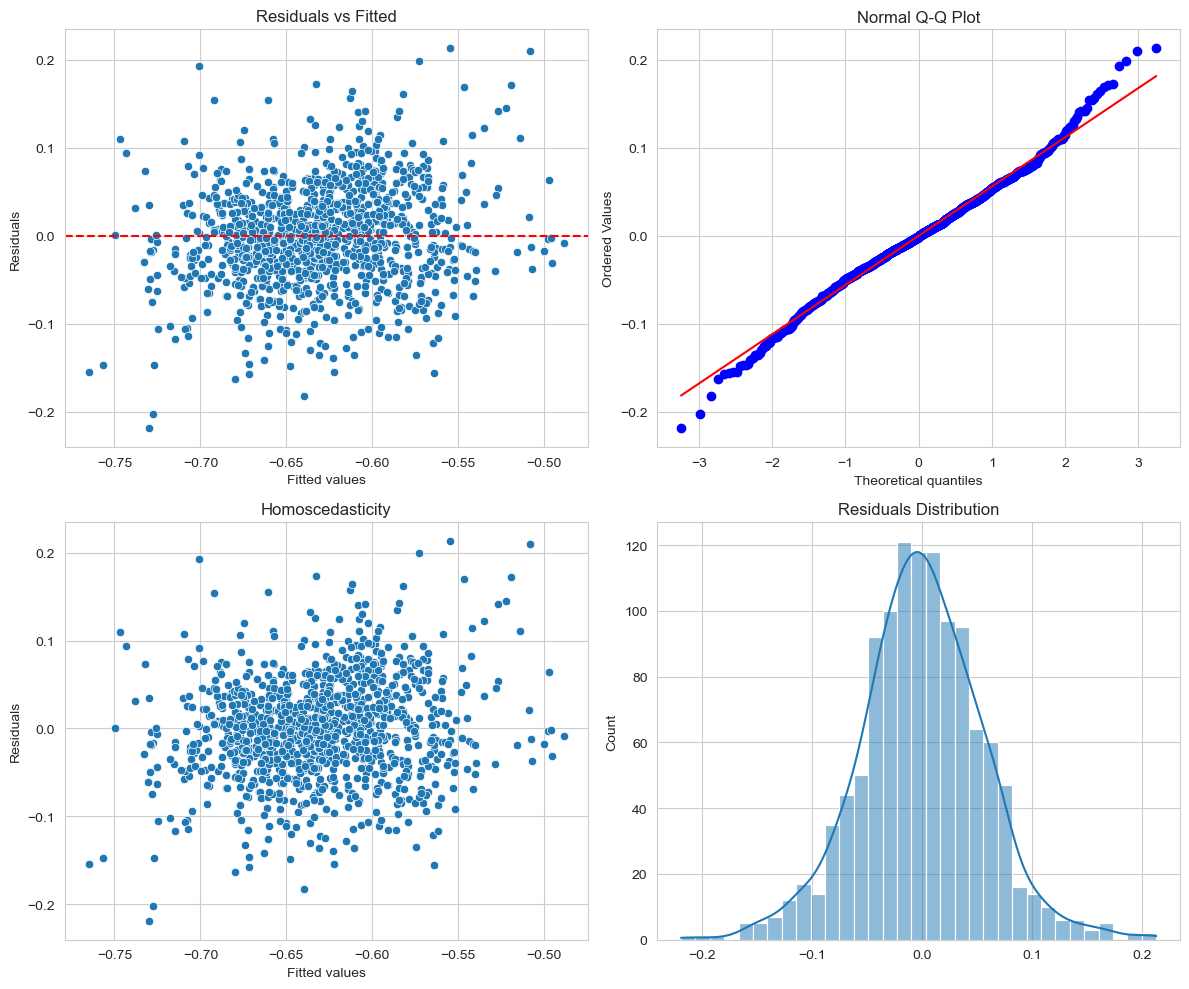

Shapiro-Wilk test p-value: 8.464694474241696e-06
Residuals are not homoscedastic LeveneResult(statistic=5.767663707567157, pvalue=0.0006480556133109319)
Bartlett’s test p-value: 3.4211179780525903e-18
White test p-value: 0.00019418168066745272
Levene’s test p-value for the whole model: 0.0006480556133109319
Levene’s test p-value for variable age: 0.41809083450030937
Levene’s test p-value for variable sex: 0.6756797431530316
Levene’s test p-value for variable outcome: 0.1628672918973392
Homoscedasticiyy checked
                                     Mixed Linear Model Regression Results
Model:                                MixedLM                   Dependent Variable:                   l_index  
No. Observations:                     1168                      Method:                               REML     
No. Groups:                           175                       Scale:                                0.0036   
Min. group size:                      4                         Log-Likel

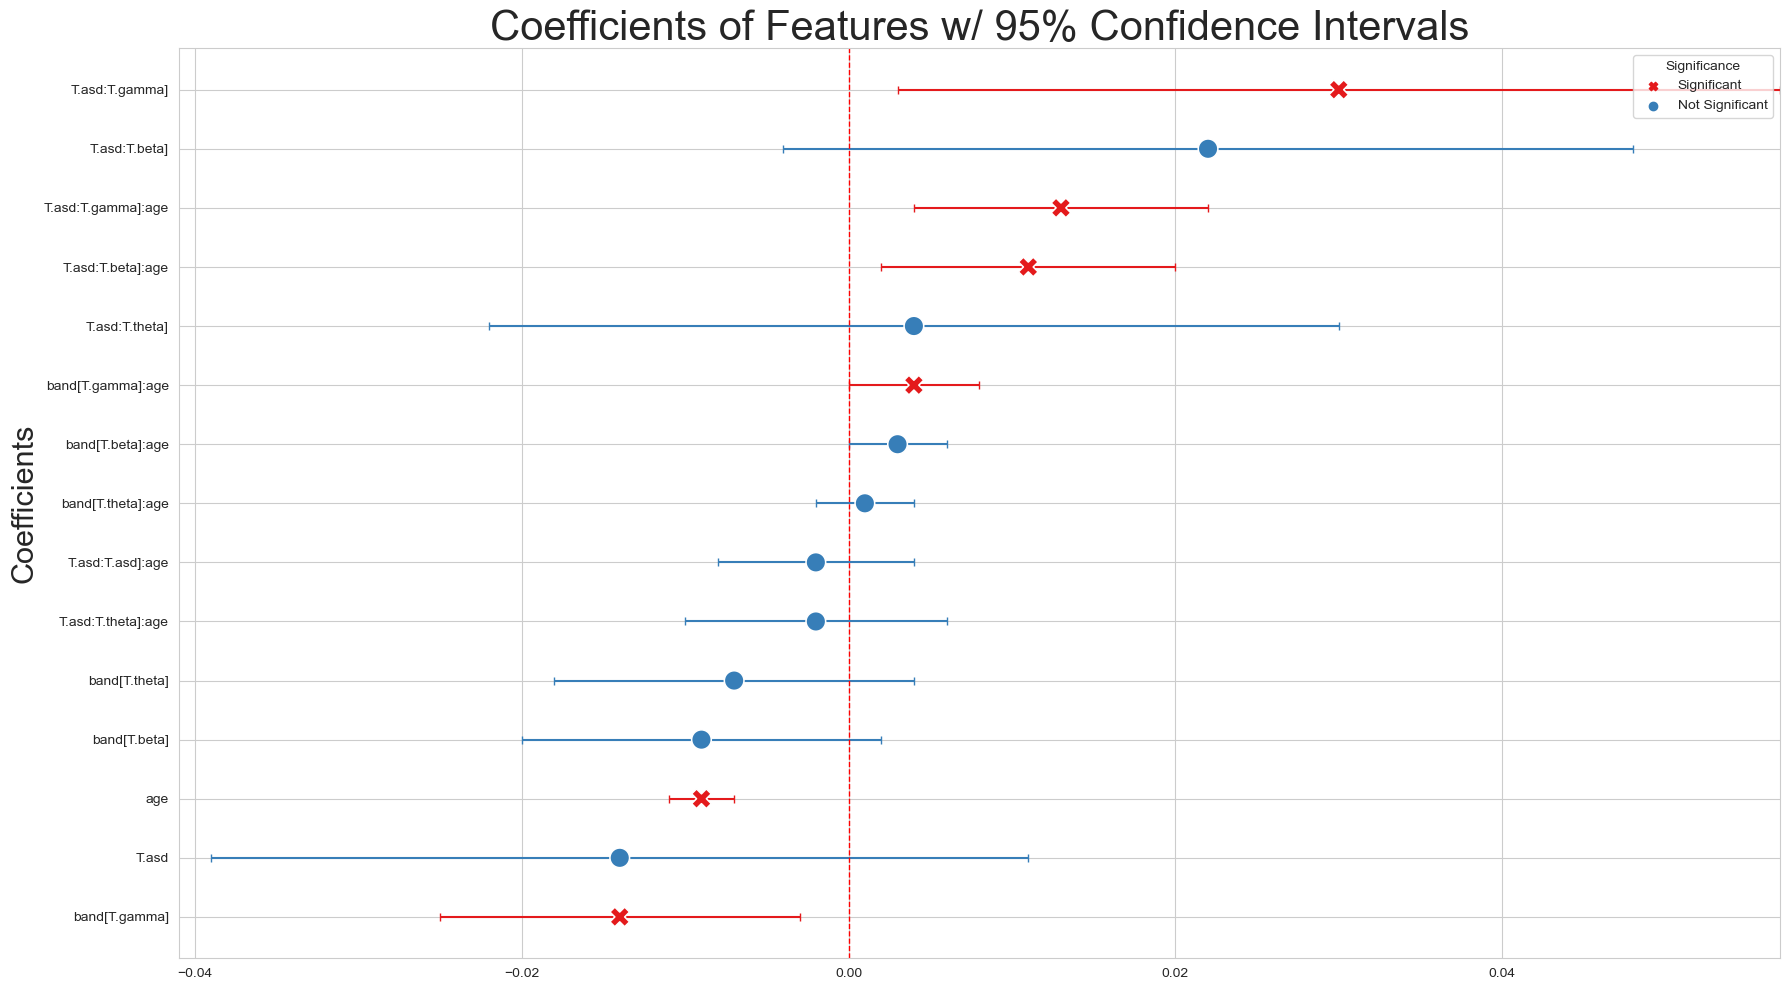

In [57]:
# Create df to be used 

model_formula ="l_index ~ C(outcome, Treatment(reference='no-asd')) * band * age"
# Create df to be used
df_name=eeg_long
df_name=df_name.loc[(df_name.age!=18) & (df_name.network=="all_regions")]

# Drop those without an outcome
df_name = df_name.dropna(subset=[comp_var])

# Do box cox transformation
df_name["l_index"] = stats.boxcox(df_name["l_index"]+ 0.33)[0]

# Mean centre age

df_name['age'] = df_name['age'] - df_name['age'].mean()

# Model 1: Simple model with age as a fixed effect
model1 = smf.mixedlm(model_formula, df_name, groups=df_name["subject"], re_formula="~1").fit()
# Check residuals
check_assumptions(model1, df_name, show_plots=True, show_text=True, covariates=["age","sex","outcome"])

# Print model 
print(model1.summary())

# Plot model 
coefplot_gap(model1, multiple_models=False, fig_name="original_model")

c:\Users\gabot\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


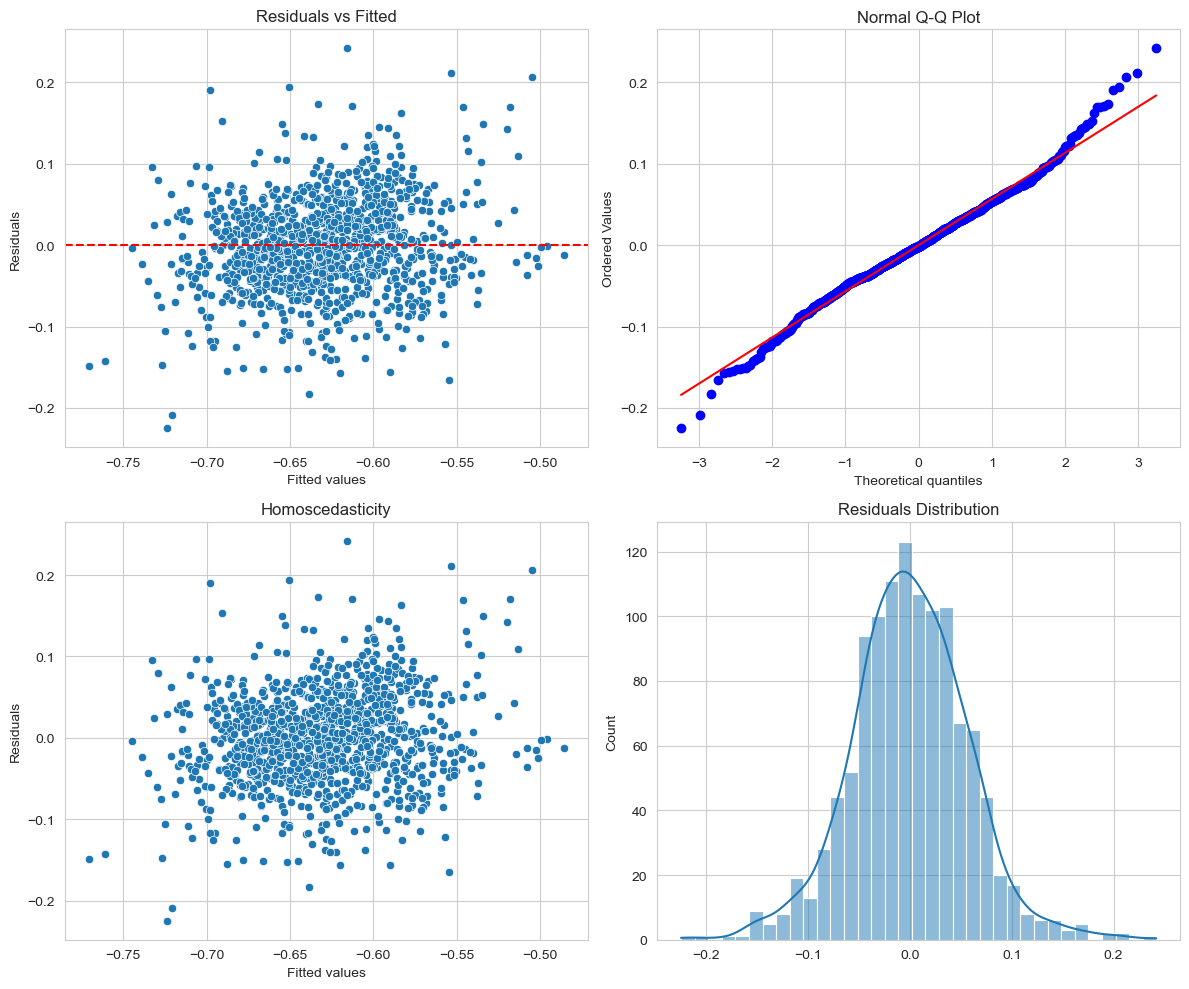

Shapiro-Wilk test p-value: 1.911930667120032e-06
Residuals are not homoscedastic LeveneResult(statistic=5.451668648717938, pvalue=0.0010085878332507354)
Bartlett’s test p-value: 9.889053498614285e-24
White test p-value: 1.4993354891149681e-05
Levene’s test p-value for the whole model: 0.0010085878332507354
Levene’s test p-value for variable age: 0.7198252790729449
Levene’s test p-value for variable sex: 0.5590015669935746
Levene’s test p-value for variable group_type: 0.04787921778563176
Homoscedasticiyy checked
                                    Mixed Linear Model Regression Results
Model:                               MixedLM                   Dependent Variable:                   l_index  
No. Observations:                    1168                      Method:                               REML     
No. Groups:                          175                       Scale:                                0.0037   
Min. group size:                     4                         Log-Likeliho

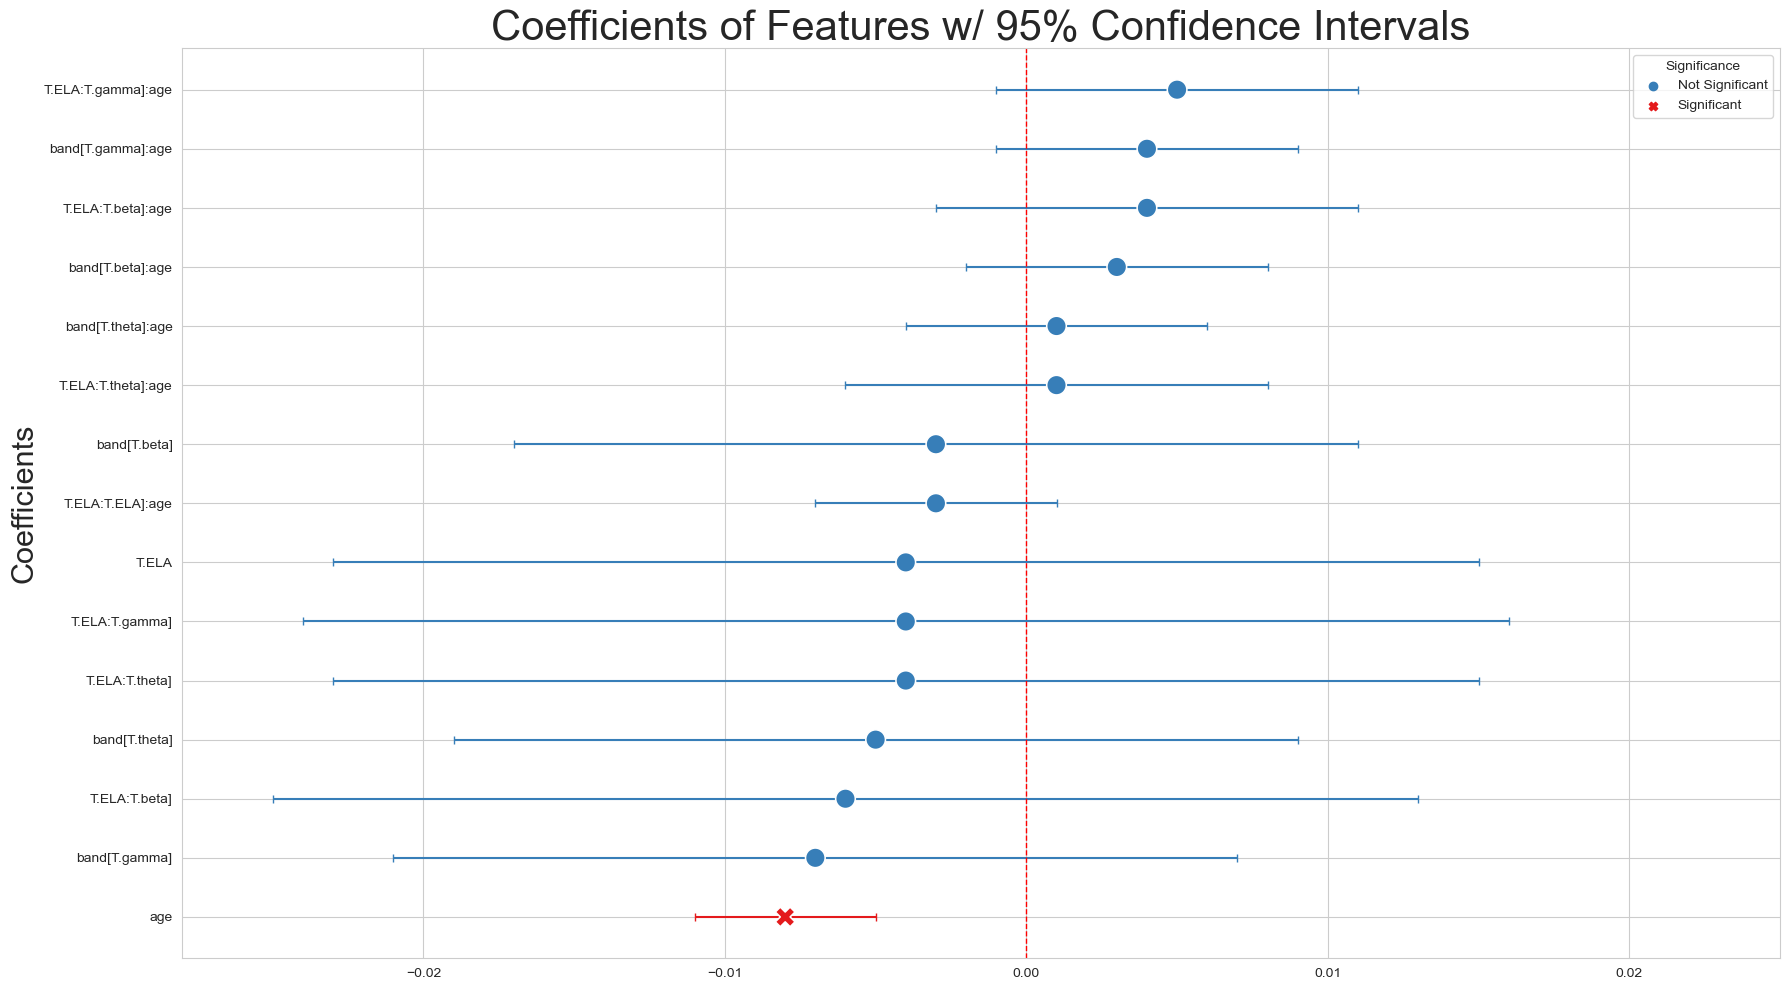

In [58]:
# Create df to be used 

model_formula ="l_index ~ C(group_type, Treatment(reference='TLA')) * band * age"
# Create df to be used
df_name=eeg_long
df_name=df_name.loc[(df_name.age!=18) & (df_name.network=="all_regions")]

# Drop those without an group_type
df_name = df_name.dropna(subset=["group_type"])

# Do box cox transformation
df_name["l_index"] = stats.boxcox(df_name["l_index"]+ 0.33)[0]

# Mean centre age

df_name['age'] = df_name['age'] - df_name['age'].mean()

# Model 1: Simple model with age as a fixed effect
model1 = smf.mixedlm(model_formula, df_name, groups=df_name["subject"], re_formula="~1").fit()
# Check residuals
check_assumptions(model1, df_name, show_plots=True, show_text=True, covariates=["age","sex","group_type"])

# Print model 
print(model1.summary())

# Plot model 
coefplot_gap(model1, multiple_models=False, fig_name="original_model")

### **Post hoc analyses** : Test gamma and alpha differences at each age group

In [60]:
# Conduct post hocs with pingouin

# Create df to be used
df_name=eeg_long
df_name=df_name.loc[(df_name.age==6) & (df_name.network=="all_regions")]

# Select only the gamma and alpha bands
df_name = df_name.loc[df_name.band.isin(["gamma", "alpha"])]

#df_name = df_name.loc[df_name.sex=="M"]

# Drop those without an outcome
df_name = df_name.dropna(subset=[comp_var])

# Do box cox transformation
df_name["l_index"] = stats.boxcox(df_name["l_index"]+ 0.33)[0]


# Conduct post hocs
pg.pairwise_tests(data=df_name, dv="l_index", within=["band"], subject="subject", padjust="fdr_bh", effsize="hedges", between="outcome", 
                    parametric=False)


c:\Users\gabot\anaconda3\lib\site-packages\pingouin\pairwise.py:478: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = data.groupby([subject, f], as_index=False, observed=True, sort=True).mean()


Contrast   band      A       B Paired  Parametric   U-val   W-val  \
0            band      -  alpha   gamma   True       False     NaN  2941.0   
1         outcome      -    asd  no-asd  False       False  1119.0     NaN   
2  band * outcome  alpha    asd  no-asd  False       False  1236.0     NaN   
3  band * outcome  gamma    asd  no-asd  False       False  1072.0     NaN   

  alternative     p-unc    p-corr p-adjust    hedges  
0   two-sided  0.000034       NaN      NaN  0.365557  
1   two-sided  0.306763       NaN      NaN -0.202266  
2   two-sided  0.724740  0.724740   fdr_bh -0.120141  
3   two-sided  0.196653  0.393306   fdr_bh -0.219803

C:\Users\gabot\AppData\Local\Temp\ipykernel_5592\442316686.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_name["l_index"] = stats.boxcox(df_name["l_index"]+ 0.33)[0]
c:\Users\gabot\anaconda3\lib\site-packages\seaborn\axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
c:\Users\gabot\anaconda3\lib\site-packages\seaborn\axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
c:\Users\gabot\anaconda3\lib\site-packages\seaborn\axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future ver

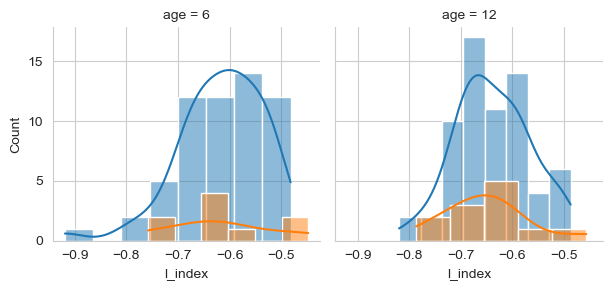

Contrast age    A       B Paired  Parametric  U-val  W-val  \
0            age   -    6      12   True       False    NaN  536.0   
1        outcome   -  asd  no-asd  False       False  148.0    NaN   
2  age * outcome   6  asd  no-asd  False       False  150.0    NaN   
3  age * outcome  12  asd  no-asd  False       False  151.0    NaN   

  alternative  p-unc  p-corr p-adjust  hedges  
0   two-sided   0.01     NaN      NaN    0.40  
1   two-sided   0.25     NaN      NaN   -0.44  
2   two-sided   0.27    0.28   fdr_bh   -0.34  
3   two-sided   0.28    0.28   fdr_bh   -0.27

In [61]:

# Create df to be used
df_name=eeg_long
df_name=df_name.loc[(df_name.age!=18) & (df_name.network=="all_regions")]

# Do box cox transformation
df_name["l_index"] = stats.boxcox(df_name["l_index"]+ 0.33)[0]

# Do only gamma
# Select only the gamma and alpha bands
df_name = df_name.loc[df_name.band.isin(["gamma"])]

# Select only males
df_name = df_name.loc[df_name.sex=="F"]
df_name = df_name.loc[df_name.sex=="F"]


# Drop those without an outcome
df_name = df_name.dropna(subset=[comp_var])

# Hist plot of the l_index for each age group
g = sns.FacetGrid(df_name, col="age", hue="outcome", col_wrap=4)
g.map(sns.histplot, "l_index", kde=True)

plt.show()


# Conduct post hocs
pg.pairwise_tests(data=df_name, dv="l_index", within=["age"], subject="subject", padjust="fdr_bh", alternative="two-sided",
                   effsize="hedges", between="outcome", parametric=False).round(2)

# **Network Analyses** 

In [71]:
# Select only gamm or freq of 40
regions_df = regions_df.loc[(regions_df.freq==40)]

In [72]:
### Graphic specifications
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 15

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


#### **Top regions for each age group**

In [73]:
# Select the top 5 regions

# Filter the data for the required age brackets and outcomes
lat_extremes = regions_df.loc[regions_df.band == "gamma"][["subject", "age", "region1", "l_index", "group_type"]]

# Define age brackets (you can adjust these as needed)
age_brackets = [6, 12]  # Example age brackets

# Initialize empty lists to store top and bottom regions
top_regions = []
bottom_regions = []
all_regions = []

# Loop through each age bracket and group_type group
for age in age_brackets:
    for group_type in ["TLA"]:
        # Filter data for the current age and group_type
        filtered_data = lat_extremes.loc[(lat_extremes.age == age) & (lat_extremes.group_type == group_type)]

        # Find the mean l_index for each region
        filtered_data = filtered_data.groupby("region1")["l_index"].mean().reset_index()
        
        # Calculate z-scores and p-values
        #filtered_data["z_scores"] = stats.zscore(filtered_data.l_index)
        #filtered_data["abs_z_scores"] = abs(filtered_data.z_scores)
        filtered_data["abs_l_index"] = abs(filtered_data["l_index"])
       # filtered_data["p_values"] = stats.norm.cdf(filtered_data.abs_z_scores)
        
        # Sort by p-values to get top and bottom regions
        sorted_data = filtered_data.sort_values(["abs_l_index"], ascending=False)

        # Add age
        sorted_data["age"] = age
       # sorted_data["group_type_group"] = group_type
        sorted_data=sorted_data.round(2)


        all_regions.append(sorted_data)


       # Get regoins with laterality index > 0.2
        top_regions.append(sorted_data.loc[sorted_data.abs_l_index > 0.2])
        
        # Get bottom 5 regions
        bottom_5 = sorted_data.tail(5)
        bottom_5["age"] = age
      #  bottom_5["group_type_group"] = group_type
        bottom_regions.append(bottom_5)

# Concatenate all the dataframes
top_regions_df = pd.concat(top_regions)
bottom_regions_df = pd.concat(bottom_regions)
all_regions_df = pd.concat(all_regions)

# Clean up the column names for the all regions dataframe
all_regions_df.rename(columns={"region1": "Name", "l_index": "Lateralization Index", "abs_l_index": "Abs Lateralization Index",
                               }, inplace=True)
all_regions_df = all_regions_df.reset_index(drop=True)



# Reset index for better readability
top_regions_df = top_regions_df.reset_index(drop=True)
bottom_regions_df = bottom_regions_df.reset_index(drop=True)



C:\Users\gabot\AppData\Local\Temp\ipykernel_5592\473305050.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bottom_5["age"] = age
C:\Users\gabot\AppData\Local\Temp\ipykernel_5592\473305050.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bottom_5["age"] = age


In [74]:
all_regions_df

Name  Lateralization Index  Abs Lateralization Index  \
0    caudalmiddlefrontal-rh                0.2300                    0.2300   
1       superiortemporal-rh                0.2200                    0.2200   
2          supramarginal-rh                0.2000                    0.2000   
3         middletemporal-rh                0.1500                    0.1500   
4        parahippocampal-rh               -0.1300                    0.1300   
..                      ...                   ...                       ...   
61            precentral-rh                0.0100                    0.0100   
62  rostralmiddlefrontal-rh               -0.0100                    0.0100   
63              fusiform-rh                0.0100                    0.0100   
64              bankssts-rh               -0.0100                    0.0100   
65       superiorfrontal-rh                0.0000                    0.0000   

    age  
0     6  
1     6  
2     6  
3     6  
4     6  
..  ...  
61   12  
62   12  
63   12  
64   12  
65   12  

[66 rows x 4 columns]

In [75]:
top_regions_df

region1  l_index  abs_l_index  age
0  caudalmiddlefrontal-rh   0.2300       0.2300    6
1     superiortemporal-rh   0.2200       0.2200    6
2  medialorbitofrontal-rh  -0.2800       0.2800   12
3        parsorbitalis-rh   0.2300       0.2300   12
4     inferiorparietal-rh   0.2200       0.2200   12

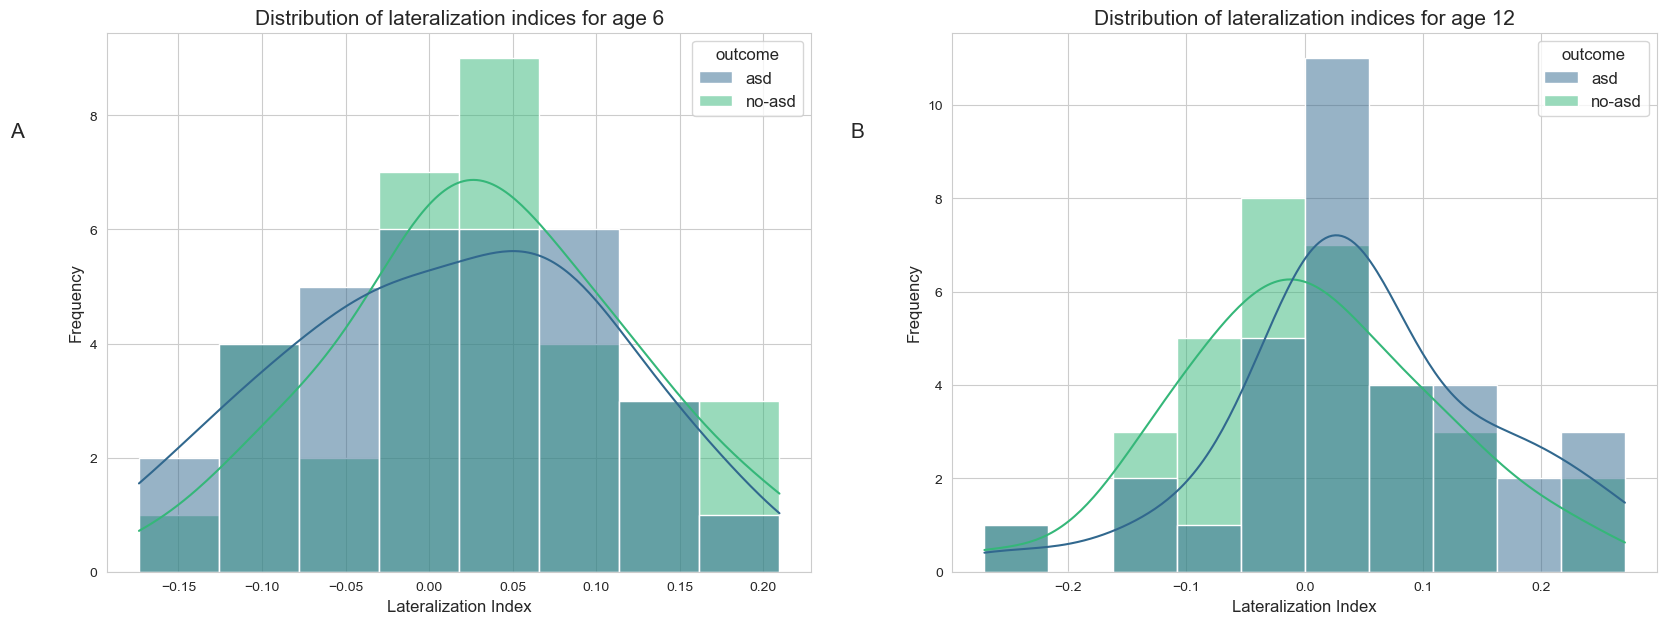

In [77]:
# Loop through ages 6 and 12

# Create a single figure with two subplots
fig = plt.figure(figsize=(20, 7), facecolor='white')

# Create subplots for age 6 (subplot A) and age 12 (subplot B)
ax1 = fig.add_subplot(121)  # Subplot for age 6
ax2 = fig.add_subplot(122)  # Subplot for age 12

# Loop through ages 6 and 12
for i, age in enumerate([6, 12]):
    # Filter the data for the current age and gamma band
    lat_extremes = regions_df.loc[regions_df.band == "gamma"][["subject", "age", "region1", "l_index", "outcome"]]
    lat_extremes = lat_extremes.loc[lat_extremes.age == age]

    # Group by region, age, and outcome, and calculate mean lateralization index
    lat_all_ages = lat_extremes.groupby(["region1", "age", "outcome"]).mean().reset_index().dropna()

    # Calculate z-scores, absolute z-scores, and p-values
    lat_all_ages["z_scores"] = stats.zscore(lat_all_ages.l_index)
    lat_all_ages["abs_z_scores"] = abs(lat_all_ages.z_scores)
    lat_all_ages["p_values"] = stats.norm.cdf(lat_all_ages.abs_z_scores)

    # Plot distribution of lateralization indices using a histogram
    if age == 6:
        ax = ax1  # Use the first subplot for age 6
    else:
        ax = ax2  # Use the second subplot for age 12

    sns.histplot(data=lat_all_ages, x="l_index", kde=True, ax=ax, hue="outcome", palette="viridis")
    ax.set_title(f"Distribution of lateralization indices for age {age}")
    ax.set_xlabel("Lateralization Index")
    ax.set_ylabel("Frequency")

# Add subplot labels (A and B)
plt.text(0.080, 0.73, "A", size=BIGGER_SIZE, ha="center", transform=fig.transFigure)
plt.text(0.5, 0.73, "B", size=BIGGER_SIZE, ha="center", transform=fig.transFigure)

# Adjust layout and display the plot
plt.show()


### Check group differences in lateralization at 12 months using t-tets

In [78]:
result=[]

# import multipletests test

from statsmodels.stats.multitest import multipletests
for age in [6]:
    for region in regions_df.region1.unique():
        region_dff = regions_df.loc[(regions_df.region1==region) & (regions_df.age==age)]
        # Log transformation of the lateralization index
        region_dff["l_index"] = np.log(region_dff["l_index"] + 1)
        asd= region_dff.loc[region_dff.outcome=="asd"]
        control= region_dff.loc[region_dff.outcome=="no-asd"]

        # Check for normality and do mannwhitneyu test if not normal
        shapiro_test = stats.shapiro(region_dff.l_index)
        if shapiro_test[1] > 0.05:
            test=stats.ttest_ind(asd.l_index, control.l_index)
            print(region, "not normal", age)
        else:
            test=stats.mannwhitneyu(asd.l_index, control.l_index)
        result.append([region, test.pvalue, age])
        if test.pvalue< 0.05:
            print( "***", region, test, age)

result_df=pd.DataFrame(result, columns=["region", "p_value", "age"])
# Adjust pvalues for multiple comparisons
result_df["p_value_adj"]=multipletests(result_df.p_value, method="fdr_bh")[1]
result_df=result_df.sort_values("p_value_adj")


caudalanteriorcingulate-rh not normal 6
cuneus-rh not normal 6
fusiform-rh not normal 6
*** insula-rh MannwhitneyuResult(statistic=876.0, pvalue=0.015805188770702264) 6
isthmuscingulate-rh not normal 6
*** posteriorcingulate-rh MannwhitneyuResult(statistic=920.0, pvalue=0.030660409054926396) 6
*** superiortemporal-rh MannwhitneyuResult(statistic=914.0, pvalue=0.028105787331809268) 6
transversetemporal-rh not normal 6


C:\Users\gabot\AppData\Local\Temp\ipykernel_5592\2445879620.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_dff["l_index"] = np.log(region_dff["l_index"] + 1)


In [79]:
result_df

region  p_value  age  p_value_adj
29          superiortemporal-rh   0.0281    6       0.3373
8                     insula-rh   0.0158    6       0.3373
22        posteriorcingulate-rh   0.0307    6       0.3373
20             pericalcarine-rh   0.0540    6       0.4456
0                   bankssts-rh   0.0736    6       0.4856
1    caudalanteriorcingulate-rh   0.1550    6       0.5798
2        caudalmiddlefrontal-rh   0.1419    6       0.5798
7           inferiortemporal-rh   0.1581    6       0.5798
12                   lingual-rh   0.1757    6       0.5798
21               postcentral-rh   0.1483    6       0.5798
28          superiorparietal-rh   0.5158    6       0.7092
27           superiorfrontal-rh   0.3672    6       0.7092
26      rostralmiddlefrontal-rh   0.4724    6       0.7092
25  rostralanteriorcingulate-rh   0.4654    6       0.7092
23                precentral-rh   0.4446    6       0.7092
17           parsopercularis-rh   0.3795    6       0.7092
16           parahippocampal-rh   0.4975    6       0.7092
15               paracentral-rh   0.3581    6       0.7092
13       medialorbitofrontal-rh   0.4278    6       0.7092
10          lateraloccipital-rh   0.4975    6       0.7092
9           isthmuscingulate-rh   0.3168    6       0.7092
6           inferiorparietal-rh   0.2463    6       0.7092
3                     cuneus-rh   0.4771    6       0.7092
32        transversetemporal-rh   0.3708    6       0.7092
14            middletemporal-rh   0.6043    6       0.7977
18             parsorbitalis-rh   0.7550    6       0.8147
19          parstriangularis-rh   0.7119    6       0.8147
24                 precuneus-rh   0.7377    6       0.8147
5                   fusiform-rh   0.6774    6       0.8147
4                frontalpole-rh   0.7681    6       0.8147
30             supramarginal-rh   0.7463    6       0.8147
31              temporalpole-rh   0.7901    6       0.8147
11      lateralorbitofrontal-rh   0.9247    6       0.9247

### **Region linear model analysis** 

In [80]:
eeg_long.network.unique()

array(['DMN', 'all_regions', 'attn', 'auditory', 'lang', 'visual'],
      dtype=object)

In [81]:
rois = ['DMN', 'auditory', 'lang', 'visual','attn']

c:\Users\gabot\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\gabot\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
c:\Users\gabot\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\gabot\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
c:\Users\gabot\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

Residuals are not homoscedastic LeveneResult(statistic=3.9107587302022115, pvalue=0.009224314712277552)
Homoscedasticiyy checked
DMN                              Mixed Linear Model Regression Results
Model:                           MixedLM              Dependent Variable:              l_index 
No. Observations:                292                  Method:                          REML    
No. Groups:                      175                  Scale:                           0.0141  
Min. group size:                 1                    Log-Likelihood:                  187.2655
Max. group size:                 2                    Converged:                       No      
Mean group size:                 1.7                                                           
-----------------------------------------------------------------------------------------------
                                                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------

c:\Users\gabot\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Homoscedasticiyy checked
auditory                              Mixed Linear Model Regression Results
Model:                          MixedLM               Dependent Variable:               l_index
No. Observations:               292                   Method:                           REML   
No. Groups:                     175                   Scale:                            0.0407 
Min. group size:                1                     Log-Likelihood:                   36.2078
Max. group size:                2                     Converged:                        Yes    
Mean group size:                1.7                                                            
-----------------------------------------------------------------------------------------------
                                                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------------
Intercept                          

c:\Users\gabot\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\gabot\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Homoscedasticiyy checked
lang                              Mixed Linear Model Regression Results
Model:                           MixedLM              Dependent Variable:              l_index 
No. Observations:                292                  Method:                          REML    
No. Groups:                      175                  Scale:                           0.0259  
Min. group size:                 1                    Log-Likelihood:                  100.9898
Max. group size:                 2                    Converged:                       Yes     
Mean group size:                 1.7                                                           
-----------------------------------------------------------------------------------------------
                                                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------------
Intercept                              

c:\Users\gabot\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Homoscedasticiyy checked
visual                              Mixed Linear Model Regression Results
Model:                           MixedLM              Dependent Variable:              l_index 
No. Observations:                292                  Method:                          REML    
No. Groups:                      175                  Scale:                           0.0192  
Min. group size:                 1                    Log-Likelihood:                  141.2162
Max. group size:                 2                    Converged:                       Yes     
Mean group size:                 1.7                                                           
-----------------------------------------------------------------------------------------------
                                                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------------
Intercept                            

c:\Users\gabot\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Residuals are not homoscedastic LeveneResult(statistic=2.6482060935593337, pvalue=0.04920306237960959)
Homoscedasticiyy checked
attn                              Mixed Linear Model Regression Results
Model:                           MixedLM              Dependent Variable:              l_index 
No. Observations:                292                  Method:                          REML    
No. Groups:                      175                  Scale:                           0.0250  
Min. group size:                 1                    Log-Likelihood:                  105.9502
Max. group size:                 2                    Converged:                       Yes     
Mean group size:                 1.7                                                           
-----------------------------------------------------------------------------------------------
                                                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------

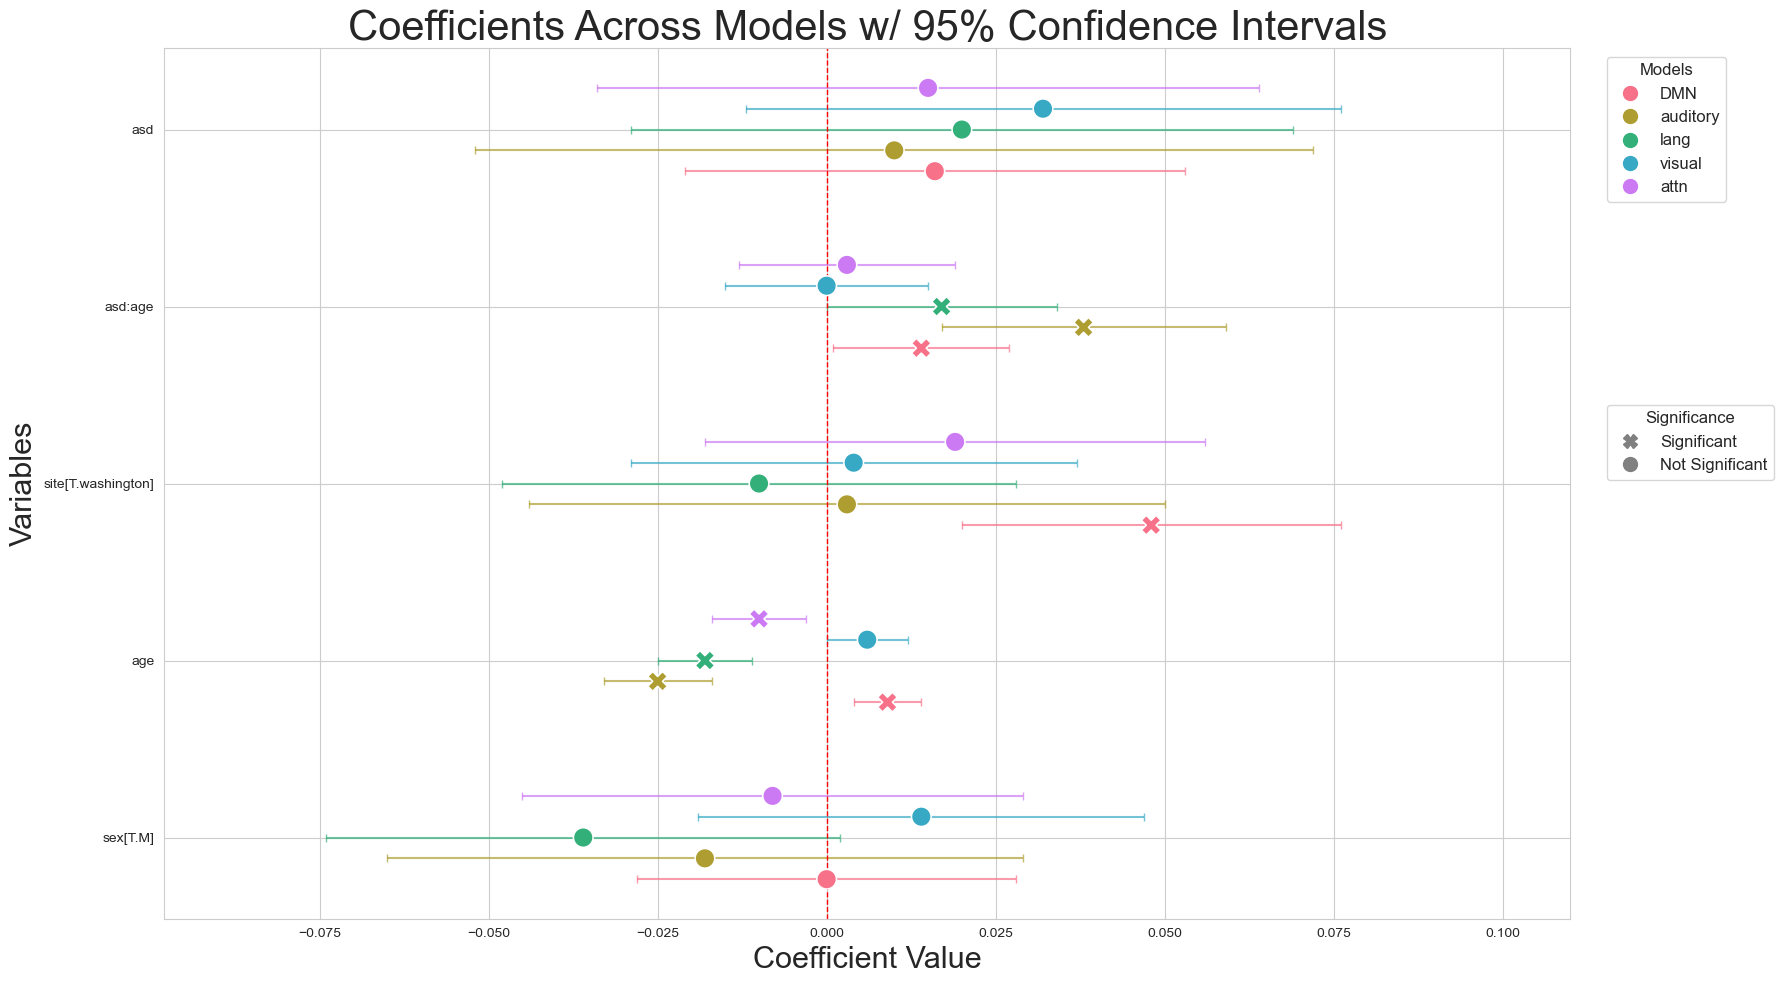

In [82]:
# Create df to be used 
# Append model comparisons to a list
model_comparisons_list = []

# Model to append all coefficients
model_coefficients=[]
for network in rois:
    models_comp= {"2_way_age": f"l_index ~ C({comp_var}, Treatment(reference='no-asd')) * age + sex + site" }
    for model_name, model_formula in models_comp.items():
        df_name=eeg_long
        df_name=df_name.loc[(df_name.age!=18)]
        df_name= df_name.loc[df_name.band=="gamma"]
        df_name= df_name.loc[df_name.network==network]
        model_name= model_name + "_" + network
        # Drop those without an outcome
        df_name = df_name.dropna(subset=[comp_var])

        # Do box cox transformation
        df_name["l_index"] = stats.boxcox(df_name["l_index"]+ 1)[0]

        # mean centre the age
        df_name['age'] = df_name['age'] - df_name['age'].mean()


        # Model formula 
        #model_formula = "l_index ~ C(outcome, Treatment(reference='control')) * age * sex + site"

        # Simple linear model 
        #model = smf.ols(model_formula, df_name).fit()

        # Model 1: Simple model with age as a fixed effect
        model1 = smf.mixedlm(model_formula, df_name, groups=df_name["subject"], re_formula="1").fit()

        # Model 2: Simple model with random intercepts and slope for each subject 
        #model2 = smf.mixedlm(model_formula, df_name, groups=df_name["subject"], re_formula="~1+age").fit()

        # Model 3: Simple model with random intercepts and slope for each subject and random intercepts for each site
        #model3 = smf.mixedlm(model_formula, df_name, groups=df_name["subject"], re_formula="~1+age+site").fit()

        # Model accounting for variance in the site variable
        #model4 = smf.mixedlm(model_formula, df_name, groups=df_name["subject"], re_formula="~1+age+site", vc_formula={"site": "0+C(site)"}).fit()

        # Model accounting for variance in the site variable using weights 
        #weights = 1 / df_name.groupby("site")["l_index"].transform("std")**2
        #model5 = sm.GLS.from_formula(model_formula, df_name, weights=weights).fit()

        # Compare models
        coeff_dfs = []

        #****** IF YOU WANT TO COMPARE MANY MODELS models = [model, model2, model3, model4, model5]
        models = [model1]

        log_likelihoods = [model.llf for model in models]
        aic = [model.aic for model in models]
        bic = [model.bic for model in models]
        # Create dictionary with model names 
        model_names = [network + "_" + "Mix Rand-int"]

        model_comparison = pd.DataFrame({"log_likelihood": log_likelihoods, "aic": aic, "bic": bic}, index=model_names)
        # Collect homoscedasticity test results
        hom_test_results = []

        for model in models:
            hom_test_df = check_homoscedasticity(model, df_name, show_text=False, co_vars=["age", "outcome", "sex"])
            hom_test_results.append(hom_test_df.iloc[0])  # Assuming results are in a single row

            coeff_df = stage_model(model)
            coeff_dfs.append(coeff_df)

        # Print model summary 
        print(network, model1.summary())

        # Convert list of series to a DataFrame
        hom_test_df_combined = pd.DataFrame(hom_test_results, index=model_comparison.index)

        # Merge with model comparison DataFrame
        model_comparison = pd.concat([model_comparison, hom_test_df_combined], axis=1)
        print(network, model_comparison)

        # Print model comparison results
        
        # Create df with all coefficients
        all_coefs = pd.concat(coeff_dfs, keys=model_names).reset_index()

        all_coefs["model_name"] = network
        all_coefs["model"] = network

        # Append all coeffts
        model_coefficients.append(all_coefs)
        model_comparisons_list.append(model_comparison)

    # Create a df with all model comparisons
model_comparisons_df = pd.concat(model_comparisons_list).reset_index()
model_coefficients_df = pd.concat(model_coefficients)

model_coefficients_df.replace("C(outcome, Treatment(reference='no-asd'))[T.asd]", "asd", inplace=True)
model_coefficients_df.replace("C(outcome, Treatment(reference='no-asd'))[T.asd]:age", "asd:age", inplace=True)
model_coefficients_df.replace("C(outcome, Treatment(reference='no-asd'))[T.asd]:sex[T.M]", "asd:sex[T.M]", inplace=True)
model_coefficients_df.replace("C(outcome, Treatment(reference='no-asd'))[T.asd]:age:sex[T.M]","asd:age:sex[T.M]" ,inplace=True)

coefplot_gap(model_coefficients_df, multiple_models=True, fig_name="all_models")


# Drop unwanted columns
model_coefficients_df.drop(columns=["level_1","model_name"], inplace=True)
model_coefficients_df.rename(columns={"level_0": "model"}, inplace=True)


In [83]:
model_coefficients_df

model               index   Coef. Std.Err.    stat   pval  \
0       DMN_Mix Rand-int                 asd  0.0160    0.019   0.867 0.3860   
1       DMN_Mix Rand-int            sex[T.M] -0.0000    0.014  -0.005 0.9960   
2       DMN_Mix Rand-int  site[T.washington]  0.0480    0.014   3.390 0.0010   
3       DMN_Mix Rand-int                 age  0.0090    0.003   3.402 0.0010   
4       DMN_Mix Rand-int             asd:age  0.0140    0.006   2.158 0.0310   
0  auditory_Mix Rand-int                 asd  0.0100    0.032   0.322 0.7470   
1  auditory_Mix Rand-int            sex[T.M] -0.0180    0.024  -0.745 0.4560   
2  auditory_Mix Rand-int  site[T.washington]  0.0030    0.024   0.140 0.8890   
3  auditory_Mix Rand-int                 age -0.0250    0.004  -5.747 0.0000   
4  auditory_Mix Rand-int             asd:age  0.0380    0.011   3.537 0.0000   
0      lang_Mix Rand-int                 asd  0.0200    0.025   0.802 0.4220   
1      lang_Mix Rand-int            sex[T.M] -0.0360    0.019  -1.857 0.0630   
2      lang_Mix Rand-int  site[T.washington] -0.0100    0.019  -0.507 0.6120   
3      lang_Mix Rand-int                 age -0.0180    0.003  -5.194 0.0000   
4      lang_Mix Rand-int             asd:age  0.0170    0.008   1.987 0.0470   
0    visual_Mix Rand-int                 asd  0.0320    0.022   1.441 0.1500   
1    visual_Mix Rand-int            sex[T.M]  0.0140    0.017   0.808 0.4190   
2    visual_Mix Rand-int  site[T.washington]  0.0040    0.017   0.218 0.8270   
3    visual_Mix Rand-int                 age  0.0060    0.003   1.960 0.0500   
4    visual_Mix Rand-int             asd:age -0.0000    0.007  -0.062 0.9500   
0      attn_Mix Rand-int                 asd  0.0150    0.025   0.596 0.5510   
1      attn_Mix Rand-int            sex[T.M] -0.0080    0.019  -0.439 0.6610   
2      attn_Mix Rand-int  site[T.washington]  0.0190    0.019   0.998 0.3180   
3      attn_Mix Rand-int                 age -0.0100    0.003  -3.002 0.0030   
4      attn_Mix Rand-int             asd:age  0.0030    0.008   0.365 0.7150   

   [0.025  0.975]  errors     model  
0 -0.0210   0.053  0.0370       DMN  
1 -0.0280   0.028  0.0280       DMN  
2  0.0200   0.076  0.0280       DMN  
3  0.0040   0.014  0.0050       DMN  
4  0.0010   0.026  0.0130       DMN  
0 -0.0520   0.073  0.0620  auditory  
1 -0.0650   0.029  0.0470  auditory  
2 -0.0440   0.051  0.0470  auditory  
3 -0.0330  -0.016  0.0080  auditory  
4  0.0170   0.059  0.0210  auditory  
0 -0.0290   0.070  0.0490      lang  
1 -0.0740   0.002  0.0380      lang  
2 -0.0480   0.028  0.0380      lang  
3 -0.0250  -0.011  0.0070      lang  
4  0.0000   0.034  0.0170      lang  
0 -0.0120   0.076  0.0440    visual  
1 -0.0190   0.047  0.0330    visual  
2 -0.0290   0.037  0.0330    visual  
3  0.0000   0.012  0.0060    visual  
4 -0.0150   0.014  0.0150    visual  
0 -0.0340   0.064  0.0490      attn  
1 -0.0450   0.029  0.0370      attn  
2 -0.0180   0.056  0.0370      attn  
3 -0.0170  -0.004  0.0070      attn  
4 -0.0130   0.019  0.0160      attn

In [84]:
model_comparisons_df

index  log_likelihood  aic  bic  levene_test_all  \
0       DMN_Mix Rand-int        187.2655  NaN  NaN           0.0092   
1  auditory_Mix Rand-int         36.2078  NaN  NaN           0.7358   
2      lang_Mix Rand-int        100.9898  NaN  NaN           0.5143   
3    visual_Mix Rand-int        141.2162  NaN  NaN           0.6399   
4      attn_Mix Rand-int        105.9502  NaN  NaN           0.0492   

   white_test  bartlett_test  shapiro_test  multicollinearity    age  outcome  \
0      0.0113         0.0000        0.0874             1.2028 0.7214   0.2887   
1      0.0397         0.0000        0.6054             1.2028 0.9076   0.3122   
2      0.1175         0.0000        0.5350             1.2028 0.9928   0.4473   
3      0.0940         0.0000        0.0409             1.2028 0.2455   0.6352   
4      0.1052         0.0000        0.1631             1.2028 0.6553   0.9345   

     sex  
0 0.9483  
1 0.6903  
2 0.8345  
3 0.1507  
4 0.5932

In [85]:
# Adjust pvalues for multiple comparisons
model_coefficients_df["pval_adj"]=multipletests(model_coefficients_df.pval, method="bonf")[1]

#### Regions that survided bonferroni corrections

In [87]:
# Check only those with an adjusted pvalue < 0.05
model_coefficients_df.loc[model_coefficients_df.pval_adj<0.05]

model               index   Coef. Std.Err.    stat   pval  \
2       DMN_Mix Rand-int  site[T.washington]  0.0480    0.014   3.390 0.0010   
3       DMN_Mix Rand-int                 age  0.0090    0.003   3.402 0.0010   
3  auditory_Mix Rand-int                 age -0.0250    0.004  -5.747 0.0000   
4  auditory_Mix Rand-int             asd:age  0.0380    0.011   3.537 0.0000   
3      lang_Mix Rand-int                 age -0.0180    0.003  -5.194 0.0000   

   [0.025  0.975]  errors     model  pval_adj  
2  0.0200   0.076  0.0280       DMN    0.0250  
3  0.0040   0.014  0.0050       DMN    0.0250  
3 -0.0330  -0.016  0.0080  auditory    0.0000  
4  0.0170   0.059  0.0210  auditory    0.0000  
3 -0.0250  -0.011  0.0070      lang    0.0000

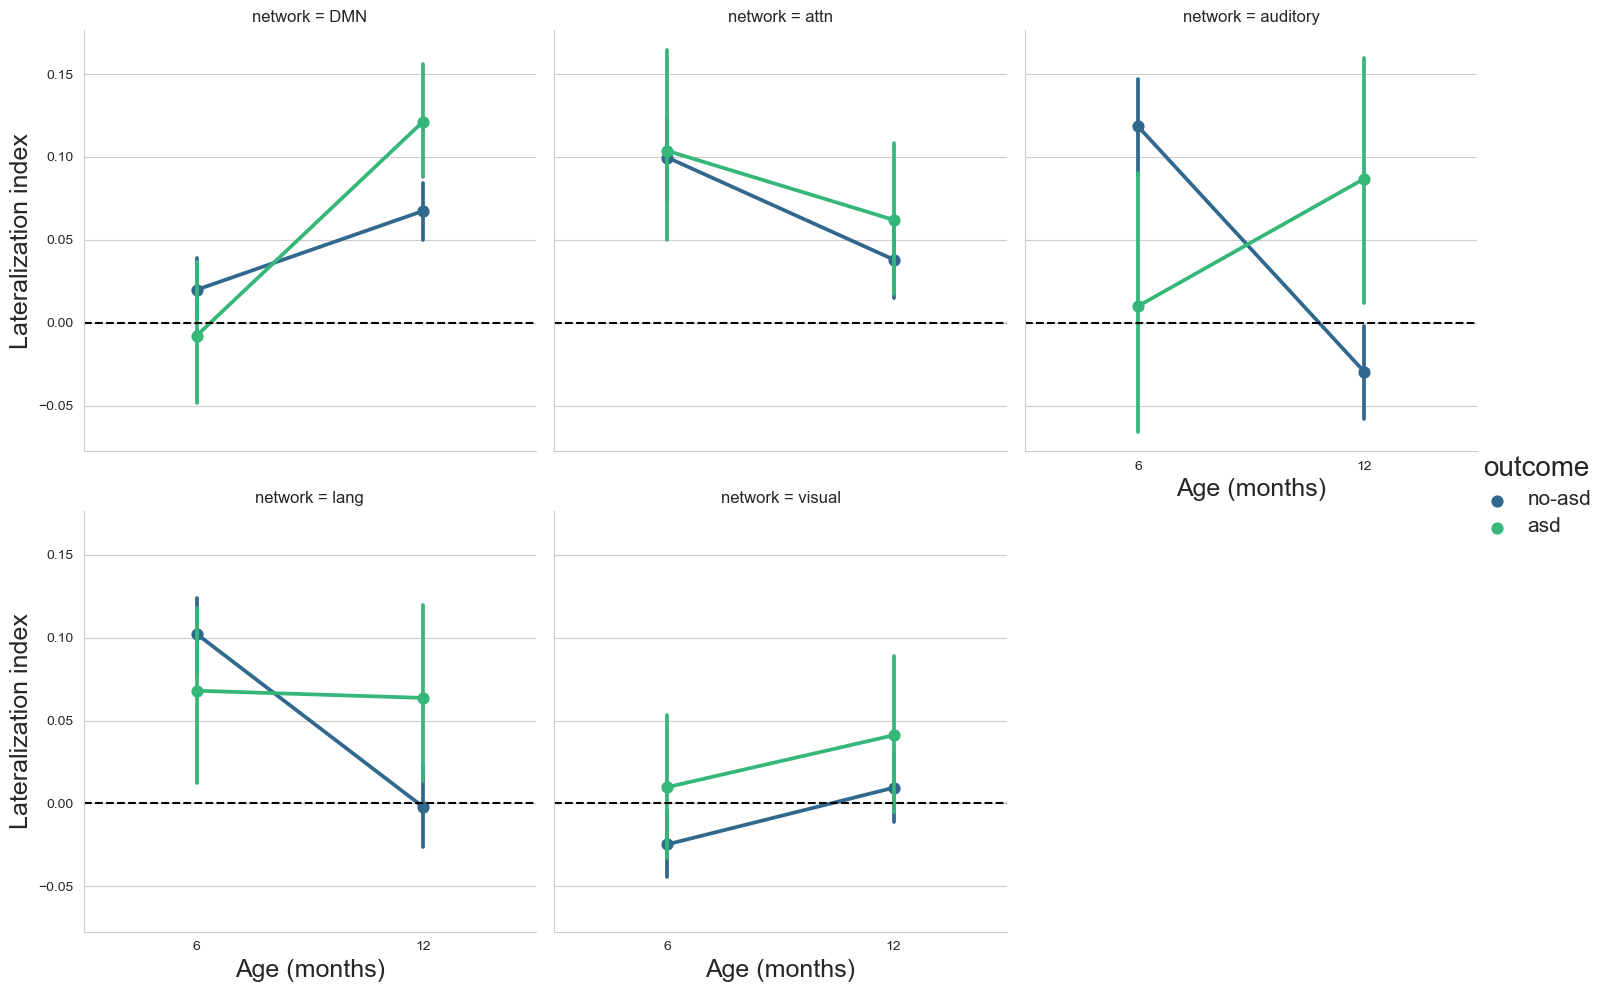

In [88]:
# Plot changes in lateralization for all regions

# Plot the data

sns.set_style('whitegrid')

df_name=eeg_long
df_name=df_name.loc[(df_name.age!=18)]
# Subset only the regions of interest
# do only gamma
df_name = df_name[df_name["band"]=="gamma"]
# Drop networks attention and all regions
#df_name = df_name.loc[df_name.network!="attn"]
df_name = df_name.loc[df_name.network!="all_regions"]

# Plot only max  per colum
g= sns.catplot(x="age",y="l_index", ci=90,hue=comp_var,palette="viridis",data=df_name,col="network", kind="point", col_wrap=3)


g.set_ylabels("Lateralization index",fontsize=18)
g.set_xlabels("Age (months)",fontsize=18)

# Add a horizontal line at 0 for each plot 

for ax in g.axes.flat:
    ax.axhline(0, color='black', linestyle='--')



plt.setp(g._legend.get_title(), fontsize=20)
plt.setp(g._legend.get_texts(), fontsize=15) # for legend text
#g.savefig("./paper_1_figs/region_trajectories_outcomes.png")
plt.show(g)

##### **Preliminary interpretations** : Children with ASD have a different trajectory in the auditory network